# Starbucks Capstone Challenge

## Table of Content

####  [I. Problem Statement](#101)
####  [II. Data Sets](#102)
####  [III.: Data Cleaning](#103) 
####  [IV: Data Visualisation](#104) 
- [Among the Test Participants, How Many Offers are Viewed and Responded?](#104-1)  
- [How Long Does it Take for the Offer to be Viewed?](#104-2) 
- [What Types of Offer are Most Likely to be Responded?](#104-3) 
- [What is the General Demographics of Each Offer Type?](#104-4) 

####  [V:  Build Model](#105) 
- [Pre-processing Data for Modelling](#105-1) 
- [Model Training and Model Refinement Using Hyperparameter Tuning](#105-2) 
- [Feature Importance](#105-3) 

####  [VI: Conclusion](#106)  

# <a id = "101"> I. Problem Statement</a>

Data can tell a lot of stories about customer behaviour. Thanks to Big Data, we are able to have a better insight into purchase details, for example, what is the demographics of the customers who made the purchase, which products are the most popular in the region, or which offers attract the most customer responses. In this project, I am going to use the sample datasets of Starbucks data, provided by Udacity, to analyse the customer behaviour towards the Starbucks promotional offers, build a model to predict whether a customer will respond to an offer and suggest what features will motivate the customers to make the purchase with the offer.

To understand customer responses towards the promotional offers and analyse the most important features to drive their decisions, I am going to do the following steps:

- investigate the offer response stats of the sample customers
- identify the demographic groups for customers who respond to the viewed offer
- build a machine learning model to predict whether a customer will respond to an offer

## <a id = "102"> II. Data Sets</a>

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
%cd /Users/yc28/Desktop/Coding/Udacity_DS/starbucks_offer_ML/

/Users/yc28/Desktop/Coding/Udacity_DS/starbucks_offer_ML


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json
% matplotlib inline


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, precision_recall_curve, classification_report, roc_auc_score


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# <a id = "103">III. Data Cleaning </a>

####  profile.json
- Remove customers with unknown age and gender 
- Fill NaN income with mean income values
- Change became_member_on column to date type

#### transcript.json
- change time unit from hour to day in order to match portfolio's duration column
- convert dict to list in value column
- create a separate column for the reward amount

In [6]:
def clean_profile(df):
    # Remove customers with unknown age and gender
    df = df[df.age != 118]
    df = df[~df.gender.isnull()]
    print('Removed customers with unknown age and gender')
    
    # Fill NaN income with mean income values
    df.income.fillna(df.income.mean(), inplace = True)
    print('Filled NaN income with mean income values')
    
    # Change became_member_on column to date type
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(x, format='%Y%m%d', errors='ignore'))
    print('Changed became_member_on column to date type')  
    print(' ')
    print('*** Cleaning process complete! ***')
    
    return df

In [7]:
profile_clean = clean_profile(profile)
profile_clean.shape

Removed customers with unknown age and gender
Filled NaN income with mean income values
Changed became_member_on column to date type
 
*** Cleaning process complete! ***


(14825, 5)

In [8]:
# verify unknown values have been dealt with
print('Customers with unknown age:', profile_clean[profile_clean.age==118].shape[0])
print('Customers with unknown gender', profile_clean.gender.isnull().sum())
print('Customers with unknown income',profile_clean.income.isnull().sum())

Customers with unknown age: 0
Customers with unknown gender 0
Customers with unknown income 0


In [9]:
def clean_transcript(df):
    # change time unit from hour to day in order to match portfolio's duration column
    df['time'] = round(df['time']/24,1)
    # convert dict to list in value column
    df['value'] = df['value'].apply(lambda x: list(x.values()))
    # create a separate column for the reward amount
    df[['value','reward']] = pd.DataFrame(df.value.tolist(), index= df.index)
    
    return df

In [10]:
transcript_clean = clean_transcript(transcript)

In [11]:
# create a new df, transcript_response, that records all offers received and their response
# new columns: key for person-offer id, offer viewed(int), offer responded time(int)
transcript_clean['key'] = transcript_clean['person']+'$'+ transcript_clean['value'].astype(str)
transcript_response = transcript_clean[transcript_clean.event == 'offer received']

In [12]:
transcript_clean[transcript_clean.person=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value,reward,key
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef$9b98b8c7a33c4...
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,0.2,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,78afa995795e4d85b5d9ceeca43f5fef$9b98b8c7a33c4...
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,5.5,19.89,NaN,78afa995795e4d85b5d9ceeca43f5fef$19.89
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,5.5,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,78afa995795e4d85b5d9ceeca43f5fef$9b98b8c7a33c4...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,6.0,17.78,NaN,78afa995795e4d85b5d9ceeca43f5fef$17.78
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,7.0,5a8bc65990b245e5a138643cd4eb9837,NaN,78afa995795e4d85b5d9ceeca43f5fef$5a8bc65990b24...
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,9.0,5a8bc65990b245e5a138643cd4eb9837,NaN,78afa995795e4d85b5d9ceeca43f5fef$5a8bc65990b24...
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,9.2,19.67,NaN,78afa995795e4d85b5d9ceeca43f5fef$19.67
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,10.0,29.72,NaN,78afa995795e4d85b5d9ceeca43f5fef$29.72
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,15.8,23.93,NaN,78afa995795e4d85b5d9ceeca43f5fef$23.93


In [13]:
def get_offer_viewed(key, person, index):
    '''
    
    Mark whether the offer has been viewed, 
    if viewed, the value shows the number of days after the offer is received
    
    Args:
        key - the unique person-offer id combi
        index - the index number of the key
    
    Returns:
        offer_viewed - offer viewed results
        
            There are 3 types of results
            -1: if the first event is not offer received
            a number (float): the days between offer received and offer viewed
            99.99: if the offer is not viewed
            
        offer_responded - offer response
            1: responded
            0: not responded
        
    '''


    df = transcript_clean[(transcript_clean.key == key)&(transcript_clean.index >= index)]
    offer_responded = 0
    
    offer_id = df[df.index==index].value[index]
    expiry_day = portfolio[portfolio.id == offer_id].duration.values[0] + df[df.event=='offer received'].time.values[0]
    df_timed = transcript_clean[(transcript_clean.person == person)&(transcript_clean.time <= expiry_day)]
                
    try:

        if len(list(df.event)) >2: # check the event list is greater than 2 & 'offer viewed' is right after 'offer received'

            if list(df.event)[1] == 'offer viewed': # calculate offer viewed time
                offer_viewed = df[df.event=='offer viewed'].time.values[0] - df[df.event=='offer received'].time.values[0]

                if 'transaction' in list(df_timed.event): #  check transaction
                    offer_responded = 1

            else: # if the event list is smaller than 2, it means the offer is not viewed
                offer_viewed = 99.99
                
                if 'transaction' in list(df_timed.event):
                    offer_responded = 1

        else: 
            offer_viewed = 99.99 # offer not viewed
    except:
        print('Error with index:',index)
    
    print('Index {} processed'.format(index))
        
    
    return offer_viewed, offer_responded

In [14]:
transcript_response['offer_viewed'] = transcript_response.apply(lambda x: get_offer_viewed(x.key, x.person, x.name), axis=1)

Index 0 processed
Index 1 processed
Index 2 processed
Index 3 processed
Index 4 processed
Index 5 processed
Index 6 processed
Index 7 processed
Index 8 processed
Index 9 processed
Index 10 processed
Index 11 processed
Index 12 processed
Index 13 processed
Index 14 processed
Index 15 processed
Index 16 processed
Index 17 processed
Index 18 processed
Index 19 processed
Index 20 processed
Index 21 processed
Index 22 processed
Index 23 processed
Index 24 processed
Index 25 processed
Index 26 processed
Index 27 processed
Index 28 processed
Index 29 processed
Index 30 processed
Index 31 processed
Index 32 processed
Index 33 processed
Index 34 processed
Index 35 processed
Index 36 processed
Index 37 processed
Index 38 processed
Index 39 processed
Index 40 processed
Index 41 processed
Index 42 processed
Index 43 processed
Index 44 processed
Index 45 processed
Index 46 processed
Index 47 processed
Index 48 processed
Index 49 processed
Index 50 processed
Index 51 processed
Index 52 processed
Ind

Index 419 processed
Index 420 processed
Index 421 processed
Index 422 processed
Index 423 processed
Index 424 processed
Index 425 processed
Index 426 processed
Index 427 processed
Index 428 processed
Index 429 processed
Index 430 processed
Index 431 processed
Index 432 processed
Index 433 processed
Index 434 processed
Index 435 processed
Index 436 processed
Index 437 processed
Index 438 processed
Index 439 processed
Index 440 processed
Index 441 processed
Index 442 processed
Index 443 processed
Index 444 processed
Index 445 processed
Index 446 processed
Index 447 processed
Index 448 processed
Index 449 processed
Index 450 processed
Index 451 processed
Index 452 processed
Index 453 processed
Index 454 processed
Index 455 processed
Index 456 processed
Index 457 processed
Index 458 processed
Index 459 processed
Index 460 processed
Index 461 processed
Index 462 processed
Index 463 processed
Index 464 processed
Index 465 processed
Index 466 processed
Index 467 processed
Index 468 processed


Index 833 processed
Index 834 processed
Index 835 processed
Index 836 processed
Index 837 processed
Index 838 processed
Index 839 processed
Index 840 processed
Index 841 processed
Index 842 processed
Index 843 processed
Index 844 processed
Index 845 processed
Index 846 processed
Index 847 processed
Index 848 processed
Index 849 processed
Index 850 processed
Index 851 processed
Index 852 processed
Index 853 processed
Index 854 processed
Index 855 processed
Index 856 processed
Index 857 processed
Index 858 processed
Index 859 processed
Index 860 processed
Index 861 processed
Index 862 processed
Index 863 processed
Index 864 processed
Index 865 processed
Index 866 processed
Index 867 processed
Index 868 processed
Index 869 processed
Index 870 processed
Index 871 processed
Index 872 processed
Index 873 processed
Index 874 processed
Index 875 processed
Index 876 processed
Index 877 processed
Index 878 processed
Index 879 processed
Index 880 processed
Index 881 processed
Index 882 processed


Index 1233 processed
Index 1234 processed
Index 1235 processed
Index 1236 processed
Index 1237 processed
Index 1238 processed
Index 1239 processed
Index 1240 processed
Index 1241 processed
Index 1242 processed
Index 1243 processed
Index 1244 processed
Index 1245 processed
Index 1246 processed
Index 1247 processed
Index 1248 processed
Index 1249 processed
Index 1250 processed
Index 1251 processed
Index 1252 processed
Index 1253 processed
Index 1254 processed
Index 1255 processed
Index 1256 processed
Index 1257 processed
Index 1258 processed
Index 1259 processed
Index 1260 processed
Index 1261 processed
Index 1262 processed
Index 1263 processed
Index 1264 processed
Index 1265 processed
Index 1266 processed
Index 1267 processed
Index 1268 processed
Index 1269 processed
Index 1270 processed
Index 1271 processed
Index 1272 processed
Index 1273 processed
Index 1274 processed
Index 1275 processed
Index 1276 processed
Index 1277 processed
Index 1278 processed
Index 1279 processed
Index 1280 pr

Index 1625 processed
Index 1626 processed
Index 1627 processed
Index 1628 processed
Index 1629 processed
Index 1630 processed
Index 1631 processed
Index 1632 processed
Index 1633 processed
Index 1634 processed
Index 1635 processed
Index 1636 processed
Index 1637 processed
Index 1638 processed
Index 1639 processed
Index 1640 processed
Index 1641 processed
Index 1642 processed
Index 1643 processed
Index 1644 processed
Index 1645 processed
Index 1646 processed
Index 1647 processed
Index 1648 processed
Index 1649 processed
Index 1650 processed
Index 1651 processed
Index 1652 processed
Index 1653 processed
Index 1654 processed
Index 1655 processed
Index 1656 processed
Index 1657 processed
Index 1658 processed
Index 1659 processed
Index 1660 processed
Index 1661 processed
Index 1662 processed
Index 1663 processed
Index 1664 processed
Index 1665 processed
Index 1666 processed
Index 1667 processed
Index 1668 processed
Index 1669 processed
Index 1670 processed
Index 1671 processed
Index 1672 pr

Index 2016 processed
Index 2017 processed
Index 2018 processed
Index 2019 processed
Index 2020 processed
Index 2021 processed
Index 2022 processed
Index 2023 processed
Index 2024 processed
Index 2025 processed
Index 2026 processed
Index 2027 processed
Index 2028 processed
Index 2029 processed
Index 2030 processed
Index 2031 processed
Index 2032 processed
Index 2033 processed
Index 2034 processed
Index 2035 processed
Index 2036 processed
Index 2037 processed
Index 2038 processed
Index 2039 processed
Index 2040 processed
Index 2041 processed
Index 2042 processed
Index 2043 processed
Index 2044 processed
Index 2045 processed
Index 2046 processed
Index 2047 processed
Index 2048 processed
Index 2049 processed
Index 2050 processed
Index 2051 processed
Index 2052 processed
Index 2053 processed
Index 2054 processed
Index 2055 processed
Index 2056 processed
Index 2057 processed
Index 2058 processed
Index 2059 processed
Index 2060 processed
Index 2061 processed
Index 2062 processed
Index 2063 pr

Index 2408 processed
Index 2409 processed
Index 2410 processed
Index 2411 processed
Index 2412 processed
Index 2413 processed
Index 2414 processed
Index 2415 processed
Index 2416 processed
Index 2417 processed
Index 2418 processed
Index 2419 processed
Index 2420 processed
Index 2421 processed
Index 2422 processed
Index 2423 processed
Index 2424 processed
Index 2425 processed
Index 2426 processed
Index 2427 processed
Index 2428 processed
Index 2429 processed
Index 2430 processed
Index 2431 processed
Index 2432 processed
Index 2433 processed
Index 2434 processed
Index 2435 processed
Index 2436 processed
Index 2437 processed
Index 2438 processed
Index 2439 processed
Index 2440 processed
Index 2441 processed
Index 2442 processed
Index 2443 processed
Index 2444 processed
Index 2445 processed
Index 2446 processed
Index 2447 processed
Index 2448 processed
Index 2449 processed
Index 2450 processed
Index 2451 processed
Index 2452 processed
Index 2453 processed
Index 2454 processed
Index 2455 pr

Index 2800 processed
Index 2801 processed
Index 2802 processed
Index 2803 processed
Index 2804 processed
Index 2805 processed
Index 2806 processed
Index 2807 processed
Index 2808 processed
Index 2809 processed
Index 2810 processed
Index 2811 processed
Index 2812 processed
Index 2813 processed
Index 2814 processed
Index 2815 processed
Index 2816 processed
Index 2817 processed
Index 2818 processed
Index 2819 processed
Index 2820 processed
Index 2821 processed
Index 2822 processed
Index 2823 processed
Index 2824 processed
Index 2825 processed
Index 2826 processed
Index 2827 processed
Index 2828 processed
Index 2829 processed
Index 2830 processed
Index 2831 processed
Index 2832 processed
Index 2833 processed
Index 2834 processed
Index 2835 processed
Index 2836 processed
Index 2837 processed
Index 2838 processed
Index 2839 processed
Index 2840 processed
Index 2841 processed
Index 2842 processed
Index 2843 processed
Index 2844 processed
Index 2845 processed
Index 2846 processed
Index 2847 pr

Index 3192 processed
Index 3193 processed
Index 3194 processed
Index 3195 processed
Index 3196 processed
Index 3197 processed
Index 3198 processed
Index 3199 processed
Index 3200 processed
Index 3201 processed
Index 3202 processed
Index 3203 processed
Index 3204 processed
Index 3205 processed
Index 3206 processed
Index 3207 processed
Index 3208 processed
Index 3209 processed
Index 3210 processed
Index 3211 processed
Index 3212 processed
Index 3213 processed
Index 3214 processed
Index 3215 processed
Index 3216 processed
Index 3217 processed
Index 3218 processed
Index 3219 processed
Index 3220 processed
Index 3221 processed
Index 3222 processed
Index 3223 processed
Index 3224 processed
Index 3225 processed
Index 3226 processed
Index 3227 processed
Index 3228 processed
Index 3229 processed
Index 3230 processed
Index 3231 processed
Index 3232 processed
Index 3233 processed
Index 3234 processed
Index 3235 processed
Index 3236 processed
Index 3237 processed
Index 3238 processed
Index 3239 pr

Index 3583 processed
Index 3584 processed
Index 3585 processed
Index 3586 processed
Index 3587 processed
Index 3588 processed
Index 3589 processed
Index 3590 processed
Index 3591 processed
Index 3592 processed
Index 3593 processed
Index 3594 processed
Index 3595 processed
Index 3596 processed
Index 3597 processed
Index 3598 processed
Index 3599 processed
Index 3600 processed
Index 3601 processed
Index 3602 processed
Index 3603 processed
Index 3604 processed
Index 3605 processed
Index 3606 processed
Index 3607 processed
Index 3608 processed
Index 3609 processed
Index 3610 processed
Index 3611 processed
Index 3612 processed
Index 3613 processed
Index 3614 processed
Index 3615 processed
Index 3616 processed
Index 3617 processed
Index 3618 processed
Index 3619 processed
Index 3620 processed
Index 3621 processed
Index 3622 processed
Index 3623 processed
Index 3624 processed
Index 3625 processed
Index 3626 processed
Index 3627 processed
Index 3628 processed
Index 3629 processed
Index 3630 pr

Index 3974 processed
Index 3975 processed
Index 3976 processed
Index 3977 processed
Index 3978 processed
Index 3979 processed
Index 3980 processed
Index 3981 processed
Index 3982 processed
Index 3983 processed
Index 3984 processed
Index 3985 processed
Index 3986 processed
Index 3987 processed
Index 3988 processed
Index 3989 processed
Index 3990 processed
Index 3991 processed
Index 3992 processed
Index 3993 processed
Index 3994 processed
Index 3995 processed
Index 3996 processed
Index 3997 processed
Index 3998 processed
Index 3999 processed
Index 4000 processed
Index 4001 processed
Index 4002 processed
Index 4003 processed
Index 4004 processed
Index 4005 processed
Index 4006 processed
Index 4007 processed
Index 4008 processed
Index 4009 processed
Index 4010 processed
Index 4011 processed
Index 4012 processed
Index 4013 processed
Index 4014 processed
Index 4015 processed
Index 4016 processed
Index 4017 processed
Index 4018 processed
Index 4019 processed
Index 4020 processed
Index 4021 pr

Index 4366 processed
Index 4367 processed
Index 4368 processed
Index 4369 processed
Index 4370 processed
Index 4371 processed
Index 4372 processed
Index 4373 processed
Index 4374 processed
Index 4375 processed
Index 4376 processed
Index 4377 processed
Index 4378 processed
Index 4379 processed
Index 4380 processed
Index 4381 processed
Index 4382 processed
Index 4383 processed
Index 4384 processed
Index 4385 processed
Index 4386 processed
Index 4387 processed
Index 4388 processed
Index 4389 processed
Index 4390 processed
Index 4391 processed
Index 4392 processed
Index 4393 processed
Index 4394 processed
Index 4395 processed
Index 4396 processed
Index 4397 processed
Index 4398 processed
Index 4399 processed
Index 4400 processed
Index 4401 processed
Index 4402 processed
Index 4403 processed
Index 4404 processed
Index 4405 processed
Index 4406 processed
Index 4407 processed
Index 4408 processed
Index 4409 processed
Index 4410 processed
Index 4411 processed
Index 4412 processed
Index 4413 pr

Index 4761 processed
Index 4762 processed
Index 4763 processed
Index 4764 processed
Index 4765 processed
Index 4766 processed
Index 4767 processed
Index 4768 processed
Index 4769 processed
Index 4770 processed
Index 4771 processed
Index 4772 processed
Index 4773 processed
Index 4774 processed
Index 4775 processed
Index 4776 processed
Index 4777 processed
Index 4778 processed
Index 4779 processed
Index 4780 processed
Index 4781 processed
Index 4782 processed
Index 4783 processed
Index 4784 processed
Index 4785 processed
Index 4786 processed
Index 4787 processed
Index 4788 processed
Index 4789 processed
Index 4790 processed
Index 4791 processed
Index 4792 processed
Index 4793 processed
Index 4794 processed
Index 4795 processed
Index 4796 processed
Index 4797 processed
Index 4798 processed
Index 4799 processed
Index 4800 processed
Index 4801 processed
Index 4802 processed
Index 4803 processed
Index 4804 processed
Index 4805 processed
Index 4806 processed
Index 4807 processed
Index 4808 pr

Index 5154 processed
Index 5155 processed
Index 5156 processed
Index 5157 processed
Index 5158 processed
Index 5159 processed
Index 5160 processed
Index 5161 processed
Index 5162 processed
Index 5163 processed
Index 5164 processed
Index 5165 processed
Index 5166 processed
Index 5167 processed
Index 5168 processed
Index 5169 processed
Index 5170 processed
Index 5171 processed
Index 5172 processed
Index 5173 processed
Index 5174 processed
Index 5175 processed
Index 5176 processed
Index 5177 processed
Index 5178 processed
Index 5179 processed
Index 5180 processed
Index 5181 processed
Index 5182 processed
Index 5183 processed
Index 5184 processed
Index 5185 processed
Index 5186 processed
Index 5187 processed
Index 5188 processed
Index 5189 processed
Index 5190 processed
Index 5191 processed
Index 5192 processed
Index 5193 processed
Index 5194 processed
Index 5195 processed
Index 5196 processed
Index 5197 processed
Index 5198 processed
Index 5199 processed
Index 5200 processed
Index 5201 pr

Index 5549 processed
Index 5550 processed
Index 5551 processed
Index 5552 processed
Index 5553 processed
Index 5554 processed
Index 5555 processed
Index 5556 processed
Index 5557 processed
Index 5558 processed
Index 5559 processed
Index 5560 processed
Index 5561 processed
Index 5562 processed
Index 5563 processed
Index 5564 processed
Index 5565 processed
Index 5566 processed
Index 5567 processed
Index 5568 processed
Index 5569 processed
Index 5570 processed
Index 5571 processed
Index 5572 processed
Index 5573 processed
Index 5574 processed
Index 5575 processed
Index 5576 processed
Index 5577 processed
Index 5578 processed
Index 5579 processed
Index 5580 processed
Index 5581 processed
Index 5582 processed
Index 5583 processed
Index 5584 processed
Index 5585 processed
Index 5586 processed
Index 5587 processed
Index 5588 processed
Index 5589 processed
Index 5590 processed
Index 5591 processed
Index 5592 processed
Index 5593 processed
Index 5594 processed
Index 5595 processed
Index 5596 pr

Index 5941 processed
Index 5942 processed
Index 5943 processed
Index 5944 processed
Index 5945 processed
Index 5946 processed
Index 5947 processed
Index 5948 processed
Index 5949 processed
Index 5950 processed
Index 5951 processed
Index 5952 processed
Index 5953 processed
Index 5954 processed
Index 5955 processed
Index 5956 processed
Index 5957 processed
Index 5958 processed
Index 5959 processed
Index 5960 processed
Index 5961 processed
Index 5962 processed
Index 5963 processed
Index 5964 processed
Index 5965 processed
Index 5966 processed
Index 5967 processed
Index 5968 processed
Index 5969 processed
Index 5970 processed
Index 5971 processed
Index 5972 processed
Index 5973 processed
Index 5974 processed
Index 5975 processed
Index 5976 processed
Index 5977 processed
Index 5978 processed
Index 5979 processed
Index 5980 processed
Index 5981 processed
Index 5982 processed
Index 5983 processed
Index 5984 processed
Index 5985 processed
Index 5986 processed
Index 5987 processed
Index 5988 pr

Index 6332 processed
Index 6333 processed
Index 6334 processed
Index 6335 processed
Index 6336 processed
Index 6337 processed
Index 6338 processed
Index 6339 processed
Index 6340 processed
Index 6341 processed
Index 6342 processed
Index 6343 processed
Index 6344 processed
Index 6345 processed
Index 6346 processed
Index 6347 processed
Index 6348 processed
Index 6349 processed
Index 6350 processed
Index 6351 processed
Index 6352 processed
Index 6353 processed
Index 6354 processed
Index 6355 processed
Index 6356 processed
Index 6357 processed
Index 6358 processed
Index 6359 processed
Index 6360 processed
Index 6361 processed
Index 6362 processed
Index 6363 processed
Index 6364 processed
Index 6365 processed
Index 6366 processed
Index 6367 processed
Index 6368 processed
Index 6369 processed
Index 6370 processed
Index 6371 processed
Index 6372 processed
Index 6373 processed
Index 6374 processed
Index 6375 processed
Index 6376 processed
Index 6377 processed
Index 6378 processed
Index 6379 pr

Index 6723 processed
Index 6724 processed
Index 6725 processed
Index 6726 processed
Index 6727 processed
Index 6728 processed
Index 6729 processed
Index 6730 processed
Index 6731 processed
Index 6732 processed
Index 6733 processed
Index 6734 processed
Index 6735 processed
Index 6736 processed
Index 6737 processed
Index 6738 processed
Index 6739 processed
Index 6740 processed
Index 6741 processed
Index 6742 processed
Index 6743 processed
Index 6744 processed
Index 6745 processed
Index 6746 processed
Index 6747 processed
Index 6748 processed
Index 6749 processed
Index 6750 processed
Index 6751 processed
Index 6752 processed
Index 6753 processed
Index 6754 processed
Index 6755 processed
Index 6756 processed
Index 6757 processed
Index 6758 processed
Index 6759 processed
Index 6760 processed
Index 6761 processed
Index 6762 processed
Index 6763 processed
Index 6764 processed
Index 6765 processed
Index 6766 processed
Index 6767 processed
Index 6768 processed
Index 6769 processed
Index 6770 pr

Index 7115 processed
Index 7116 processed
Index 7117 processed
Index 7118 processed
Index 7119 processed
Index 7120 processed
Index 7121 processed
Index 7122 processed
Index 7123 processed
Index 7124 processed
Index 7125 processed
Index 7126 processed
Index 7127 processed
Index 7128 processed
Index 7129 processed
Index 7130 processed
Index 7131 processed
Index 7132 processed
Index 7133 processed
Index 7134 processed
Index 7135 processed
Index 7136 processed
Index 7137 processed
Index 7138 processed
Index 7139 processed
Index 7140 processed
Index 7141 processed
Index 7142 processed
Index 7143 processed
Index 7144 processed
Index 7145 processed
Index 7146 processed
Index 7147 processed
Index 7148 processed
Index 7149 processed
Index 7150 processed
Index 7151 processed
Index 7152 processed
Index 7153 processed
Index 7154 processed
Index 7155 processed
Index 7156 processed
Index 7157 processed
Index 7158 processed
Index 7159 processed
Index 7160 processed
Index 7161 processed
Index 7162 pr

Index 7506 processed
Index 7507 processed
Index 7508 processed
Index 7509 processed
Index 7510 processed
Index 7511 processed
Index 7512 processed
Index 7513 processed
Index 7514 processed
Index 7515 processed
Index 7516 processed
Index 7517 processed
Index 7518 processed
Index 7519 processed
Index 7520 processed
Index 7521 processed
Index 7522 processed
Index 7523 processed
Index 7524 processed
Index 7525 processed
Index 7526 processed
Index 7527 processed
Index 7528 processed
Index 7529 processed
Index 7530 processed
Index 7531 processed
Index 7532 processed
Index 7533 processed
Index 7534 processed
Index 7535 processed
Index 7536 processed
Index 7537 processed
Index 7538 processed
Index 7539 processed
Index 7540 processed
Index 7541 processed
Index 7542 processed
Index 7543 processed
Index 7544 processed
Index 7545 processed
Index 7546 processed
Index 7547 processed
Index 7548 processed
Index 7549 processed
Index 7550 processed
Index 7551 processed
Index 7552 processed
Index 7553 pr

Index 7901 processed
Index 7902 processed
Index 7903 processed
Index 7904 processed
Index 7905 processed
Index 7906 processed
Index 7907 processed
Index 7908 processed
Index 7909 processed
Index 7910 processed
Index 7911 processed
Index 7912 processed
Index 7913 processed
Index 7914 processed
Index 7915 processed
Index 7916 processed
Index 7917 processed
Index 7918 processed
Index 7919 processed
Index 7920 processed
Index 7921 processed
Index 7922 processed
Index 7923 processed
Index 7924 processed
Index 7925 processed
Index 7926 processed
Index 7927 processed
Index 7928 processed
Index 7929 processed
Index 7930 processed
Index 7931 processed
Index 7932 processed
Index 7933 processed
Index 7934 processed
Index 7935 processed
Index 7936 processed
Index 7937 processed
Index 7938 processed
Index 7939 processed
Index 7940 processed
Index 7941 processed
Index 7942 processed
Index 7943 processed
Index 7944 processed
Index 7945 processed
Index 7946 processed
Index 7947 processed
Index 7948 pr

Index 8293 processed
Index 8294 processed
Index 8295 processed
Index 8296 processed
Index 8297 processed
Index 8298 processed
Index 8299 processed
Index 8300 processed
Index 8301 processed
Index 8302 processed
Index 8303 processed
Index 8304 processed
Index 8305 processed
Index 8306 processed
Index 8307 processed
Index 8308 processed
Index 8309 processed
Index 8310 processed
Index 8311 processed
Index 8312 processed
Index 8313 processed
Index 8314 processed
Index 8315 processed
Index 8316 processed
Index 8317 processed
Index 8318 processed
Index 8319 processed
Index 8320 processed
Index 8321 processed
Index 8322 processed
Index 8323 processed
Index 8324 processed
Index 8325 processed
Index 8326 processed
Index 8327 processed
Index 8328 processed
Index 8329 processed
Index 8330 processed
Index 8331 processed
Index 8332 processed
Index 8333 processed
Index 8334 processed
Index 8335 processed
Index 8336 processed
Index 8337 processed
Index 8338 processed
Index 8339 processed
Index 8340 pr

Index 8687 processed
Index 8688 processed
Index 8689 processed
Index 8690 processed
Index 8691 processed
Index 8692 processed
Index 8693 processed
Index 8694 processed
Index 8695 processed
Index 8696 processed
Index 8697 processed
Index 8698 processed
Index 8699 processed
Index 8700 processed
Index 8701 processed
Index 8702 processed
Index 8703 processed
Index 8704 processed
Index 8705 processed
Index 8706 processed
Index 8707 processed
Index 8708 processed
Index 8709 processed
Index 8710 processed
Index 8711 processed
Index 8712 processed
Index 8713 processed
Index 8714 processed
Index 8715 processed
Index 8716 processed
Index 8717 processed
Index 8718 processed
Index 8719 processed
Index 8720 processed
Index 8721 processed
Index 8722 processed
Index 8723 processed
Index 8724 processed
Index 8725 processed
Index 8726 processed
Index 8727 processed
Index 8728 processed
Index 8729 processed
Index 8730 processed
Index 8731 processed
Index 8732 processed
Index 8733 processed
Index 8734 pr

Index 9078 processed
Index 9079 processed
Index 9080 processed
Index 9081 processed
Index 9082 processed
Index 9083 processed
Index 9084 processed
Index 9085 processed
Index 9086 processed
Index 9087 processed
Index 9088 processed
Index 9089 processed
Index 9090 processed
Index 9091 processed
Index 9092 processed
Index 9093 processed
Index 9094 processed
Index 9095 processed
Index 9096 processed
Index 9097 processed
Index 9098 processed
Index 9099 processed
Index 9100 processed
Index 9101 processed
Index 9102 processed
Index 9103 processed
Index 9104 processed
Index 9105 processed
Index 9106 processed
Index 9107 processed
Index 9108 processed
Index 9109 processed
Index 9110 processed
Index 9111 processed
Index 9112 processed
Index 9113 processed
Index 9114 processed
Index 9115 processed
Index 9116 processed
Index 9117 processed
Index 9118 processed
Index 9119 processed
Index 9120 processed
Index 9121 processed
Index 9122 processed
Index 9123 processed
Index 9124 processed
Index 9125 pr

Index 9469 processed
Index 9470 processed
Index 9471 processed
Index 9472 processed
Index 9473 processed
Index 9474 processed
Index 9475 processed
Index 9476 processed
Index 9477 processed
Index 9478 processed
Index 9479 processed
Index 9480 processed
Index 9481 processed
Index 9482 processed
Index 9483 processed
Index 9484 processed
Index 9485 processed
Index 9486 processed
Index 9487 processed
Index 9488 processed
Index 9489 processed
Index 9490 processed
Index 9491 processed
Index 9492 processed
Index 9493 processed
Index 9494 processed
Index 9495 processed
Index 9496 processed
Index 9497 processed
Index 9498 processed
Index 9499 processed
Index 9500 processed
Index 9501 processed
Index 9502 processed
Index 9503 processed
Index 9504 processed
Index 9505 processed
Index 9506 processed
Index 9507 processed
Index 9508 processed
Index 9509 processed
Index 9510 processed
Index 9511 processed
Index 9512 processed
Index 9513 processed
Index 9514 processed
Index 9515 processed
Index 9516 pr

Index 9862 processed
Index 9863 processed
Index 9864 processed
Index 9865 processed
Index 9866 processed
Index 9867 processed
Index 9868 processed
Index 9869 processed
Index 9870 processed
Index 9871 processed
Index 9872 processed
Index 9873 processed
Index 9874 processed
Index 9875 processed
Index 9876 processed
Index 9877 processed
Index 9878 processed
Index 9879 processed
Index 9880 processed
Index 9881 processed
Index 9882 processed
Index 9883 processed
Index 9884 processed
Index 9885 processed
Index 9886 processed
Index 9887 processed
Index 9888 processed
Index 9889 processed
Index 9890 processed
Index 9891 processed
Index 9892 processed
Index 9893 processed
Index 9894 processed
Index 9895 processed
Index 9896 processed
Index 9897 processed
Index 9898 processed
Index 9899 processed
Index 9900 processed
Index 9901 processed
Index 9902 processed
Index 9903 processed
Index 9904 processed
Index 9905 processed
Index 9906 processed
Index 9907 processed
Index 9908 processed
Index 9909 pr

Index 10241 processed
Index 10242 processed
Index 10243 processed
Index 10244 processed
Index 10245 processed
Index 10246 processed
Index 10247 processed
Index 10248 processed
Index 10249 processed
Index 10250 processed
Index 10251 processed
Index 10252 processed
Index 10253 processed
Index 10254 processed
Index 10255 processed
Index 10256 processed
Index 10257 processed
Index 10258 processed
Index 10259 processed
Index 10260 processed
Index 10261 processed
Index 10262 processed
Index 10263 processed
Index 10264 processed
Index 10265 processed
Index 10266 processed
Index 10267 processed
Index 10268 processed
Index 10269 processed
Index 10270 processed
Index 10271 processed
Index 10272 processed
Index 10273 processed
Index 10274 processed
Index 10275 processed
Index 10276 processed
Index 10277 processed
Index 10278 processed
Index 10279 processed
Index 10280 processed
Index 10281 processed
Index 10282 processed
Index 10283 processed
Index 10284 processed
Index 10285 processed
Index 1028

Index 10615 processed
Index 10616 processed
Index 10617 processed
Index 10618 processed
Index 10619 processed
Index 10620 processed
Index 10621 processed
Index 10622 processed
Index 10623 processed
Index 10624 processed
Index 10625 processed
Index 10626 processed
Index 10627 processed
Index 10628 processed
Index 10629 processed
Index 10630 processed
Index 10631 processed
Index 10632 processed
Index 10633 processed
Index 10634 processed
Index 10635 processed
Index 10636 processed
Index 10637 processed
Index 10638 processed
Index 10639 processed
Index 10640 processed
Index 10641 processed
Index 10642 processed
Index 10643 processed
Index 10644 processed
Index 10645 processed
Index 10646 processed
Index 10647 processed
Index 10648 processed
Index 10649 processed
Index 10650 processed
Index 10651 processed
Index 10652 processed
Index 10653 processed
Index 10654 processed
Index 10655 processed
Index 10656 processed
Index 10657 processed
Index 10658 processed
Index 10659 processed
Index 1066

Index 10989 processed
Index 10990 processed
Index 10991 processed
Index 10992 processed
Index 10993 processed
Index 10994 processed
Index 10995 processed
Index 10996 processed
Index 10997 processed
Index 10998 processed
Index 10999 processed
Index 11000 processed
Index 11001 processed
Index 11002 processed
Index 11003 processed
Index 11004 processed
Index 11005 processed
Index 11006 processed
Index 11007 processed
Index 11008 processed
Index 11009 processed
Index 11010 processed
Index 11011 processed
Index 11012 processed
Index 11013 processed
Index 11014 processed
Index 11015 processed
Index 11016 processed
Index 11017 processed
Index 11018 processed
Index 11019 processed
Index 11020 processed
Index 11021 processed
Index 11022 processed
Index 11023 processed
Index 11024 processed
Index 11025 processed
Index 11026 processed
Index 11027 processed
Index 11028 processed
Index 11029 processed
Index 11030 processed
Index 11031 processed
Index 11032 processed
Index 11033 processed
Index 1103

Index 11362 processed
Index 11363 processed
Index 11364 processed
Index 11365 processed
Index 11366 processed
Index 11367 processed
Index 11368 processed
Index 11369 processed
Index 11370 processed
Index 11371 processed
Index 11372 processed
Index 11373 processed
Index 11374 processed
Index 11375 processed
Index 11376 processed
Index 11377 processed
Index 11378 processed
Index 11379 processed
Index 11380 processed
Index 11381 processed
Index 11382 processed
Index 11383 processed
Index 11384 processed
Index 11385 processed
Index 11386 processed
Index 11387 processed
Index 11388 processed
Index 11389 processed
Index 11390 processed
Index 11391 processed
Index 11392 processed
Index 11393 processed
Index 11394 processed
Index 11395 processed
Index 11396 processed
Index 11397 processed
Index 11398 processed
Index 11399 processed
Index 11400 processed
Index 11401 processed
Index 11402 processed
Index 11403 processed
Index 11404 processed
Index 11405 processed
Index 11406 processed
Index 1140

Index 11737 processed
Index 11738 processed
Index 11739 processed
Index 11740 processed
Index 11741 processed
Index 11742 processed
Index 11743 processed
Index 11744 processed
Index 11745 processed
Index 11746 processed
Index 11747 processed
Index 11748 processed
Index 11749 processed
Index 11750 processed
Index 11751 processed
Index 11752 processed
Index 11753 processed
Index 11754 processed
Index 11755 processed
Index 11756 processed
Index 11757 processed
Index 11758 processed
Index 11759 processed
Index 11760 processed
Index 11761 processed
Index 11762 processed
Index 11763 processed
Index 11764 processed
Index 11765 processed
Index 11766 processed
Index 11767 processed
Index 11768 processed
Index 11769 processed
Index 11770 processed
Index 11771 processed
Index 11772 processed
Index 11773 processed
Index 11774 processed
Index 11775 processed
Index 11776 processed
Index 11777 processed
Index 11778 processed
Index 11779 processed
Index 11780 processed
Index 11781 processed
Index 1178

Index 12112 processed
Index 12113 processed
Index 12114 processed
Index 12115 processed
Index 12116 processed
Index 12117 processed
Index 12118 processed
Index 12119 processed
Index 12120 processed
Index 12121 processed
Index 12122 processed
Index 12123 processed
Index 12124 processed
Index 12125 processed
Index 12126 processed
Index 12127 processed
Index 12128 processed
Index 12129 processed
Index 12130 processed
Index 12131 processed
Index 12132 processed
Index 12133 processed
Index 12134 processed
Index 12135 processed
Index 12136 processed
Index 12137 processed
Index 12138 processed
Index 12139 processed
Index 12140 processed
Index 12141 processed
Index 12142 processed
Index 12143 processed
Index 12144 processed
Index 12145 processed
Index 12146 processed
Index 12147 processed
Index 12148 processed
Index 12149 processed
Index 12150 processed
Index 12151 processed
Index 12152 processed
Index 12153 processed
Index 12154 processed
Index 12155 processed
Index 12156 processed
Index 1215

Index 12489 processed
Index 12490 processed
Index 12491 processed
Index 12492 processed
Index 12493 processed
Index 12494 processed
Index 12495 processed
Index 12496 processed
Index 12497 processed
Index 12498 processed
Index 12499 processed
Index 12500 processed
Index 12501 processed
Index 12502 processed
Index 12503 processed
Index 12504 processed
Index 12505 processed
Index 12506 processed
Index 12507 processed
Index 12508 processed
Index 12509 processed
Index 12510 processed
Index 12511 processed
Index 12512 processed
Index 12513 processed
Index 12514 processed
Index 12515 processed
Index 12516 processed
Index 12517 processed
Index 12518 processed
Index 12519 processed
Index 12520 processed
Index 12521 processed
Index 12522 processed
Index 12523 processed
Index 12524 processed
Index 12525 processed
Index 12526 processed
Index 12527 processed
Index 12528 processed
Index 12529 processed
Index 12530 processed
Index 12531 processed
Index 12532 processed
Index 12533 processed
Index 1253

Index 53386 processed
Index 53387 processed
Index 53388 processed
Index 53389 processed
Index 53390 processed
Index 53391 processed
Index 53392 processed
Index 53393 processed
Index 53394 processed
Index 53395 processed
Index 53396 processed
Index 53397 processed
Index 53398 processed
Index 53399 processed
Index 53400 processed
Index 53401 processed
Index 53402 processed
Index 53403 processed
Index 53404 processed
Index 53405 processed
Index 53406 processed
Index 53407 processed
Index 53408 processed
Index 53409 processed
Index 53410 processed
Index 53411 processed
Index 53412 processed
Index 53413 processed
Index 53414 processed
Index 53415 processed
Index 53416 processed
Index 53417 processed
Index 53418 processed
Index 53419 processed
Index 53420 processed
Index 53421 processed
Index 53422 processed
Index 53423 processed
Index 53424 processed
Index 53425 processed
Index 53426 processed
Index 53427 processed
Index 53428 processed
Index 53429 processed
Index 53430 processed
Index 5343

Index 53760 processed
Index 53761 processed
Index 53762 processed
Index 53763 processed
Index 53764 processed
Index 53765 processed
Index 53766 processed
Index 53767 processed
Index 53768 processed
Index 53769 processed
Index 53770 processed
Index 53771 processed
Index 53772 processed
Index 53773 processed
Index 53774 processed
Index 53775 processed
Index 53776 processed
Index 53777 processed
Index 53778 processed
Index 53779 processed
Index 53780 processed
Index 53781 processed
Index 53782 processed
Index 53783 processed
Index 53784 processed
Index 53785 processed
Index 53786 processed
Index 53787 processed
Index 53788 processed
Index 53789 processed
Index 53790 processed
Index 53791 processed
Index 53792 processed
Index 53793 processed
Index 53794 processed
Index 53795 processed
Index 53796 processed
Index 53797 processed
Index 53798 processed
Index 53799 processed
Index 53800 processed
Index 53801 processed
Index 53802 processed
Index 53803 processed
Index 53804 processed
Index 5380

Index 54135 processed
Index 54136 processed
Index 54137 processed
Index 54138 processed
Index 54139 processed
Index 54140 processed
Index 54141 processed
Index 54142 processed
Index 54143 processed
Index 54144 processed
Index 54145 processed
Index 54146 processed
Index 54147 processed
Index 54148 processed
Index 54149 processed
Index 54150 processed
Index 54151 processed
Index 54152 processed
Index 54153 processed
Index 54154 processed
Index 54155 processed
Index 54156 processed
Index 54157 processed
Index 54158 processed
Index 54159 processed
Index 54160 processed
Index 54161 processed
Index 54162 processed
Index 54163 processed
Index 54164 processed
Index 54165 processed
Index 54166 processed
Index 54167 processed
Index 54168 processed
Index 54169 processed
Index 54170 processed
Index 54171 processed
Index 54172 processed
Index 54173 processed
Index 54174 processed
Index 54175 processed
Index 54176 processed
Index 54177 processed
Index 54178 processed
Index 54179 processed
Index 5418

Index 54509 processed
Index 54510 processed
Index 54511 processed
Index 54512 processed
Index 54513 processed
Index 54514 processed
Index 54515 processed
Index 54516 processed
Index 54517 processed
Index 54518 processed
Index 54519 processed
Index 54520 processed
Index 54521 processed
Index 54522 processed
Index 54523 processed
Index 54524 processed
Index 54525 processed
Index 54526 processed
Index 54527 processed
Index 54528 processed
Index 54529 processed
Index 54530 processed
Index 54531 processed
Index 54532 processed
Index 54533 processed
Index 54534 processed
Index 54535 processed
Index 54536 processed
Index 54537 processed
Index 54538 processed
Index 54539 processed
Index 54540 processed
Index 54541 processed
Index 54542 processed
Index 54543 processed
Index 54544 processed
Index 54545 processed
Index 54546 processed
Index 54547 processed
Index 54548 processed
Index 54549 processed
Index 54550 processed
Index 54551 processed
Index 54552 processed
Index 54553 processed
Index 5455

Index 54882 processed
Index 54883 processed
Index 54884 processed
Index 54885 processed
Index 54886 processed
Index 54887 processed
Index 54888 processed
Index 54889 processed
Index 54890 processed
Index 54891 processed
Index 54892 processed
Index 54893 processed
Index 54894 processed
Index 54895 processed
Index 54896 processed
Index 54897 processed
Index 54898 processed
Index 54899 processed
Index 54900 processed
Index 54901 processed
Index 54902 processed
Index 54903 processed
Index 54904 processed
Index 54905 processed
Index 54906 processed
Index 54907 processed
Index 54908 processed
Index 54909 processed
Index 54910 processed
Index 54911 processed
Index 54912 processed
Index 54913 processed
Index 54914 processed
Index 54915 processed
Index 54916 processed
Index 54917 processed
Index 54918 processed
Index 54919 processed
Index 54920 processed
Index 54921 processed
Index 54922 processed
Index 54923 processed
Index 54924 processed
Index 54925 processed
Index 54926 processed
Index 5492

Index 55255 processed
Index 55256 processed
Index 55257 processed
Index 55258 processed
Index 55259 processed
Index 55260 processed
Index 55261 processed
Index 55262 processed
Index 55263 processed
Index 55264 processed
Index 55265 processed
Index 55266 processed
Index 55267 processed
Index 55268 processed
Index 55269 processed
Index 55270 processed
Index 55271 processed
Index 55272 processed
Index 55273 processed
Index 55274 processed
Index 55275 processed
Index 55276 processed
Index 55277 processed
Index 55278 processed
Index 55279 processed
Index 55280 processed
Index 55281 processed
Index 55282 processed
Index 55283 processed
Index 55284 processed
Index 55285 processed
Index 55286 processed
Index 55287 processed
Index 55288 processed
Index 55289 processed
Index 55290 processed
Index 55291 processed
Index 55292 processed
Index 55293 processed
Index 55294 processed
Index 55295 processed
Index 55296 processed
Index 55297 processed
Index 55298 processed
Index 55299 processed
Index 5530

Index 55630 processed
Index 55631 processed
Index 55632 processed
Index 55633 processed
Index 55634 processed
Index 55635 processed
Index 55636 processed
Index 55637 processed
Index 55638 processed
Index 55639 processed
Index 55640 processed
Index 55641 processed
Index 55642 processed
Index 55643 processed
Index 55644 processed
Index 55645 processed
Index 55646 processed
Index 55647 processed
Index 55648 processed
Index 55649 processed
Index 55650 processed
Index 55651 processed
Index 55652 processed
Index 55653 processed
Index 55654 processed
Index 55655 processed
Index 55656 processed
Index 55657 processed
Index 55658 processed
Index 55659 processed
Index 55660 processed
Index 55661 processed
Index 55662 processed
Index 55663 processed
Index 55664 processed
Index 55665 processed
Index 55666 processed
Index 55667 processed
Index 55668 processed
Index 55669 processed
Index 55670 processed
Index 55671 processed
Index 55672 processed
Index 55673 processed
Index 55674 processed
Index 5567

Index 56005 processed
Index 56006 processed
Index 56007 processed
Index 56008 processed
Index 56009 processed
Index 56010 processed
Index 56011 processed
Index 56012 processed
Index 56013 processed
Index 56014 processed
Index 56015 processed
Index 56016 processed
Index 56017 processed
Index 56018 processed
Index 56019 processed
Index 56020 processed
Index 56021 processed
Index 56022 processed
Index 56023 processed
Index 56024 processed
Index 56025 processed
Index 56026 processed
Index 56027 processed
Index 56028 processed
Index 56029 processed
Index 56030 processed
Index 56031 processed
Index 56032 processed
Index 56033 processed
Index 56034 processed
Index 56035 processed
Index 56036 processed
Index 56037 processed
Index 56038 processed
Index 56039 processed
Index 56040 processed
Index 56041 processed
Index 56042 processed
Index 56043 processed
Index 56044 processed
Index 56045 processed
Index 56046 processed
Index 56047 processed
Index 56048 processed
Index 56049 processed
Index 5605

Index 56378 processed
Index 56379 processed
Index 56380 processed
Index 56381 processed
Index 56382 processed
Index 56383 processed
Index 56384 processed
Index 56385 processed
Index 56386 processed
Index 56387 processed
Index 56388 processed
Index 56389 processed
Index 56390 processed
Index 56391 processed
Index 56392 processed
Index 56393 processed
Index 56394 processed
Index 56395 processed
Index 56396 processed
Index 56397 processed
Index 56398 processed
Index 56399 processed
Index 56400 processed
Index 56401 processed
Index 56402 processed
Index 56403 processed
Index 56404 processed
Index 56405 processed
Index 56406 processed
Index 56407 processed
Index 56408 processed
Index 56409 processed
Index 56410 processed
Index 56411 processed
Index 56412 processed
Index 56413 processed
Index 56414 processed
Index 56415 processed
Index 56416 processed
Index 56417 processed
Index 56418 processed
Index 56419 processed
Index 56420 processed
Index 56421 processed
Index 56422 processed
Index 5642

Index 56755 processed
Index 56756 processed
Index 56757 processed
Index 56758 processed
Index 56759 processed
Index 56760 processed
Index 56761 processed
Index 56762 processed
Index 56763 processed
Index 56764 processed
Index 56765 processed
Index 56766 processed
Index 56767 processed
Index 56768 processed
Index 56769 processed
Index 56770 processed
Index 56771 processed
Index 56772 processed
Index 56773 processed
Index 56774 processed
Index 56775 processed
Index 56776 processed
Index 56777 processed
Index 56778 processed
Index 56779 processed
Index 56780 processed
Index 56781 processed
Index 56782 processed
Index 56783 processed
Index 56784 processed
Index 56785 processed
Index 56786 processed
Index 56787 processed
Index 56788 processed
Index 56789 processed
Index 56790 processed
Index 56791 processed
Index 56792 processed
Index 56793 processed
Index 56794 processed
Index 56795 processed
Index 56796 processed
Index 56797 processed
Index 56798 processed
Index 56799 processed
Index 5680

Index 57131 processed
Index 57132 processed
Index 57133 processed
Index 57134 processed
Index 57135 processed
Index 57136 processed
Index 57137 processed
Index 57138 processed
Index 57139 processed
Index 57140 processed
Index 57141 processed
Index 57142 processed
Index 57143 processed
Index 57144 processed
Index 57145 processed
Index 57146 processed
Index 57147 processed
Index 57148 processed
Index 57149 processed
Index 57150 processed
Index 57151 processed
Index 57152 processed
Index 57153 processed
Index 57154 processed
Index 57155 processed
Index 57156 processed
Index 57157 processed
Index 57158 processed
Index 57159 processed
Index 57160 processed
Index 57161 processed
Index 57162 processed
Index 57163 processed
Index 57164 processed
Index 57165 processed
Index 57166 processed
Index 57167 processed
Index 57168 processed
Index 57169 processed
Index 57170 processed
Index 57171 processed
Index 57172 processed
Index 57173 processed
Index 57174 processed
Index 57175 processed
Index 5717

Index 57505 processed
Index 57506 processed
Index 57507 processed
Index 57508 processed
Index 57509 processed
Index 57510 processed
Index 57511 processed
Index 57512 processed
Index 57513 processed
Index 57514 processed
Index 57515 processed
Index 57516 processed
Index 57517 processed
Index 57518 processed
Index 57519 processed
Index 57520 processed
Index 57521 processed
Index 57522 processed
Index 57523 processed
Index 57524 processed
Index 57525 processed
Index 57526 processed
Index 57527 processed
Index 57528 processed
Index 57529 processed
Index 57530 processed
Index 57531 processed
Index 57532 processed
Index 57533 processed
Index 57534 processed
Index 57535 processed
Index 57536 processed
Index 57537 processed
Index 57538 processed
Index 57539 processed
Index 57540 processed
Index 57541 processed
Index 57542 processed
Index 57543 processed
Index 57544 processed
Index 57545 processed
Index 57546 processed
Index 57547 processed
Index 57548 processed
Index 57549 processed
Index 5755

Index 57879 processed
Index 57880 processed
Index 57881 processed
Index 57882 processed
Index 57883 processed
Index 57884 processed
Index 57885 processed
Index 57886 processed
Index 57887 processed
Index 57888 processed
Index 57889 processed
Index 57890 processed
Index 57891 processed
Index 57892 processed
Index 57893 processed
Index 57894 processed
Index 57895 processed
Index 57896 processed
Index 57897 processed
Index 57898 processed
Index 57899 processed
Index 57900 processed
Index 57901 processed
Index 57902 processed
Index 57903 processed
Index 57904 processed
Index 57905 processed
Index 57906 processed
Index 57907 processed
Index 57908 processed
Index 57909 processed
Index 57910 processed
Index 57911 processed
Index 57912 processed
Index 57913 processed
Index 57914 processed
Index 57915 processed
Index 57916 processed
Index 57917 processed
Index 57918 processed
Index 57919 processed
Index 57920 processed
Index 57921 processed
Index 57922 processed
Index 57923 processed
Index 5792

Index 58252 processed
Index 58253 processed
Index 58254 processed
Index 58255 processed
Index 58256 processed
Index 58257 processed
Index 58258 processed
Index 58259 processed
Index 58260 processed
Index 58261 processed
Index 58262 processed
Index 58263 processed
Index 58264 processed
Index 58265 processed
Index 58266 processed
Index 58267 processed
Index 58268 processed
Index 58269 processed
Index 58270 processed
Index 58271 processed
Index 58272 processed
Index 58273 processed
Index 58274 processed
Index 58275 processed
Index 58276 processed
Index 58277 processed
Index 58278 processed
Index 58279 processed
Index 58280 processed
Index 58281 processed
Index 58282 processed
Index 58283 processed
Index 58284 processed
Index 58285 processed
Index 58286 processed
Index 58287 processed
Index 58288 processed
Index 58289 processed
Index 58290 processed
Index 58291 processed
Index 58292 processed
Index 58293 processed
Index 58294 processed
Index 58295 processed
Index 58296 processed
Index 5829

Index 58627 processed
Index 58628 processed
Index 58629 processed
Index 58630 processed
Index 58631 processed
Index 58632 processed
Index 58633 processed
Index 58634 processed
Index 58635 processed
Index 58636 processed
Index 58637 processed
Index 58638 processed
Index 58639 processed
Index 58640 processed
Index 58641 processed
Index 58642 processed
Index 58643 processed
Index 58644 processed
Index 58645 processed
Index 58646 processed
Index 58647 processed
Index 58648 processed
Index 58649 processed
Index 58650 processed
Index 58651 processed
Index 58652 processed
Index 58653 processed
Index 58654 processed
Index 58655 processed
Index 58656 processed
Index 58657 processed
Index 58658 processed
Index 58659 processed
Index 58660 processed
Index 58661 processed
Index 58662 processed
Index 58663 processed
Index 58664 processed
Index 58665 processed
Index 58666 processed
Index 58667 processed
Index 58668 processed
Index 58669 processed
Index 58670 processed
Index 58671 processed
Index 5867

Index 59001 processed
Index 59002 processed
Index 59003 processed
Index 59004 processed
Index 59005 processed
Index 59006 processed
Index 59007 processed
Index 59008 processed
Index 59009 processed
Index 59010 processed
Index 59011 processed
Index 59012 processed
Index 59013 processed
Index 59014 processed
Index 59015 processed
Index 59016 processed
Index 59017 processed
Index 59018 processed
Index 59019 processed
Index 59020 processed
Index 59021 processed
Index 59022 processed
Index 59023 processed
Index 59024 processed
Index 59025 processed
Index 59026 processed
Index 59027 processed
Index 59028 processed
Index 59029 processed
Index 59030 processed
Index 59031 processed
Index 59032 processed
Index 59033 processed
Index 59034 processed
Index 59035 processed
Index 59036 processed
Index 59037 processed
Index 59038 processed
Index 59039 processed
Index 59040 processed
Index 59041 processed
Index 59042 processed
Index 59043 processed
Index 59044 processed
Index 59045 processed
Index 5904

Index 59374 processed
Index 59375 processed
Index 59376 processed
Index 59377 processed
Index 59378 processed
Index 59379 processed
Index 59380 processed
Index 59381 processed
Index 59382 processed
Index 59383 processed
Index 59384 processed
Index 59385 processed
Index 59386 processed
Index 59387 processed
Index 59388 processed
Index 59389 processed
Index 59390 processed
Index 59391 processed
Index 59392 processed
Index 59393 processed
Index 59394 processed
Index 59395 processed
Index 59396 processed
Index 59397 processed
Index 59398 processed
Index 59399 processed
Index 59400 processed
Index 59401 processed
Index 59402 processed
Index 59403 processed
Index 59404 processed
Index 59405 processed
Index 59406 processed
Index 59407 processed
Index 59408 processed
Index 59409 processed
Index 59410 processed
Index 59411 processed
Index 59412 processed
Index 59413 processed
Index 59414 processed
Index 59415 processed
Index 59416 processed
Index 59417 processed
Index 59418 processed
Index 5941

Index 59749 processed
Index 59750 processed
Index 59751 processed
Index 59752 processed
Index 59753 processed
Index 59754 processed
Index 59755 processed
Index 59756 processed
Index 59757 processed
Index 59758 processed
Index 59759 processed
Index 59760 processed
Index 59761 processed
Index 59762 processed
Index 59763 processed
Index 59764 processed
Index 59765 processed
Index 59766 processed
Index 59767 processed
Index 59768 processed
Index 59769 processed
Index 59770 processed
Index 59771 processed
Index 59772 processed
Index 59773 processed
Index 59774 processed
Index 59775 processed
Index 59776 processed
Index 59777 processed
Index 59778 processed
Index 59779 processed
Index 59780 processed
Index 59781 processed
Index 59782 processed
Index 59783 processed
Index 59784 processed
Index 59785 processed
Index 59786 processed
Index 59787 processed
Index 59788 processed
Index 59789 processed
Index 59790 processed
Index 59791 processed
Index 59792 processed
Index 59793 processed
Index 5979

Index 60122 processed
Index 60123 processed
Index 60124 processed
Index 60125 processed
Index 60126 processed
Index 60127 processed
Index 60128 processed
Index 60129 processed
Index 60130 processed
Index 60131 processed
Index 60132 processed
Index 60133 processed
Index 60134 processed
Index 60135 processed
Index 60136 processed
Index 60137 processed
Index 60138 processed
Index 60139 processed
Index 60140 processed
Index 60141 processed
Index 60142 processed
Index 60143 processed
Index 60144 processed
Index 60145 processed
Index 60146 processed
Index 60147 processed
Index 60148 processed
Index 60149 processed
Index 60150 processed
Index 60151 processed
Index 60152 processed
Index 60153 processed
Index 60154 processed
Index 60155 processed
Index 60156 processed
Index 60157 processed
Index 60158 processed
Index 60159 processed
Index 60160 processed
Index 60161 processed
Index 60162 processed
Index 60163 processed
Index 60164 processed
Index 60165 processed
Index 60166 processed
Index 6016

Index 60497 processed
Index 60498 processed
Index 60499 processed
Index 60500 processed
Index 60501 processed
Index 60502 processed
Index 60503 processed
Index 60504 processed
Index 60505 processed
Index 60506 processed
Index 60507 processed
Index 60508 processed
Index 60509 processed
Index 60510 processed
Index 60511 processed
Index 60512 processed
Index 60513 processed
Index 60514 processed
Index 60515 processed
Index 60516 processed
Index 60517 processed
Index 60518 processed
Index 60519 processed
Index 60520 processed
Index 60521 processed
Index 60522 processed
Index 60523 processed
Index 60524 processed
Index 60525 processed
Index 60526 processed
Index 60527 processed
Index 60528 processed
Index 60529 processed
Index 60530 processed
Index 60531 processed
Index 60532 processed
Index 60533 processed
Index 60534 processed
Index 60535 processed
Index 60536 processed
Index 60537 processed
Index 60538 processed
Index 60539 processed
Index 60540 processed
Index 60541 processed
Index 6054

Index 60871 processed
Index 60872 processed
Index 60873 processed
Index 60874 processed
Index 60875 processed
Index 60876 processed
Index 60877 processed
Index 60878 processed
Index 60879 processed
Index 60880 processed
Index 60881 processed
Index 60882 processed
Index 60883 processed
Index 60884 processed
Index 60885 processed
Index 60886 processed
Index 60887 processed
Index 60888 processed
Index 60889 processed
Index 60890 processed
Index 60891 processed
Index 60892 processed
Index 60893 processed
Index 60894 processed
Index 60895 processed
Index 60896 processed
Index 60897 processed
Index 60898 processed
Index 60899 processed
Index 60900 processed
Index 60901 processed
Index 60902 processed
Index 60903 processed
Index 60904 processed
Index 60905 processed
Index 60906 processed
Index 60907 processed
Index 60908 processed
Index 60909 processed
Index 60910 processed
Index 60911 processed
Index 60912 processed
Index 60913 processed
Index 60914 processed
Index 60915 processed
Index 6091

Index 61244 processed
Index 61245 processed
Index 61246 processed
Index 61247 processed
Index 61248 processed
Index 61249 processed
Index 61250 processed
Index 61251 processed
Index 61252 processed
Index 61253 processed
Index 61254 processed
Index 61255 processed
Index 61256 processed
Index 61257 processed
Index 61258 processed
Index 61259 processed
Index 61260 processed
Index 61261 processed
Index 61262 processed
Index 61263 processed
Index 61264 processed
Index 61265 processed
Index 61266 processed
Index 61267 processed
Index 61268 processed
Index 61269 processed
Index 61270 processed
Index 61271 processed
Index 61272 processed
Index 61273 processed
Index 61274 processed
Index 61275 processed
Index 61276 processed
Index 61277 processed
Index 61278 processed
Index 61279 processed
Index 61280 processed
Index 61281 processed
Index 61282 processed
Index 61283 processed
Index 61284 processed
Index 61285 processed
Index 61286 processed
Index 61287 processed
Index 61288 processed
Index 6128

Index 61618 processed
Index 61619 processed
Index 61620 processed
Index 61621 processed
Index 61622 processed
Index 61623 processed
Index 61624 processed
Index 61625 processed
Index 61626 processed
Index 61627 processed
Index 61628 processed
Index 61629 processed
Index 61630 processed
Index 61631 processed
Index 61632 processed
Index 61633 processed
Index 61634 processed
Index 61635 processed
Index 61636 processed
Index 61637 processed
Index 61638 processed
Index 61639 processed
Index 61640 processed
Index 61641 processed
Index 61642 processed
Index 61643 processed
Index 61644 processed
Index 61645 processed
Index 61646 processed
Index 61647 processed
Index 61648 processed
Index 61649 processed
Index 61650 processed
Index 61651 processed
Index 61652 processed
Index 61653 processed
Index 61654 processed
Index 61655 processed
Index 61656 processed
Index 61657 processed
Index 61658 processed
Index 61659 processed
Index 61660 processed
Index 61661 processed
Index 61662 processed
Index 6166

Index 61991 processed
Index 61992 processed
Index 61993 processed
Index 61994 processed
Index 61995 processed
Index 61996 processed
Index 61997 processed
Index 61998 processed
Index 61999 processed
Index 62000 processed
Index 62001 processed
Index 62002 processed
Index 62003 processed
Index 62004 processed
Index 62005 processed
Index 62006 processed
Index 62007 processed
Index 62008 processed
Index 62009 processed
Index 62010 processed
Index 62011 processed
Index 62012 processed
Index 62013 processed
Index 62014 processed
Index 62015 processed
Index 62016 processed
Index 62017 processed
Index 62018 processed
Index 62019 processed
Index 62020 processed
Index 62021 processed
Index 62022 processed
Index 62023 processed
Index 62024 processed
Index 62025 processed
Index 62026 processed
Index 62027 processed
Index 62028 processed
Index 62029 processed
Index 62030 processed
Index 62031 processed
Index 62032 processed
Index 62033 processed
Index 62034 processed
Index 62035 processed
Index 6203

Index 62365 processed
Index 62366 processed
Index 62367 processed
Index 62368 processed
Index 62369 processed
Index 62370 processed
Index 62371 processed
Index 62372 processed
Index 62373 processed
Index 62374 processed
Index 62375 processed
Index 62376 processed
Index 62377 processed
Index 62378 processed
Index 62379 processed
Index 62380 processed
Index 62381 processed
Index 62382 processed
Index 62383 processed
Index 62384 processed
Index 62385 processed
Index 62386 processed
Index 62387 processed
Index 62388 processed
Index 62389 processed
Index 62390 processed
Index 62391 processed
Index 62392 processed
Index 62393 processed
Index 62394 processed
Index 62395 processed
Index 62396 processed
Index 62397 processed
Index 62398 processed
Index 62399 processed
Index 62400 processed
Index 62401 processed
Index 62402 processed
Index 62403 processed
Index 62404 processed
Index 62405 processed
Index 62406 processed
Index 62407 processed
Index 62408 processed
Index 62409 processed
Index 6241

Index 62738 processed
Index 62739 processed
Index 62740 processed
Index 62741 processed
Index 62742 processed
Index 62743 processed
Index 62744 processed
Index 62745 processed
Index 62746 processed
Index 62747 processed
Index 62748 processed
Index 62749 processed
Index 62750 processed
Index 62751 processed
Index 62752 processed
Index 62753 processed
Index 62754 processed
Index 62755 processed
Index 62756 processed
Index 62757 processed
Index 62758 processed
Index 62759 processed
Index 62760 processed
Index 62761 processed
Index 62762 processed
Index 62763 processed
Index 62764 processed
Index 62765 processed
Index 62766 processed
Index 62767 processed
Index 62768 processed
Index 62769 processed
Index 62770 processed
Index 62771 processed
Index 62772 processed
Index 62773 processed
Index 62774 processed
Index 62775 processed
Index 62776 processed
Index 62777 processed
Index 62778 processed
Index 62779 processed
Index 62780 processed
Index 62781 processed
Index 62782 processed
Index 6278

Index 63115 processed
Index 63116 processed
Index 63117 processed
Index 63118 processed
Index 63119 processed
Index 63120 processed
Index 63121 processed
Index 63122 processed
Index 63123 processed
Index 63124 processed
Index 63125 processed
Index 63126 processed
Index 63127 processed
Index 63128 processed
Index 63129 processed
Index 63130 processed
Index 63131 processed
Index 63132 processed
Index 63133 processed
Index 63134 processed
Index 63135 processed
Index 63136 processed
Index 63137 processed
Index 63138 processed
Index 63139 processed
Index 63140 processed
Index 63141 processed
Index 63142 processed
Index 63143 processed
Index 63144 processed
Index 63145 processed
Index 63146 processed
Index 63147 processed
Index 63148 processed
Index 63149 processed
Index 63150 processed
Index 63151 processed
Index 63152 processed
Index 63153 processed
Index 63154 processed
Index 63155 processed
Index 63156 processed
Index 63157 processed
Index 63158 processed
Index 63159 processed
Index 6316

Index 63490 processed
Index 63491 processed
Index 63492 processed
Index 63493 processed
Index 63494 processed
Index 63495 processed
Index 63496 processed
Index 63497 processed
Index 63498 processed
Index 63499 processed
Index 63500 processed
Index 63501 processed
Index 63502 processed
Index 63503 processed
Index 63504 processed
Index 63505 processed
Index 63506 processed
Index 63507 processed
Index 63508 processed
Index 63509 processed
Index 63510 processed
Index 63511 processed
Index 63512 processed
Index 63513 processed
Index 63514 processed
Index 63515 processed
Index 63516 processed
Index 63517 processed
Index 63518 processed
Index 63519 processed
Index 63520 processed
Index 63521 processed
Index 63522 processed
Index 63523 processed
Index 63524 processed
Index 63525 processed
Index 63526 processed
Index 63527 processed
Index 63528 processed
Index 63529 processed
Index 63530 processed
Index 63531 processed
Index 63532 processed
Index 63533 processed
Index 63534 processed
Index 6353

Index 63863 processed
Index 63864 processed
Index 63865 processed
Index 63866 processed
Index 63867 processed
Index 63868 processed
Index 63869 processed
Index 63870 processed
Index 63871 processed
Index 63872 processed
Index 63873 processed
Index 63874 processed
Index 63875 processed
Index 63876 processed
Index 63877 processed
Index 63878 processed
Index 63879 processed
Index 63880 processed
Index 63881 processed
Index 63882 processed
Index 63883 processed
Index 63884 processed
Index 63885 processed
Index 63886 processed
Index 63887 processed
Index 63888 processed
Index 63889 processed
Index 63890 processed
Index 63891 processed
Index 63892 processed
Index 63893 processed
Index 63894 processed
Index 63895 processed
Index 63896 processed
Index 63897 processed
Index 63898 processed
Index 63899 processed
Index 63900 processed
Index 63901 processed
Index 63902 processed
Index 63903 processed
Index 63904 processed
Index 63905 processed
Index 63906 processed
Index 63907 processed
Index 6390

Index 64237 processed
Index 64238 processed
Index 64239 processed
Index 64240 processed
Index 64241 processed
Index 64242 processed
Index 64243 processed
Index 64244 processed
Index 64245 processed
Index 64246 processed
Index 64247 processed
Index 64248 processed
Index 64249 processed
Index 64250 processed
Index 64251 processed
Index 64252 processed
Index 64253 processed
Index 64254 processed
Index 64255 processed
Index 64256 processed
Index 64257 processed
Index 64258 processed
Index 64259 processed
Index 64260 processed
Index 64261 processed
Index 64262 processed
Index 64263 processed
Index 64264 processed
Index 64265 processed
Index 64266 processed
Index 64267 processed
Index 64268 processed
Index 64269 processed
Index 64270 processed
Index 64271 processed
Index 64272 processed
Index 64273 processed
Index 64274 processed
Index 64275 processed
Index 64276 processed
Index 64277 processed
Index 64278 processed
Index 64279 processed
Index 64280 processed
Index 64281 processed
Index 6428

Index 64611 processed
Index 64612 processed
Index 64613 processed
Index 64614 processed
Index 64615 processed
Index 64616 processed
Index 64617 processed
Index 64618 processed
Index 64619 processed
Index 64620 processed
Index 64621 processed
Index 64622 processed
Index 64623 processed
Index 64624 processed
Index 64625 processed
Index 64626 processed
Index 64627 processed
Index 64628 processed
Index 64629 processed
Index 64630 processed
Index 64631 processed
Index 64632 processed
Index 64633 processed
Index 64634 processed
Index 64635 processed
Index 64636 processed
Index 64637 processed
Index 64638 processed
Index 64639 processed
Index 64640 processed
Index 64641 processed
Index 64642 processed
Index 64643 processed
Index 64644 processed
Index 64645 processed
Index 64646 processed
Index 64647 processed
Index 64648 processed
Index 64649 processed
Index 64650 processed
Index 64651 processed
Index 64652 processed
Index 64653 processed
Index 64654 processed
Index 64655 processed
Index 6465

Index 64984 processed
Index 64985 processed
Index 64986 processed
Index 64987 processed
Index 64988 processed
Index 64989 processed
Index 64990 processed
Index 64991 processed
Index 64992 processed
Index 64993 processed
Index 64994 processed
Index 64995 processed
Index 64996 processed
Index 64997 processed
Index 64998 processed
Index 64999 processed
Index 65000 processed
Index 65001 processed
Index 65002 processed
Index 65003 processed
Index 65004 processed
Index 65005 processed
Index 65006 processed
Index 65007 processed
Index 65008 processed
Index 65009 processed
Index 65010 processed
Index 65011 processed
Index 65012 processed
Index 65013 processed
Index 65014 processed
Index 65015 processed
Index 65016 processed
Index 65017 processed
Index 65018 processed
Index 65019 processed
Index 65020 processed
Index 65021 processed
Index 65022 processed
Index 65023 processed
Index 65024 processed
Index 65025 processed
Index 65026 processed
Index 65027 processed
Index 65028 processed
Index 6502

Index 65361 processed
Index 65362 processed
Index 65363 processed
Index 65364 processed
Index 65365 processed
Index 65366 processed
Index 65367 processed
Index 65368 processed
Index 65369 processed
Index 65370 processed
Index 65371 processed
Index 65372 processed
Index 65373 processed
Index 65374 processed
Index 65375 processed
Index 65376 processed
Index 65377 processed
Index 65378 processed
Index 65379 processed
Index 65380 processed
Index 65381 processed
Index 65382 processed
Index 65383 processed
Index 65384 processed
Index 65385 processed
Index 65386 processed
Index 65387 processed
Index 65388 processed
Index 65389 processed
Index 65390 processed
Index 65391 processed
Index 65392 processed
Index 65393 processed
Index 65394 processed
Index 65395 processed
Index 65396 processed
Index 65397 processed
Index 65398 processed
Index 65399 processed
Index 65400 processed
Index 65401 processed
Index 65402 processed
Index 65403 processed
Index 65404 processed
Index 65405 processed
Index 6540

Index 65735 processed
Index 65736 processed
Index 65737 processed
Index 65738 processed
Index 65739 processed
Index 65740 processed
Index 65741 processed
Index 65742 processed
Index 65743 processed
Index 65744 processed
Index 65745 processed
Index 65746 processed
Index 65747 processed
Index 65748 processed
Index 65749 processed
Index 65750 processed
Index 65751 processed
Index 65752 processed
Index 65753 processed
Index 65754 processed
Index 65755 processed
Index 65756 processed
Index 65757 processed
Index 65758 processed
Index 65759 processed
Index 65760 processed
Index 65761 processed
Index 65762 processed
Index 65763 processed
Index 65764 processed
Index 65765 processed
Index 65766 processed
Index 65767 processed
Index 65768 processed
Index 65769 processed
Index 65770 processed
Index 65771 processed
Index 65772 processed
Index 65773 processed
Index 65774 processed
Index 65775 processed
Index 65776 processed
Index 65777 processed
Index 65778 processed
Index 65779 processed
Index 6578

Index 111081 processed
Index 111082 processed
Index 111083 processed
Index 111084 processed
Index 111085 processed
Index 111086 processed
Index 111087 processed
Index 111088 processed
Index 111089 processed
Index 111090 processed
Index 111091 processed
Index 111092 processed
Index 111093 processed
Index 111094 processed
Index 111095 processed
Index 111096 processed
Index 111097 processed
Index 111098 processed
Index 111099 processed
Index 111100 processed
Index 111101 processed
Index 111102 processed
Index 111103 processed
Index 111104 processed
Index 111105 processed
Index 111106 processed
Index 111107 processed
Index 111108 processed
Index 111109 processed
Index 111110 processed
Index 111111 processed
Index 111112 processed
Index 111113 processed
Index 111114 processed
Index 111115 processed
Index 111116 processed
Index 111117 processed
Index 111118 processed
Index 111119 processed
Index 111120 processed
Index 111121 processed
Index 111122 processed
Index 111123 processed
Index 11112

Index 111438 processed
Index 111439 processed
Index 111440 processed
Index 111441 processed
Index 111442 processed
Index 111443 processed
Index 111444 processed
Index 111445 processed
Index 111446 processed
Index 111447 processed
Index 111448 processed
Index 111449 processed
Index 111450 processed
Index 111451 processed
Index 111452 processed
Index 111453 processed
Index 111454 processed
Index 111455 processed
Index 111456 processed
Index 111457 processed
Index 111458 processed
Index 111459 processed
Index 111460 processed
Index 111461 processed
Index 111462 processed
Index 111463 processed
Index 111464 processed
Index 111465 processed
Index 111466 processed
Index 111467 processed
Index 111468 processed
Index 111469 processed
Index 111470 processed
Index 111471 processed
Index 111472 processed
Index 111473 processed
Index 111474 processed
Index 111475 processed
Index 111476 processed
Index 111477 processed
Index 111478 processed
Index 111479 processed
Index 111480 processed
Index 11148

Index 111796 processed
Index 111797 processed
Index 111798 processed
Index 111799 processed
Index 111800 processed
Index 111801 processed
Index 111802 processed
Index 111803 processed
Index 111804 processed
Index 111805 processed
Index 111806 processed
Index 111807 processed
Index 111808 processed
Index 111809 processed
Index 111810 processed
Index 111811 processed
Index 111812 processed
Index 111813 processed
Index 111814 processed
Index 111815 processed
Index 111816 processed
Index 111817 processed
Index 111818 processed
Index 111819 processed
Index 111820 processed
Index 111821 processed
Index 111822 processed
Index 111823 processed
Index 111824 processed
Index 111825 processed
Index 111826 processed
Index 111827 processed
Index 111828 processed
Index 111829 processed
Index 111830 processed
Index 111831 processed
Index 111832 processed
Index 111833 processed
Index 111834 processed
Index 111835 processed
Index 111836 processed
Index 111837 processed
Index 111838 processed
Index 11183

Index 112155 processed
Index 112156 processed
Index 112157 processed
Index 112158 processed
Index 112159 processed
Index 112160 processed
Index 112161 processed
Index 112162 processed
Index 112163 processed
Index 112164 processed
Index 112165 processed
Index 112166 processed
Index 112167 processed
Index 112168 processed
Index 112169 processed
Index 112170 processed
Index 112171 processed
Index 112172 processed
Index 112173 processed
Index 112174 processed
Index 112175 processed
Index 112176 processed
Index 112177 processed
Index 112178 processed
Index 112179 processed
Index 112180 processed
Index 112181 processed
Index 112182 processed
Index 112183 processed
Index 112184 processed
Index 112185 processed
Index 112186 processed
Index 112187 processed
Index 112188 processed
Index 112189 processed
Index 112190 processed
Index 112191 processed
Index 112192 processed
Index 112193 processed
Index 112194 processed
Index 112195 processed
Index 112196 processed
Index 112197 processed
Index 11219

Index 112512 processed
Index 112513 processed
Index 112514 processed
Index 112515 processed
Index 112516 processed
Index 112517 processed
Index 112518 processed
Index 112519 processed
Index 112520 processed
Index 112521 processed
Index 112522 processed
Index 112523 processed
Index 112524 processed
Index 112525 processed
Index 112526 processed
Index 112527 processed
Index 112528 processed
Index 112529 processed
Index 112530 processed
Index 112531 processed
Index 112532 processed
Index 112533 processed
Index 112534 processed
Index 112535 processed
Index 112536 processed
Index 112537 processed
Index 112538 processed
Index 112539 processed
Index 112540 processed
Index 112541 processed
Index 112542 processed
Index 112543 processed
Index 112544 processed
Index 112545 processed
Index 112546 processed
Index 112547 processed
Index 112548 processed
Index 112549 processed
Index 112550 processed
Index 112551 processed
Index 112552 processed
Index 112553 processed
Index 112554 processed
Index 11255

Index 112872 processed
Index 112873 processed
Index 112874 processed
Index 112875 processed
Index 112876 processed
Index 112877 processed
Index 112878 processed
Index 112879 processed
Index 112880 processed
Index 112881 processed
Index 112882 processed
Index 112883 processed
Index 112884 processed
Index 112885 processed
Index 112886 processed
Index 112887 processed
Index 112888 processed
Index 112889 processed
Index 112890 processed
Index 112891 processed
Index 112892 processed
Index 112893 processed
Index 112894 processed
Index 112895 processed
Index 112896 processed
Index 112897 processed
Index 112898 processed
Index 112899 processed
Index 112900 processed
Index 112901 processed
Index 112902 processed
Index 112903 processed
Index 112904 processed
Index 112905 processed
Index 112906 processed
Index 112907 processed
Index 112908 processed
Index 112909 processed
Index 112910 processed
Index 112911 processed
Index 112912 processed
Index 112913 processed
Index 112914 processed
Index 11291

Index 113229 processed
Index 113230 processed
Index 113231 processed
Index 113232 processed
Index 113233 processed
Index 113234 processed
Index 113235 processed
Index 113236 processed
Index 113237 processed
Index 113238 processed
Index 113239 processed
Index 113240 processed
Index 113241 processed
Index 113242 processed
Index 113243 processed
Index 113244 processed
Index 113245 processed
Index 113246 processed
Index 113247 processed
Index 113248 processed
Index 113249 processed
Index 113250 processed
Index 113251 processed
Index 113252 processed
Index 113253 processed
Index 113254 processed
Index 113255 processed
Index 113256 processed
Index 113257 processed
Index 113258 processed
Index 113259 processed
Index 113260 processed
Index 113261 processed
Index 113262 processed
Index 113263 processed
Index 113264 processed
Index 113265 processed
Index 113266 processed
Index 113267 processed
Index 113268 processed
Index 113269 processed
Index 113270 processed
Index 113271 processed
Index 11327

Index 113588 processed
Index 113589 processed
Index 113590 processed
Index 113591 processed
Index 113592 processed
Index 113593 processed
Index 113594 processed
Index 113595 processed
Index 113596 processed
Index 113597 processed
Index 113598 processed
Index 113599 processed
Index 113600 processed
Index 113601 processed
Index 113602 processed
Index 113603 processed
Index 113604 processed
Index 113605 processed
Index 113606 processed
Index 113607 processed
Index 113608 processed
Index 113609 processed
Index 113610 processed
Index 113611 processed
Index 113612 processed
Index 113613 processed
Index 113614 processed
Index 113615 processed
Index 113616 processed
Index 113617 processed
Index 113618 processed
Index 113619 processed
Index 113620 processed
Index 113621 processed
Index 113622 processed
Index 113623 processed
Index 113624 processed
Index 113625 processed
Index 113626 processed
Index 113627 processed
Index 113628 processed
Index 113629 processed
Index 113630 processed
Index 11363

Index 113945 processed
Index 113946 processed
Index 113947 processed
Index 113948 processed
Index 113949 processed
Index 113950 processed
Index 113951 processed
Index 113952 processed
Index 113953 processed
Index 113954 processed
Index 113955 processed
Index 113956 processed
Index 113957 processed
Index 113958 processed
Index 113959 processed
Index 113960 processed
Index 113961 processed
Index 113962 processed
Index 113963 processed
Index 113964 processed
Index 113965 processed
Index 113966 processed
Index 113967 processed
Index 113968 processed
Index 113969 processed
Index 113970 processed
Index 113971 processed
Index 113972 processed
Index 113973 processed
Index 113974 processed
Index 113975 processed
Index 113976 processed
Index 113977 processed
Index 113978 processed
Index 113979 processed
Index 113980 processed
Index 113981 processed
Index 113982 processed
Index 113983 processed
Index 113984 processed
Index 113985 processed
Index 113986 processed
Index 113987 processed
Index 11398

Index 114304 processed
Index 114305 processed
Index 114306 processed
Index 114307 processed
Index 114308 processed
Index 114309 processed
Index 114310 processed
Index 114311 processed
Index 114312 processed
Index 114313 processed
Index 114314 processed
Index 114315 processed
Index 114316 processed
Index 114317 processed
Index 114318 processed
Index 114319 processed
Index 114320 processed
Index 114321 processed
Index 114322 processed
Index 114323 processed
Index 114324 processed
Index 114325 processed
Index 114326 processed
Index 114327 processed
Index 114328 processed
Index 114329 processed
Index 114330 processed
Index 114331 processed
Index 114332 processed
Index 114333 processed
Index 114334 processed
Index 114335 processed
Index 114336 processed
Index 114337 processed
Index 114338 processed
Index 114339 processed
Index 114340 processed
Index 114341 processed
Index 114342 processed
Index 114343 processed
Index 114344 processed
Index 114345 processed
Index 114346 processed
Index 11434

Index 114661 processed
Index 114662 processed
Index 114663 processed
Index 114664 processed
Index 114665 processed
Index 114666 processed
Index 114667 processed
Index 114668 processed
Index 114669 processed
Index 114670 processed
Index 114671 processed
Index 114672 processed
Index 114673 processed
Index 114674 processed
Index 114675 processed
Index 114676 processed
Index 114677 processed
Index 114678 processed
Index 114679 processed
Index 114680 processed
Index 114681 processed
Index 114682 processed
Index 114683 processed
Index 114684 processed
Index 114685 processed
Index 114686 processed
Index 114687 processed
Index 114688 processed
Index 114689 processed
Index 114690 processed
Index 114691 processed
Index 114692 processed
Index 114693 processed
Index 114694 processed
Index 114695 processed
Index 114696 processed
Index 114697 processed
Index 114698 processed
Index 114699 processed
Index 114700 processed
Index 114701 processed
Index 114702 processed
Index 114703 processed
Index 11470

Index 115019 processed
Index 115020 processed
Index 115021 processed
Index 115022 processed
Index 115023 processed
Index 115024 processed
Index 115025 processed
Index 115026 processed
Index 115027 processed
Index 115028 processed
Index 115029 processed
Index 115030 processed
Index 115031 processed
Index 115032 processed
Index 115033 processed
Index 115034 processed
Index 115035 processed
Index 115036 processed
Index 115037 processed
Index 115038 processed
Index 115039 processed
Index 115040 processed
Index 115041 processed
Index 115042 processed
Index 115043 processed
Index 115044 processed
Index 115045 processed
Index 115046 processed
Index 115047 processed
Index 115048 processed
Index 115049 processed
Index 115050 processed
Index 115051 processed
Index 115052 processed
Index 115053 processed
Index 115054 processed
Index 115055 processed
Index 115056 processed
Index 115057 processed
Index 115058 processed
Index 115059 processed
Index 115060 processed
Index 115061 processed
Index 11506

Index 115379 processed
Index 115380 processed
Index 115381 processed
Index 115382 processed
Index 115383 processed
Index 115384 processed
Index 115385 processed
Index 115386 processed
Index 115387 processed
Index 115388 processed
Index 115389 processed
Index 115390 processed
Index 115391 processed
Index 115392 processed
Index 115393 processed
Index 115394 processed
Index 115395 processed
Index 115396 processed
Index 115397 processed
Index 115398 processed
Index 115399 processed
Index 115400 processed
Index 115401 processed
Index 115402 processed
Index 115403 processed
Index 115404 processed
Index 115405 processed
Index 115406 processed
Index 115407 processed
Index 115408 processed
Index 115409 processed
Index 115410 processed
Index 115411 processed
Index 115412 processed
Index 115413 processed
Index 115414 processed
Index 115415 processed
Index 115416 processed
Index 115417 processed
Index 115418 processed
Index 115419 processed
Index 115420 processed
Index 115421 processed
Index 11542

Index 115737 processed
Index 115738 processed
Index 115739 processed
Index 115740 processed
Index 115741 processed
Index 115742 processed
Index 115743 processed
Index 115744 processed
Index 115745 processed
Index 115746 processed
Index 115747 processed
Index 115748 processed
Index 115749 processed
Index 115750 processed
Index 115751 processed
Index 115752 processed
Index 115753 processed
Index 115754 processed
Index 115755 processed
Index 115756 processed
Index 115757 processed
Index 115758 processed
Index 115759 processed
Index 115760 processed
Index 115761 processed
Index 115762 processed
Index 115763 processed
Index 115764 processed
Index 115765 processed
Index 115766 processed
Index 115767 processed
Index 115768 processed
Index 115769 processed
Index 115770 processed
Index 115771 processed
Index 115772 processed
Index 115773 processed
Index 115774 processed
Index 115775 processed
Index 115776 processed
Index 115777 processed
Index 115778 processed
Index 115779 processed
Index 11578

Index 116095 processed
Index 116096 processed
Index 116097 processed
Index 116098 processed
Index 116099 processed
Index 116100 processed
Index 116101 processed
Index 116102 processed
Index 116103 processed
Index 116104 processed
Index 116105 processed
Index 116106 processed
Index 116107 processed
Index 116108 processed
Index 116109 processed
Index 116110 processed
Index 116111 processed
Index 116112 processed
Index 116113 processed
Index 116114 processed
Index 116115 processed
Index 116116 processed
Index 116117 processed
Index 116118 processed
Index 116119 processed
Index 116120 processed
Index 116121 processed
Index 116122 processed
Index 116123 processed
Index 116124 processed
Index 116125 processed
Index 116126 processed
Index 116127 processed
Index 116128 processed
Index 116129 processed
Index 116130 processed
Index 116131 processed
Index 116132 processed
Index 116133 processed
Index 116134 processed
Index 116135 processed
Index 116136 processed
Index 116137 processed
Index 11613

Index 116453 processed
Index 116454 processed
Index 116455 processed
Index 116456 processed
Index 116457 processed
Index 116458 processed
Index 116459 processed
Index 116460 processed
Index 116461 processed
Index 116462 processed
Index 116463 processed
Index 116464 processed
Index 116465 processed
Index 116466 processed
Index 116467 processed
Index 116468 processed
Index 116469 processed
Index 116470 processed
Index 116471 processed
Index 116472 processed
Index 116473 processed
Index 116474 processed
Index 116475 processed
Index 116476 processed
Index 116477 processed
Index 116478 processed
Index 116479 processed
Index 116480 processed
Index 116481 processed
Index 116482 processed
Index 116483 processed
Index 116484 processed
Index 116485 processed
Index 116486 processed
Index 116487 processed
Index 116488 processed
Index 116489 processed
Index 116490 processed
Index 116491 processed
Index 116492 processed
Index 116493 processed
Index 116494 processed
Index 116495 processed
Index 11649

Index 116811 processed
Index 116812 processed
Index 116813 processed
Index 116814 processed
Index 116815 processed
Index 116816 processed
Index 116817 processed
Index 116818 processed
Index 116819 processed
Index 116820 processed
Index 116821 processed
Index 116822 processed
Index 116823 processed
Index 116824 processed
Index 116825 processed
Index 116826 processed
Index 116827 processed
Index 116828 processed
Index 116829 processed
Index 116830 processed
Index 116831 processed
Index 116832 processed
Index 116833 processed
Index 116834 processed
Index 116835 processed
Index 116836 processed
Index 116837 processed
Index 116838 processed
Index 116839 processed
Index 116840 processed
Index 116841 processed
Index 116842 processed
Index 116843 processed
Index 116844 processed
Index 116845 processed
Index 116846 processed
Index 116847 processed
Index 116848 processed
Index 116849 processed
Index 116850 processed
Index 116851 processed
Index 116852 processed
Index 116853 processed
Index 11685

Index 117168 processed
Index 117169 processed
Index 117170 processed
Index 117171 processed
Index 117172 processed
Index 117173 processed
Index 117174 processed
Index 117175 processed
Index 117176 processed
Index 117177 processed
Index 117178 processed
Index 117179 processed
Index 117180 processed
Index 117181 processed
Index 117182 processed
Index 117183 processed
Index 117184 processed
Index 117185 processed
Index 117186 processed
Index 117187 processed
Index 117188 processed
Index 117189 processed
Index 117190 processed
Index 117191 processed
Index 117192 processed
Index 117193 processed
Index 117194 processed
Index 117195 processed
Index 117196 processed
Index 117197 processed
Index 117198 processed
Index 117199 processed
Index 117200 processed
Index 117201 processed
Index 117202 processed
Index 117203 processed
Index 117204 processed
Index 117205 processed
Index 117206 processed
Index 117207 processed
Index 117208 processed
Index 117209 processed
Index 117210 processed
Index 11721

Index 117527 processed
Index 117528 processed
Index 117529 processed
Index 117530 processed
Index 117531 processed
Index 117532 processed
Index 117533 processed
Index 117534 processed
Index 117535 processed
Index 117536 processed
Index 117537 processed
Index 117538 processed
Index 117539 processed
Index 117540 processed
Index 117541 processed
Index 117542 processed
Index 117543 processed
Index 117544 processed
Index 117545 processed
Index 117546 processed
Index 117547 processed
Index 117548 processed
Index 117549 processed
Index 117550 processed
Index 117551 processed
Index 117552 processed
Index 117553 processed
Index 117554 processed
Index 117555 processed
Index 117556 processed
Index 117557 processed
Index 117558 processed
Index 117559 processed
Index 117560 processed
Index 117561 processed
Index 117562 processed
Index 117563 processed
Index 117564 processed
Index 117565 processed
Index 117566 processed
Index 117567 processed
Index 117568 processed
Index 117569 processed
Index 11757

Index 117884 processed
Index 117885 processed
Index 117886 processed
Index 117887 processed
Index 117888 processed
Index 117889 processed
Index 117890 processed
Index 117891 processed
Index 117892 processed
Index 117893 processed
Index 117894 processed
Index 117895 processed
Index 117896 processed
Index 117897 processed
Index 117898 processed
Index 117899 processed
Index 117900 processed
Index 117901 processed
Index 117902 processed
Index 117903 processed
Index 117904 processed
Index 117905 processed
Index 117906 processed
Index 117907 processed
Index 117908 processed
Index 117909 processed
Index 117910 processed
Index 117911 processed
Index 117912 processed
Index 117913 processed
Index 117914 processed
Index 117915 processed
Index 117916 processed
Index 117917 processed
Index 117918 processed
Index 117919 processed
Index 117920 processed
Index 117921 processed
Index 117922 processed
Index 117923 processed
Index 117924 processed
Index 117925 processed
Index 117926 processed
Index 11792

Index 118241 processed
Index 118242 processed
Index 118243 processed
Index 118244 processed
Index 118245 processed
Index 118246 processed
Index 118247 processed
Index 118248 processed
Index 118249 processed
Index 118250 processed
Index 118251 processed
Index 118252 processed
Index 118253 processed
Index 118254 processed
Index 118255 processed
Index 118256 processed
Index 118257 processed
Index 118258 processed
Index 118259 processed
Index 118260 processed
Index 118261 processed
Index 118262 processed
Index 118263 processed
Index 118264 processed
Index 118265 processed
Index 118266 processed
Index 118267 processed
Index 118268 processed
Index 118269 processed
Index 118270 processed
Index 118271 processed
Index 118272 processed
Index 118273 processed
Index 118274 processed
Index 118275 processed
Index 118276 processed
Index 118277 processed
Index 118278 processed
Index 118279 processed
Index 118280 processed
Index 118281 processed
Index 118282 processed
Index 118283 processed
Index 11828

Index 118600 processed
Index 118601 processed
Index 118602 processed
Index 118603 processed
Index 118604 processed
Index 118605 processed
Index 118606 processed
Index 118607 processed
Index 118608 processed
Index 118609 processed
Index 118610 processed
Index 118611 processed
Index 118612 processed
Index 118613 processed
Index 118614 processed
Index 118615 processed
Index 118616 processed
Index 118617 processed
Index 118618 processed
Index 118619 processed
Index 118620 processed
Index 118621 processed
Index 118622 processed
Index 118623 processed
Index 118624 processed
Index 118625 processed
Index 118626 processed
Index 118627 processed
Index 118628 processed
Index 118629 processed
Index 118630 processed
Index 118631 processed
Index 118632 processed
Index 118633 processed
Index 118634 processed
Index 118635 processed
Index 118636 processed
Index 118637 processed
Index 118638 processed
Index 118639 processed
Index 118640 processed
Index 118641 processed
Index 118642 processed
Index 11864

Index 118957 processed
Index 118958 processed
Index 118959 processed
Index 118960 processed
Index 118961 processed
Index 118962 processed
Index 118963 processed
Index 118964 processed
Index 118965 processed
Index 118966 processed
Index 118967 processed
Index 118968 processed
Index 118969 processed
Index 118970 processed
Index 118971 processed
Index 118972 processed
Index 118973 processed
Index 118974 processed
Index 118975 processed
Index 118976 processed
Index 118977 processed
Index 118978 processed
Index 118979 processed
Index 118980 processed
Index 118981 processed
Index 118982 processed
Index 118983 processed
Index 118984 processed
Index 118985 processed
Index 118986 processed
Index 118987 processed
Index 118988 processed
Index 118989 processed
Index 118990 processed
Index 118991 processed
Index 118992 processed
Index 118993 processed
Index 118994 processed
Index 118995 processed
Index 118996 processed
Index 118997 processed
Index 118998 processed
Index 118999 processed
Index 11900

Index 119316 processed
Index 119317 processed
Index 119318 processed
Index 119319 processed
Index 119320 processed
Index 119321 processed
Index 119322 processed
Index 119323 processed
Index 119324 processed
Index 119325 processed
Index 119326 processed
Index 119327 processed
Index 119328 processed
Index 119329 processed
Index 119330 processed
Index 119331 processed
Index 119332 processed
Index 119333 processed
Index 119334 processed
Index 119335 processed
Index 119336 processed
Index 119337 processed
Index 119338 processed
Index 119339 processed
Index 119340 processed
Index 119341 processed
Index 119342 processed
Index 119343 processed
Index 119344 processed
Index 119345 processed
Index 119346 processed
Index 119347 processed
Index 119348 processed
Index 119349 processed
Index 119350 processed
Index 119351 processed
Index 119352 processed
Index 119353 processed
Index 119354 processed
Index 119355 processed
Index 119356 processed
Index 119357 processed
Index 119358 processed
Index 11935

Index 119675 processed
Index 119676 processed
Index 119677 processed
Index 119678 processed
Index 119679 processed
Index 119680 processed
Index 119681 processed
Index 119682 processed
Index 119683 processed
Index 119684 processed
Index 119685 processed
Index 119686 processed
Index 119687 processed
Index 119688 processed
Index 119689 processed
Index 119690 processed
Index 119691 processed
Index 119692 processed
Index 119693 processed
Index 119694 processed
Index 119695 processed
Index 119696 processed
Index 119697 processed
Index 119698 processed
Index 119699 processed
Index 119700 processed
Index 119701 processed
Index 119702 processed
Index 119703 processed
Index 119704 processed
Index 119705 processed
Index 119706 processed
Index 119707 processed
Index 119708 processed
Index 119709 processed
Index 119710 processed
Index 119711 processed
Index 119712 processed
Index 119713 processed
Index 119714 processed
Index 119715 processed
Index 119716 processed
Index 119717 processed
Index 11971

Index 120034 processed
Index 120035 processed
Index 120036 processed
Index 120037 processed
Index 120038 processed
Index 120039 processed
Index 120040 processed
Index 120041 processed
Index 120042 processed
Index 120043 processed
Index 120044 processed
Index 120045 processed
Index 120046 processed
Index 120047 processed
Index 120048 processed
Index 120049 processed
Index 120050 processed
Index 120051 processed
Index 120052 processed
Index 120053 processed
Index 120054 processed
Index 120055 processed
Index 120056 processed
Index 120057 processed
Index 120058 processed
Index 120059 processed
Index 120060 processed
Index 120061 processed
Index 120062 processed
Index 120063 processed
Index 120064 processed
Index 120065 processed
Index 120066 processed
Index 120067 processed
Index 120068 processed
Index 120069 processed
Index 120070 processed
Index 120071 processed
Index 120072 processed
Index 120073 processed
Index 120074 processed
Index 120075 processed
Index 120076 processed
Index 12007

Index 120393 processed
Index 120394 processed
Index 120395 processed
Index 120396 processed
Index 120397 processed
Index 120398 processed
Index 120399 processed
Index 120400 processed
Index 120401 processed
Index 120402 processed
Index 120403 processed
Index 120404 processed
Index 120405 processed
Index 120406 processed
Index 120407 processed
Index 120408 processed
Index 120409 processed
Index 120410 processed
Index 120411 processed
Index 120412 processed
Index 120413 processed
Index 120414 processed
Index 120415 processed
Index 120416 processed
Index 120417 processed
Index 120418 processed
Index 120419 processed
Index 120420 processed
Index 120421 processed
Index 120422 processed
Index 120423 processed
Index 120424 processed
Index 120425 processed
Index 120426 processed
Index 120427 processed
Index 120428 processed
Index 120429 processed
Index 120430 processed
Index 120431 processed
Index 120432 processed
Index 120433 processed
Index 120434 processed
Index 120435 processed
Index 12043

Index 120750 processed
Index 120751 processed
Index 120752 processed
Index 120753 processed
Index 120754 processed
Index 120755 processed
Index 120756 processed
Index 120757 processed
Index 120758 processed
Index 120759 processed
Index 120760 processed
Index 120761 processed
Index 120762 processed
Index 120763 processed
Index 120764 processed
Index 120765 processed
Index 120766 processed
Index 120767 processed
Index 120768 processed
Index 120769 processed
Index 120770 processed
Index 120771 processed
Index 120772 processed
Index 120773 processed
Index 120774 processed
Index 120775 processed
Index 120776 processed
Index 120777 processed
Index 120778 processed
Index 120779 processed
Index 120780 processed
Index 120781 processed
Index 120782 processed
Index 120783 processed
Index 120784 processed
Index 120785 processed
Index 120786 processed
Index 120787 processed
Index 120788 processed
Index 120789 processed
Index 120790 processed
Index 120791 processed
Index 120792 processed
Index 12079

Index 121111 processed
Index 121112 processed
Index 121113 processed
Index 121114 processed
Index 121115 processed
Index 121116 processed
Index 121117 processed
Index 121118 processed
Index 121119 processed
Index 121120 processed
Index 121121 processed
Index 121122 processed
Index 121123 processed
Index 121124 processed
Index 121125 processed
Index 121126 processed
Index 121127 processed
Index 121128 processed
Index 121129 processed
Index 121130 processed
Index 121131 processed
Index 121132 processed
Index 121133 processed
Index 121134 processed
Index 121135 processed
Index 121136 processed
Index 121137 processed
Index 121138 processed
Index 121139 processed
Index 121140 processed
Index 121141 processed
Index 121142 processed
Index 121143 processed
Index 121144 processed
Index 121145 processed
Index 121146 processed
Index 121147 processed
Index 121148 processed
Index 121149 processed
Index 121150 processed
Index 121151 processed
Index 121152 processed
Index 121153 processed
Index 12115

Index 121468 processed
Index 121469 processed
Index 121470 processed
Index 121471 processed
Index 121472 processed
Index 121473 processed
Index 121474 processed
Index 121475 processed
Index 121476 processed
Index 121477 processed
Index 121478 processed
Index 121479 processed
Index 121480 processed
Index 121481 processed
Index 121482 processed
Index 121483 processed
Index 121484 processed
Index 121485 processed
Index 121486 processed
Index 121487 processed
Index 121488 processed
Index 121489 processed
Index 121490 processed
Index 121491 processed
Index 121492 processed
Index 121493 processed
Index 121494 processed
Index 121495 processed
Index 121496 processed
Index 121497 processed
Index 121498 processed
Index 121499 processed
Index 121500 processed
Index 121501 processed
Index 121502 processed
Index 121503 processed
Index 121504 processed
Index 121505 processed
Index 121506 processed
Index 121507 processed
Index 121508 processed
Index 121509 processed
Index 121510 processed
Index 12151

Index 121826 processed
Index 121827 processed
Index 121828 processed
Index 121829 processed
Index 121830 processed
Index 121831 processed
Index 121832 processed
Index 121833 processed
Index 121834 processed
Index 121835 processed
Index 121836 processed
Index 121837 processed
Index 121838 processed
Index 121839 processed
Index 121840 processed
Index 121841 processed
Index 121842 processed
Index 121843 processed
Index 121844 processed
Index 121845 processed
Index 121846 processed
Index 121847 processed
Index 121848 processed
Index 121849 processed
Index 121850 processed
Index 121851 processed
Index 121852 processed
Index 121853 processed
Index 121854 processed
Index 121855 processed
Index 121856 processed
Index 121857 processed
Index 121858 processed
Index 121859 processed
Index 121860 processed
Index 121861 processed
Index 121862 processed
Index 121863 processed
Index 121864 processed
Index 121865 processed
Index 121866 processed
Index 121867 processed
Index 121868 processed
Index 12186

Index 122185 processed
Index 122186 processed
Index 122187 processed
Index 122188 processed
Index 122189 processed
Index 122190 processed
Index 122191 processed
Index 122192 processed
Index 122193 processed
Index 122194 processed
Index 122195 processed
Index 122196 processed
Index 122197 processed
Index 122198 processed
Index 122199 processed
Index 122200 processed
Index 122201 processed
Index 122202 processed
Index 122203 processed
Index 122204 processed
Index 122205 processed
Index 122206 processed
Index 122207 processed
Index 122208 processed
Index 122209 processed
Index 122210 processed
Index 122211 processed
Index 122212 processed
Index 122213 processed
Index 122214 processed
Index 122215 processed
Index 122216 processed
Index 122217 processed
Index 122218 processed
Index 122219 processed
Index 122220 processed
Index 122221 processed
Index 122222 processed
Index 122223 processed
Index 122224 processed
Index 122225 processed
Index 122226 processed
Index 122227 processed
Index 12222

Index 122545 processed
Index 122546 processed
Index 122547 processed
Index 122548 processed
Index 122549 processed
Index 122550 processed
Index 122551 processed
Index 122552 processed
Index 122553 processed
Index 122554 processed
Index 122555 processed
Index 122556 processed
Index 122557 processed
Index 122558 processed
Index 122559 processed
Index 122560 processed
Index 122561 processed
Index 122562 processed
Index 122563 processed
Index 122564 processed
Index 122565 processed
Index 122566 processed
Index 122567 processed
Index 122568 processed
Index 122569 processed
Index 122570 processed
Index 122571 processed
Index 122572 processed
Index 122573 processed
Index 122574 processed
Index 122575 processed
Index 122576 processed
Index 122577 processed
Index 122578 processed
Index 122579 processed
Index 122580 processed
Index 122581 processed
Index 122582 processed
Index 122583 processed
Index 122584 processed
Index 122585 processed
Index 122586 processed
Index 122587 processed
Index 12258

Index 122902 processed
Index 122903 processed
Index 122904 processed
Index 122905 processed
Index 122906 processed
Index 122907 processed
Index 122908 processed
Index 122909 processed
Index 122910 processed
Index 122911 processed
Index 122912 processed
Index 122913 processed
Index 122914 processed
Index 122915 processed
Index 122916 processed
Index 122917 processed
Index 122918 processed
Index 122919 processed
Index 122920 processed
Index 122921 processed
Index 122922 processed
Index 122923 processed
Index 122924 processed
Index 122925 processed
Index 122926 processed
Index 122927 processed
Index 122928 processed
Index 122929 processed
Index 122930 processed
Index 122931 processed
Index 122932 processed
Index 122933 processed
Index 122934 processed
Index 122935 processed
Index 122936 processed
Index 122937 processed
Index 122938 processed
Index 122939 processed
Index 122940 processed
Index 122941 processed
Index 122942 processed
Index 122943 processed
Index 122944 processed
Index 12294

Index 123263 processed
Index 123264 processed
Index 123265 processed
Index 123266 processed
Index 123267 processed
Index 123268 processed
Index 123269 processed
Index 123270 processed
Index 123271 processed
Index 123272 processed
Index 123273 processed
Index 123274 processed
Index 123275 processed
Index 123276 processed
Index 123277 processed
Index 123278 processed
Index 123279 processed
Index 123280 processed
Index 123281 processed
Index 123282 processed
Index 123283 processed
Index 123284 processed
Index 123285 processed
Index 123286 processed
Index 123287 processed
Index 123288 processed
Index 123289 processed
Index 123290 processed
Index 123291 processed
Index 123292 processed
Index 123293 processed
Index 123294 processed
Index 123295 processed
Index 123296 processed
Index 123297 processed
Index 123298 processed
Index 123299 processed
Index 123300 processed
Index 123301 processed
Index 123302 processed
Index 123303 processed
Index 123304 processed
Index 123305 processed
Index 12330

Index 150678 processed
Index 150679 processed
Index 150680 processed
Index 150681 processed
Index 150682 processed
Index 150683 processed
Index 150684 processed
Index 150685 processed
Index 150686 processed
Index 150687 processed
Index 150688 processed
Index 150689 processed
Index 150690 processed
Index 150691 processed
Index 150692 processed
Index 150693 processed
Index 150694 processed
Index 150695 processed
Index 150696 processed
Index 150697 processed
Index 150698 processed
Index 150699 processed
Index 150700 processed
Index 150701 processed
Index 150702 processed
Index 150703 processed
Index 150704 processed
Index 150705 processed
Index 150706 processed
Index 150707 processed
Index 150708 processed
Index 150709 processed
Index 150710 processed
Index 150711 processed
Index 150712 processed
Index 150713 processed
Index 150714 processed
Index 150715 processed
Index 150716 processed
Index 150717 processed
Index 150718 processed
Index 150719 processed
Index 150720 processed
Index 15072

Index 151038 processed
Index 151039 processed
Index 151040 processed
Index 151041 processed
Index 151042 processed
Index 151043 processed
Index 151044 processed
Index 151045 processed
Index 151046 processed
Index 151047 processed
Index 151048 processed
Index 151049 processed
Index 151050 processed
Index 151051 processed
Index 151052 processed
Index 151053 processed
Index 151054 processed
Index 151055 processed
Index 151056 processed
Index 151057 processed
Index 151058 processed
Index 151059 processed
Index 151060 processed
Index 151061 processed
Index 151062 processed
Index 151063 processed
Index 151064 processed
Index 151065 processed
Index 151066 processed
Index 151067 processed
Index 151068 processed
Index 151069 processed
Index 151070 processed
Index 151071 processed
Index 151072 processed
Index 151073 processed
Index 151074 processed
Index 151075 processed
Index 151076 processed
Index 151077 processed
Index 151078 processed
Index 151079 processed
Index 151080 processed
Index 15108

Index 151398 processed
Index 151399 processed
Index 151400 processed
Index 151401 processed
Index 151402 processed
Index 151403 processed
Index 151404 processed
Index 151405 processed
Index 151406 processed
Index 151407 processed
Index 151408 processed
Index 151409 processed
Index 151410 processed
Index 151411 processed
Index 151412 processed
Index 151413 processed
Index 151414 processed
Index 151415 processed
Index 151416 processed
Index 151417 processed
Index 151418 processed
Index 151419 processed
Index 151420 processed
Index 151421 processed
Index 151422 processed
Index 151423 processed
Index 151424 processed
Index 151425 processed
Index 151426 processed
Index 151427 processed
Index 151428 processed
Index 151429 processed
Index 151430 processed
Index 151431 processed
Index 151432 processed
Index 151433 processed
Index 151434 processed
Index 151435 processed
Index 151436 processed
Index 151437 processed
Index 151438 processed
Index 151439 processed
Index 151440 processed
Index 15144

Index 151755 processed
Index 151756 processed
Index 151757 processed
Index 151758 processed
Index 151759 processed
Index 151760 processed
Index 151761 processed
Index 151762 processed
Index 151763 processed
Index 151764 processed
Index 151765 processed
Index 151766 processed
Index 151767 processed
Index 151768 processed
Index 151769 processed
Index 151770 processed
Index 151771 processed
Index 151772 processed
Index 151773 processed
Index 151774 processed
Index 151775 processed
Index 151776 processed
Index 151777 processed
Index 151778 processed
Index 151779 processed
Index 151780 processed
Index 151781 processed
Index 151782 processed
Index 151783 processed
Index 151784 processed
Index 151785 processed
Index 151786 processed
Index 151787 processed
Index 151788 processed
Index 151789 processed
Index 151790 processed
Index 151791 processed
Index 151792 processed
Index 151793 processed
Index 151794 processed
Index 151795 processed
Index 151796 processed
Index 151797 processed
Index 15179

Index 152112 processed
Index 152113 processed
Index 152114 processed
Index 152115 processed
Index 152116 processed
Index 152117 processed
Index 152118 processed
Index 152119 processed
Index 152120 processed
Index 152121 processed
Index 152122 processed
Index 152123 processed
Index 152124 processed
Index 152125 processed
Index 152126 processed
Index 152127 processed
Index 152128 processed
Index 152129 processed
Index 152130 processed
Index 152131 processed
Index 152132 processed
Index 152133 processed
Index 152134 processed
Index 152135 processed
Index 152136 processed
Index 152137 processed
Index 152138 processed
Index 152139 processed
Index 152140 processed
Index 152141 processed
Index 152142 processed
Index 152143 processed
Index 152144 processed
Index 152145 processed
Index 152146 processed
Index 152147 processed
Index 152148 processed
Index 152149 processed
Index 152150 processed
Index 152151 processed
Index 152152 processed
Index 152153 processed
Index 152154 processed
Index 15215

Index 152472 processed
Index 152473 processed
Index 152474 processed
Index 152475 processed
Index 152476 processed
Index 152477 processed
Index 152478 processed
Index 152479 processed
Index 152480 processed
Index 152481 processed
Index 152482 processed
Index 152483 processed
Index 152484 processed
Index 152485 processed
Index 152486 processed
Index 152487 processed
Index 152488 processed
Index 152489 processed
Index 152490 processed
Index 152491 processed
Index 152492 processed
Index 152493 processed
Index 152494 processed
Index 152495 processed
Index 152496 processed
Index 152497 processed
Index 152498 processed
Index 152499 processed
Index 152500 processed
Index 152501 processed
Index 152502 processed
Index 152503 processed
Index 152504 processed
Index 152505 processed
Index 152506 processed
Index 152507 processed
Index 152508 processed
Index 152509 processed
Index 152510 processed
Index 152511 processed
Index 152512 processed
Index 152513 processed
Index 152514 processed
Index 15251

Index 152829 processed
Index 152830 processed
Index 152831 processed
Index 152832 processed
Index 152833 processed
Index 152834 processed
Index 152835 processed
Index 152836 processed
Index 152837 processed
Index 152838 processed
Index 152839 processed
Index 152840 processed
Index 152841 processed
Index 152842 processed
Index 152843 processed
Index 152844 processed
Index 152845 processed
Index 152846 processed
Index 152847 processed
Index 152848 processed
Index 152849 processed
Index 152850 processed
Index 152851 processed
Index 152852 processed
Index 152853 processed
Index 152854 processed
Index 152855 processed
Index 152856 processed
Index 152857 processed
Index 152858 processed
Index 152859 processed
Index 152860 processed
Index 152861 processed
Index 152862 processed
Index 152863 processed
Index 152864 processed
Index 152865 processed
Index 152866 processed
Index 152867 processed
Index 152868 processed
Index 152869 processed
Index 152870 processed
Index 152871 processed
Index 15287

Index 153186 processed
Index 153187 processed
Index 153188 processed
Index 153189 processed
Index 153190 processed
Index 153191 processed
Index 153192 processed
Index 153193 processed
Index 153194 processed
Index 153195 processed
Index 153196 processed
Index 153197 processed
Index 153198 processed
Index 153199 processed
Index 153200 processed
Index 153201 processed
Index 153202 processed
Index 153203 processed
Index 153204 processed
Index 153205 processed
Index 153206 processed
Index 153207 processed
Index 153208 processed
Index 153209 processed
Index 153210 processed
Index 153211 processed
Index 153212 processed
Index 153213 processed
Index 153214 processed
Index 153215 processed
Index 153216 processed
Index 153217 processed
Index 153218 processed
Index 153219 processed
Index 153220 processed
Index 153221 processed
Index 153222 processed
Index 153223 processed
Index 153224 processed
Index 153225 processed
Index 153226 processed
Index 153227 processed
Index 153228 processed
Index 15322

Index 153546 processed
Index 153547 processed
Index 153548 processed
Index 153549 processed
Index 153550 processed
Index 153551 processed
Index 153552 processed
Index 153553 processed
Index 153554 processed
Index 153555 processed
Index 153556 processed
Index 153557 processed
Index 153558 processed
Index 153559 processed
Index 153560 processed
Index 153561 processed
Index 153562 processed
Index 153563 processed
Index 153564 processed
Index 153565 processed
Index 153566 processed
Index 153567 processed
Index 153568 processed
Index 153569 processed
Index 153570 processed
Index 153571 processed
Index 153572 processed
Index 153573 processed
Index 153574 processed
Index 153575 processed
Index 153576 processed
Index 153577 processed
Index 153578 processed
Index 153579 processed
Index 153580 processed
Index 153581 processed
Index 153582 processed
Index 153583 processed
Index 153584 processed
Index 153585 processed
Index 153586 processed
Index 153587 processed
Index 153588 processed
Index 15358

Index 153903 processed
Index 153904 processed
Index 153905 processed
Index 153906 processed
Index 153907 processed
Index 153908 processed
Index 153909 processed
Index 153910 processed
Index 153911 processed
Index 153912 processed
Index 153913 processed
Index 153914 processed
Index 153915 processed
Index 153916 processed
Index 153917 processed
Index 153918 processed
Index 153919 processed
Index 153920 processed
Index 153921 processed
Index 153922 processed
Index 153923 processed
Index 153924 processed
Index 153925 processed
Index 153926 processed
Index 153927 processed
Index 153928 processed
Index 153929 processed
Index 153930 processed
Index 153931 processed
Index 153932 processed
Index 153933 processed
Index 153934 processed
Index 153935 processed
Index 153936 processed
Index 153937 processed
Index 153938 processed
Index 153939 processed
Index 153940 processed
Index 153941 processed
Index 153942 processed
Index 153943 processed
Index 153944 processed
Index 153945 processed
Index 15394

Index 154260 processed
Index 154261 processed
Index 154262 processed
Index 154263 processed
Index 154264 processed
Index 154265 processed
Index 154266 processed
Index 154267 processed
Index 154268 processed
Index 154269 processed
Index 154270 processed
Index 154271 processed
Index 154272 processed
Index 154273 processed
Index 154274 processed
Index 154275 processed
Index 154276 processed
Index 154277 processed
Index 154278 processed
Index 154279 processed
Index 154280 processed
Index 154281 processed
Index 154282 processed
Index 154283 processed
Index 154284 processed
Index 154285 processed
Index 154286 processed
Index 154287 processed
Index 154288 processed
Index 154289 processed
Index 154290 processed
Index 154291 processed
Index 154292 processed
Index 154293 processed
Index 154294 processed
Index 154295 processed
Index 154296 processed
Index 154297 processed
Index 154298 processed
Index 154299 processed
Index 154300 processed
Index 154301 processed
Index 154302 processed
Index 15430

Index 154619 processed
Index 154620 processed
Index 154621 processed
Index 154622 processed
Index 154623 processed
Index 154624 processed
Index 154625 processed
Index 154626 processed
Index 154627 processed
Index 154628 processed
Index 154629 processed
Index 154630 processed
Index 154631 processed
Index 154632 processed
Index 154633 processed
Index 154634 processed
Index 154635 processed
Index 154636 processed
Index 154637 processed
Index 154638 processed
Index 154639 processed
Index 154640 processed
Index 154641 processed
Index 154642 processed
Index 154643 processed
Index 154644 processed
Index 154645 processed
Index 154646 processed
Index 154647 processed
Index 154648 processed
Index 154649 processed
Index 154650 processed
Index 154651 processed
Index 154652 processed
Index 154653 processed
Index 154654 processed
Index 154655 processed
Index 154656 processed
Index 154657 processed
Index 154658 processed
Index 154659 processed
Index 154660 processed
Index 154661 processed
Index 15466

Index 154976 processed
Index 154977 processed
Index 154978 processed
Index 154979 processed
Index 154980 processed
Index 154981 processed
Index 154982 processed
Index 154983 processed
Index 154984 processed
Index 154985 processed
Index 154986 processed
Index 154987 processed
Index 154988 processed
Index 154989 processed
Index 154990 processed
Index 154991 processed
Index 154992 processed
Index 154993 processed
Index 154994 processed
Index 154995 processed
Index 154996 processed
Index 154997 processed
Index 154998 processed
Index 154999 processed
Index 155000 processed
Index 155001 processed
Index 155002 processed
Index 155003 processed
Index 155004 processed
Index 155005 processed
Index 155006 processed
Index 155007 processed
Index 155008 processed
Index 155009 processed
Index 155010 processed
Index 155011 processed
Index 155012 processed
Index 155013 processed
Index 155014 processed
Index 155015 processed
Index 155016 processed
Index 155017 processed
Index 155018 processed
Index 15501

Index 155335 processed
Index 155336 processed
Index 155337 processed
Index 155338 processed
Index 155339 processed
Index 155340 processed
Index 155341 processed
Index 155342 processed
Index 155343 processed
Index 155344 processed
Index 155345 processed
Index 155346 processed
Index 155347 processed
Index 155348 processed
Index 155349 processed
Index 155350 processed
Index 155351 processed
Index 155352 processed
Index 155353 processed
Index 155354 processed
Index 155355 processed
Index 155356 processed
Index 155357 processed
Index 155358 processed
Index 155359 processed
Index 155360 processed
Index 155361 processed
Index 155362 processed
Index 155363 processed
Index 155364 processed
Index 155365 processed
Index 155366 processed
Index 155367 processed
Index 155368 processed
Index 155369 processed
Index 155370 processed
Index 155371 processed
Index 155372 processed
Index 155373 processed
Index 155374 processed
Index 155375 processed
Index 155376 processed
Index 155377 processed
Index 15537

Index 155693 processed
Index 155694 processed
Index 155695 processed
Index 155696 processed
Index 155697 processed
Index 155698 processed
Index 155699 processed
Index 155700 processed
Index 155701 processed
Index 155702 processed
Index 155703 processed
Index 155704 processed
Index 155705 processed
Index 155706 processed
Index 155707 processed
Index 155708 processed
Index 155709 processed
Index 155710 processed
Index 155711 processed
Index 155712 processed
Index 155713 processed
Index 155714 processed
Index 155715 processed
Index 155716 processed
Index 155717 processed
Index 155718 processed
Index 155719 processed
Index 155720 processed
Index 155721 processed
Index 155722 processed
Index 155723 processed
Index 155724 processed
Index 155725 processed
Index 155726 processed
Index 155727 processed
Index 155728 processed
Index 155729 processed
Index 155730 processed
Index 155731 processed
Index 155732 processed
Index 155733 processed
Index 155734 processed
Index 155735 processed
Index 15573

Index 156050 processed
Index 156051 processed
Index 156052 processed
Index 156053 processed
Index 156054 processed
Index 156055 processed
Index 156056 processed
Index 156057 processed
Index 156058 processed
Index 156059 processed
Index 156060 processed
Index 156061 processed
Index 156062 processed
Index 156063 processed
Index 156064 processed
Index 156065 processed
Index 156066 processed
Index 156067 processed
Index 156068 processed
Index 156069 processed
Index 156070 processed
Index 156071 processed
Index 156072 processed
Index 156073 processed
Index 156074 processed
Index 156075 processed
Index 156076 processed
Index 156077 processed
Index 156078 processed
Index 156079 processed
Index 156080 processed
Index 156081 processed
Index 156082 processed
Index 156083 processed
Index 156084 processed
Index 156085 processed
Index 156086 processed
Index 156087 processed
Index 156088 processed
Index 156089 processed
Index 156090 processed
Index 156091 processed
Index 156092 processed
Index 15609

Index 156407 processed
Index 156408 processed
Index 156409 processed
Index 156410 processed
Index 156411 processed
Index 156412 processed
Index 156413 processed
Index 156414 processed
Index 156415 processed
Index 156416 processed
Index 156417 processed
Index 156418 processed
Index 156419 processed
Index 156420 processed
Index 156421 processed
Index 156422 processed
Index 156423 processed
Index 156424 processed
Index 156425 processed
Index 156426 processed
Index 156427 processed
Index 156428 processed
Index 156429 processed
Index 156430 processed
Index 156431 processed
Index 156432 processed
Index 156433 processed
Index 156434 processed
Index 156435 processed
Index 156436 processed
Index 156437 processed
Index 156438 processed
Index 156439 processed
Index 156440 processed
Index 156441 processed
Index 156442 processed
Index 156443 processed
Index 156444 processed
Index 156445 processed
Index 156446 processed
Index 156447 processed
Index 156448 processed
Index 156449 processed
Index 15645

Index 156764 processed
Index 156765 processed
Index 156766 processed
Index 156767 processed
Index 156768 processed
Index 156769 processed
Index 156770 processed
Index 156771 processed
Index 156772 processed
Index 156773 processed
Index 156774 processed
Index 156775 processed
Index 156776 processed
Index 156777 processed
Index 156778 processed
Index 156779 processed
Index 156780 processed
Index 156781 processed
Index 156782 processed
Index 156783 processed
Index 156784 processed
Index 156785 processed
Index 156786 processed
Index 156787 processed
Index 156788 processed
Index 156789 processed
Index 156790 processed
Index 156791 processed
Index 156792 processed
Index 156793 processed
Index 156794 processed
Index 156795 processed
Index 156796 processed
Index 156797 processed
Index 156798 processed
Index 156799 processed
Index 156800 processed
Index 156801 processed
Index 156802 processed
Index 156803 processed
Index 156804 processed
Index 156805 processed
Index 156806 processed
Index 15680

Index 157122 processed
Index 157123 processed
Index 157124 processed
Index 157125 processed
Index 157126 processed
Index 157127 processed
Index 157128 processed
Index 157129 processed
Index 157130 processed
Index 157131 processed
Index 157132 processed
Index 157133 processed
Index 157134 processed
Index 157135 processed
Index 157136 processed
Index 157137 processed
Index 157138 processed
Index 157139 processed
Index 157140 processed
Index 157141 processed
Index 157142 processed
Index 157143 processed
Index 157144 processed
Index 157145 processed
Index 157146 processed
Index 157147 processed
Index 157148 processed
Index 157149 processed
Index 157150 processed
Index 157151 processed
Index 157152 processed
Index 157153 processed
Index 157154 processed
Index 157155 processed
Index 157156 processed
Index 157157 processed
Index 157158 processed
Index 157159 processed
Index 157160 processed
Index 157161 processed
Index 157162 processed
Index 157163 processed
Index 157164 processed
Index 15716

Index 157481 processed
Index 157482 processed
Index 157483 processed
Index 157484 processed
Index 157485 processed
Index 157486 processed
Index 157487 processed
Index 157488 processed
Index 157489 processed
Index 157490 processed
Index 157491 processed
Index 157492 processed
Index 157493 processed
Index 157494 processed
Index 157495 processed
Index 157496 processed
Index 157497 processed
Index 157498 processed
Index 157499 processed
Index 157500 processed
Index 157501 processed
Index 157502 processed
Index 157503 processed
Index 157504 processed
Index 157505 processed
Index 157506 processed
Index 157507 processed
Index 157508 processed
Index 157509 processed
Index 157510 processed
Index 157511 processed
Index 157512 processed
Index 157513 processed
Index 157514 processed
Index 157515 processed
Index 157516 processed
Index 157517 processed
Index 157518 processed
Index 157519 processed
Index 157520 processed
Index 157521 processed
Index 157522 processed
Index 157523 processed
Index 15752

Index 157840 processed
Index 157841 processed
Index 157842 processed
Index 157843 processed
Index 157844 processed
Index 157845 processed
Index 157846 processed
Index 157847 processed
Index 157848 processed
Index 157849 processed
Index 157850 processed
Index 157851 processed
Index 157852 processed
Index 157853 processed
Index 157854 processed
Index 157855 processed
Index 157856 processed
Index 157857 processed
Index 157858 processed
Index 157859 processed
Index 157860 processed
Index 157861 processed
Index 157862 processed
Index 157863 processed
Index 157864 processed
Index 157865 processed
Index 157866 processed
Index 157867 processed
Index 157868 processed
Index 157869 processed
Index 157870 processed
Index 157871 processed
Index 157872 processed
Index 157873 processed
Index 157874 processed
Index 157875 processed
Index 157876 processed
Index 157877 processed
Index 157878 processed
Index 157879 processed
Index 157880 processed
Index 157881 processed
Index 157882 processed
Index 15788

Index 158197 processed
Index 158198 processed
Index 158199 processed
Index 158200 processed
Index 158201 processed
Index 158202 processed
Index 158203 processed
Index 158204 processed
Index 158205 processed
Index 158206 processed
Index 158207 processed
Index 158208 processed
Index 158209 processed
Index 158210 processed
Index 158211 processed
Index 158212 processed
Index 158213 processed
Index 158214 processed
Index 158215 processed
Index 158216 processed
Index 158217 processed
Index 158218 processed
Index 158219 processed
Index 158220 processed
Index 158221 processed
Index 158222 processed
Index 158223 processed
Index 158224 processed
Index 158225 processed
Index 158226 processed
Index 158227 processed
Index 158228 processed
Index 158229 processed
Index 158230 processed
Index 158231 processed
Index 158232 processed
Index 158233 processed
Index 158234 processed
Index 158235 processed
Index 158236 processed
Index 158237 processed
Index 158238 processed
Index 158239 processed
Index 15824

Index 158556 processed
Index 158557 processed
Index 158558 processed
Index 158559 processed
Index 158560 processed
Index 158561 processed
Index 158562 processed
Index 158563 processed
Index 158564 processed
Index 158565 processed
Index 158566 processed
Index 158567 processed
Index 158568 processed
Index 158569 processed
Index 158570 processed
Index 158571 processed
Index 158572 processed
Index 158573 processed
Index 158574 processed
Index 158575 processed
Index 158576 processed
Index 158577 processed
Index 158578 processed
Index 158579 processed
Index 158580 processed
Index 158581 processed
Index 158582 processed
Index 158583 processed
Index 158584 processed
Index 158585 processed
Index 158586 processed
Index 158587 processed
Index 158588 processed
Index 158589 processed
Index 158590 processed
Index 158591 processed
Index 158592 processed
Index 158593 processed
Index 158594 processed
Index 158595 processed
Index 158596 processed
Index 158597 processed
Index 158598 processed
Index 15859

Index 158914 processed
Index 158915 processed
Index 158916 processed
Index 158917 processed
Index 158918 processed
Index 158919 processed
Index 158920 processed
Index 158921 processed
Index 158922 processed
Index 158923 processed
Index 158924 processed
Index 158925 processed
Index 158926 processed
Index 158927 processed
Index 158928 processed
Index 158929 processed
Index 158930 processed
Index 158931 processed
Index 158932 processed
Index 158933 processed
Index 158934 processed
Index 158935 processed
Index 158936 processed
Index 158937 processed
Index 158938 processed
Index 158939 processed
Index 158940 processed
Index 158941 processed
Index 158942 processed
Index 158943 processed
Index 158944 processed
Index 158945 processed
Index 158946 processed
Index 158947 processed
Index 158948 processed
Index 158949 processed
Index 158950 processed
Index 158951 processed
Index 158952 processed
Index 158953 processed
Index 158954 processed
Index 158955 processed
Index 158956 processed
Index 15895

Index 159273 processed
Index 159274 processed
Index 159275 processed
Index 159276 processed
Index 159277 processed
Index 159278 processed
Index 159279 processed
Index 159280 processed
Index 159281 processed
Index 159282 processed
Index 159283 processed
Index 159284 processed
Index 159285 processed
Index 159286 processed
Index 159287 processed
Index 159288 processed
Index 159289 processed
Index 159290 processed
Index 159291 processed
Index 159292 processed
Index 159293 processed
Index 159294 processed
Index 159295 processed
Index 159296 processed
Index 159297 processed
Index 159298 processed
Index 159299 processed
Index 159300 processed
Index 159301 processed
Index 159302 processed
Index 159303 processed
Index 159304 processed
Index 159305 processed
Index 159306 processed
Index 159307 processed
Index 159308 processed
Index 159309 processed
Index 159310 processed
Index 159311 processed
Index 159312 processed
Index 159313 processed
Index 159314 processed
Index 159315 processed
Index 15931

Index 159631 processed
Index 159632 processed
Index 159633 processed
Index 159634 processed
Index 159635 processed
Index 159636 processed
Index 159637 processed
Index 159638 processed
Index 159639 processed
Index 159640 processed
Index 159641 processed
Index 159642 processed
Index 159643 processed
Index 159644 processed
Index 159645 processed
Index 159646 processed
Index 159647 processed
Index 159648 processed
Index 159649 processed
Index 159650 processed
Index 159651 processed
Index 159652 processed
Index 159653 processed
Index 159654 processed
Index 159655 processed
Index 159656 processed
Index 159657 processed
Index 159658 processed
Index 159659 processed
Index 159660 processed
Index 159661 processed
Index 159662 processed
Index 159663 processed
Index 159664 processed
Index 159665 processed
Index 159666 processed
Index 159667 processed
Index 159668 processed
Index 159669 processed
Index 159670 processed
Index 159671 processed
Index 159672 processed
Index 159673 processed
Index 15967

Index 159992 processed
Index 159993 processed
Index 159994 processed
Index 159995 processed
Index 159996 processed
Index 159997 processed
Index 159998 processed
Index 159999 processed
Index 160000 processed
Index 160001 processed
Index 160002 processed
Index 160003 processed
Index 160004 processed
Index 160005 processed
Index 160006 processed
Index 160007 processed
Index 160008 processed
Index 160009 processed
Index 160010 processed
Index 160011 processed
Index 160012 processed
Index 160013 processed
Index 160014 processed
Index 160015 processed
Index 160016 processed
Index 160017 processed
Index 160018 processed
Index 160019 processed
Index 160020 processed
Index 160021 processed
Index 160022 processed
Index 160023 processed
Index 160024 processed
Index 160025 processed
Index 160026 processed
Index 160027 processed
Index 160028 processed
Index 160029 processed
Index 160030 processed
Index 160031 processed
Index 160032 processed
Index 160033 processed
Index 160034 processed
Index 16003

Index 160352 processed
Index 160353 processed
Index 160354 processed
Index 160355 processed
Index 160356 processed
Index 160357 processed
Index 160358 processed
Index 160359 processed
Index 160360 processed
Index 160361 processed
Index 160362 processed
Index 160363 processed
Index 160364 processed
Index 160365 processed
Index 160366 processed
Index 160367 processed
Index 160368 processed
Index 160369 processed
Index 160370 processed
Index 160371 processed
Index 160372 processed
Index 160373 processed
Index 160374 processed
Index 160375 processed
Index 160376 processed
Index 160377 processed
Index 160378 processed
Index 160379 processed
Index 160380 processed
Index 160381 processed
Index 160382 processed
Index 160383 processed
Index 160384 processed
Index 160385 processed
Index 160386 processed
Index 160387 processed
Index 160388 processed
Index 160389 processed
Index 160390 processed
Index 160391 processed
Index 160392 processed
Index 160393 processed
Index 160394 processed
Index 16039

Index 160711 processed
Index 160712 processed
Index 160713 processed
Index 160714 processed
Index 160715 processed
Index 160716 processed
Index 160717 processed
Index 160718 processed
Index 160719 processed
Index 160720 processed
Index 160721 processed
Index 160722 processed
Index 160723 processed
Index 160724 processed
Index 160725 processed
Index 160726 processed
Index 160727 processed
Index 160728 processed
Index 160729 processed
Index 160730 processed
Index 160731 processed
Index 160732 processed
Index 160733 processed
Index 160734 processed
Index 160735 processed
Index 160736 processed
Index 160737 processed
Index 160738 processed
Index 160739 processed
Index 160740 processed
Index 160741 processed
Index 160742 processed
Index 160743 processed
Index 160744 processed
Index 160745 processed
Index 160746 processed
Index 160747 processed
Index 160748 processed
Index 160749 processed
Index 160750 processed
Index 160751 processed
Index 160752 processed
Index 160753 processed
Index 16075

Index 161071 processed
Index 161072 processed
Index 161073 processed
Index 161074 processed
Index 161075 processed
Index 161076 processed
Index 161077 processed
Index 161078 processed
Index 161079 processed
Index 161080 processed
Index 161081 processed
Index 161082 processed
Index 161083 processed
Index 161084 processed
Index 161085 processed
Index 161086 processed
Index 161087 processed
Index 161088 processed
Index 161089 processed
Index 161090 processed
Index 161091 processed
Index 161092 processed
Index 161093 processed
Index 161094 processed
Index 161095 processed
Index 161096 processed
Index 161097 processed
Index 161098 processed
Index 161099 processed
Index 161100 processed
Index 161101 processed
Index 161102 processed
Index 161103 processed
Index 161104 processed
Index 161105 processed
Index 161106 processed
Index 161107 processed
Index 161108 processed
Index 161109 processed
Index 161110 processed
Index 161111 processed
Index 161112 processed
Index 161113 processed
Index 16111

Index 161430 processed
Index 161431 processed
Index 161432 processed
Index 161433 processed
Index 161434 processed
Index 161435 processed
Index 161436 processed
Index 161437 processed
Index 161438 processed
Index 161439 processed
Index 161440 processed
Index 161441 processed
Index 161442 processed
Index 161443 processed
Index 161444 processed
Index 161445 processed
Index 161446 processed
Index 161447 processed
Index 161448 processed
Index 161449 processed
Index 161450 processed
Index 161451 processed
Index 161452 processed
Index 161453 processed
Index 161454 processed
Index 161455 processed
Index 161456 processed
Index 161457 processed
Index 161458 processed
Index 161459 processed
Index 161460 processed
Index 161461 processed
Index 161462 processed
Index 161463 processed
Index 161464 processed
Index 161465 processed
Index 161466 processed
Index 161467 processed
Index 161468 processed
Index 161469 processed
Index 161470 processed
Index 161471 processed
Index 161472 processed
Index 16147

Index 161788 processed
Index 161789 processed
Index 161790 processed
Index 161791 processed
Index 161792 processed
Index 161793 processed
Index 161794 processed
Index 161795 processed
Index 161796 processed
Index 161797 processed
Index 161798 processed
Index 161799 processed
Index 161800 processed
Index 161801 processed
Index 161802 processed
Index 161803 processed
Index 161804 processed
Index 161805 processed
Index 161806 processed
Index 161807 processed
Index 161808 processed
Index 161809 processed
Index 161810 processed
Index 161811 processed
Index 161812 processed
Index 161813 processed
Index 161814 processed
Index 161815 processed
Index 161816 processed
Index 161817 processed
Index 161818 processed
Index 161819 processed
Index 161820 processed
Index 161821 processed
Index 161822 processed
Index 161823 processed
Index 161824 processed
Index 161825 processed
Index 161826 processed
Index 161827 processed
Index 161828 processed
Index 161829 processed
Index 161830 processed
Index 16183

Index 162149 processed
Index 162150 processed
Index 162151 processed
Index 162152 processed
Index 162153 processed
Index 162154 processed
Index 162155 processed
Index 162156 processed
Index 162157 processed
Index 162158 processed
Index 162159 processed
Index 162160 processed
Index 162161 processed
Index 162162 processed
Index 162163 processed
Index 162164 processed
Index 162165 processed
Index 162166 processed
Index 162167 processed
Index 162168 processed
Index 162169 processed
Index 162170 processed
Index 162171 processed
Index 162172 processed
Index 162173 processed
Index 162174 processed
Index 162175 processed
Index 162176 processed
Index 162177 processed
Index 162178 processed
Index 162179 processed
Index 162180 processed
Index 162181 processed
Index 162182 processed
Index 162183 processed
Index 162184 processed
Index 162185 processed
Index 162186 processed
Index 162187 processed
Index 162188 processed
Index 162189 processed
Index 162190 processed
Index 162191 processed
Index 16219

Index 162508 processed
Index 162509 processed
Index 162510 processed
Index 162511 processed
Index 162512 processed
Index 162513 processed
Index 162514 processed
Index 162515 processed
Index 162516 processed
Index 162517 processed
Index 162518 processed
Index 162519 processed
Index 162520 processed
Index 162521 processed
Index 162522 processed
Index 162523 processed
Index 162524 processed
Index 162525 processed
Index 162526 processed
Index 162527 processed
Index 162528 processed
Index 162529 processed
Index 162530 processed
Index 162531 processed
Index 162532 processed
Index 162533 processed
Index 162534 processed
Index 162535 processed
Index 162536 processed
Index 162537 processed
Index 162538 processed
Index 162539 processed
Index 162540 processed
Index 162541 processed
Index 162542 processed
Index 162543 processed
Index 162544 processed
Index 162545 processed
Index 162546 processed
Index 162547 processed
Index 162548 processed
Index 162549 processed
Index 162550 processed
Index 16255

Index 162866 processed
Index 162867 processed
Index 162868 processed
Index 162869 processed
Index 162870 processed
Index 162871 processed
Index 162872 processed
Index 162873 processed
Index 162874 processed
Index 162875 processed
Index 162876 processed
Index 162877 processed
Index 162878 processed
Index 162879 processed
Index 162880 processed
Index 162881 processed
Index 162882 processed
Index 162883 processed
Index 162884 processed
Index 162885 processed
Index 162886 processed
Index 162887 processed
Index 162888 processed
Index 162889 processed
Index 162890 processed
Index 162891 processed
Index 162892 processed
Index 162893 processed
Index 162894 processed
Index 162895 processed
Index 162896 processed
Index 162897 processed
Index 162898 processed
Index 162899 processed
Index 162900 processed
Index 162901 processed
Index 162902 processed
Index 162903 processed
Index 162904 processed
Index 162905 processed
Index 162906 processed
Index 162907 processed
Index 162908 processed
Index 16290

Index 163227 processed
Index 163228 processed
Index 163229 processed
Index 163230 processed
Index 163231 processed
Index 163232 processed
Index 163233 processed
Index 163234 processed
Index 163235 processed
Index 163236 processed
Index 163237 processed
Index 163238 processed
Index 163239 processed
Index 163240 processed
Index 163241 processed
Index 163242 processed
Index 163243 processed
Index 163244 processed
Index 163245 processed
Index 163246 processed
Index 163247 processed
Index 163248 processed
Index 163249 processed
Index 163250 processed
Index 163251 processed
Index 163252 processed
Index 163253 processed
Index 163254 processed
Index 163255 processed
Index 163256 processed
Index 163257 processed
Index 163258 processed
Index 163259 processed
Index 163260 processed
Index 163261 processed
Index 163262 processed
Index 163263 processed
Index 163264 processed
Index 163265 processed
Index 163266 processed
Index 163267 processed
Index 163268 processed
Index 163269 processed
Index 16327

Index 201783 processed
Index 201784 processed
Index 201785 processed
Index 201786 processed
Index 201787 processed
Index 201788 processed
Index 201789 processed
Index 201790 processed
Index 201791 processed
Index 201792 processed
Index 201793 processed
Index 201794 processed
Index 201795 processed
Index 201796 processed
Index 201797 processed
Index 201798 processed
Index 201799 processed
Index 201800 processed
Index 201801 processed
Index 201802 processed
Index 201803 processed
Index 201804 processed
Index 201805 processed
Index 201806 processed
Index 201807 processed
Index 201808 processed
Index 201809 processed
Index 201810 processed
Index 201811 processed
Index 201812 processed
Index 201813 processed
Index 201814 processed
Index 201815 processed
Index 201816 processed
Index 201817 processed
Index 201818 processed
Index 201819 processed
Index 201820 processed
Index 201821 processed
Index 201822 processed
Index 201823 processed
Index 201824 processed
Index 201825 processed
Index 20182

Index 202140 processed
Index 202141 processed
Index 202142 processed
Index 202143 processed
Index 202144 processed
Index 202145 processed
Index 202146 processed
Index 202147 processed
Index 202148 processed
Index 202149 processed
Index 202150 processed
Index 202151 processed
Index 202152 processed
Index 202153 processed
Index 202154 processed
Index 202155 processed
Index 202156 processed
Index 202157 processed
Index 202158 processed
Index 202159 processed
Index 202160 processed
Index 202161 processed
Index 202162 processed
Index 202163 processed
Index 202164 processed
Index 202165 processed
Index 202166 processed
Index 202167 processed
Index 202168 processed
Index 202169 processed
Index 202170 processed
Index 202171 processed
Index 202172 processed
Index 202173 processed
Index 202174 processed
Index 202175 processed
Index 202176 processed
Index 202177 processed
Index 202178 processed
Index 202179 processed
Index 202180 processed
Index 202181 processed
Index 202182 processed
Index 20218

Index 202499 processed
Index 202500 processed
Index 202501 processed
Index 202502 processed
Index 202503 processed
Index 202504 processed
Index 202505 processed
Index 202506 processed
Index 202507 processed
Index 202508 processed
Index 202509 processed
Index 202510 processed
Index 202511 processed
Index 202512 processed
Index 202513 processed
Index 202514 processed
Index 202515 processed
Index 202516 processed
Index 202517 processed
Index 202518 processed
Index 202519 processed
Index 202520 processed
Index 202521 processed
Index 202522 processed
Index 202523 processed
Index 202524 processed
Index 202525 processed
Index 202526 processed
Index 202527 processed
Index 202528 processed
Index 202529 processed
Index 202530 processed
Index 202531 processed
Index 202532 processed
Index 202533 processed
Index 202534 processed
Index 202535 processed
Index 202536 processed
Index 202537 processed
Index 202538 processed
Index 202539 processed
Index 202540 processed
Index 202541 processed
Index 20254

Index 202856 processed
Index 202857 processed
Index 202858 processed
Index 202859 processed
Index 202860 processed
Index 202861 processed
Index 202862 processed
Index 202863 processed
Index 202864 processed
Index 202865 processed
Index 202866 processed
Index 202867 processed
Index 202868 processed
Index 202869 processed
Index 202870 processed
Index 202871 processed
Index 202872 processed
Index 202873 processed
Index 202874 processed
Index 202875 processed
Index 202876 processed
Index 202877 processed
Index 202878 processed
Index 202879 processed
Index 202880 processed
Index 202881 processed
Index 202882 processed
Index 202883 processed
Index 202884 processed
Index 202885 processed
Index 202886 processed
Index 202887 processed
Index 202888 processed
Index 202889 processed
Index 202890 processed
Index 202891 processed
Index 202892 processed
Index 202893 processed
Index 202894 processed
Index 202895 processed
Index 202896 processed
Index 202897 processed
Index 202898 processed
Index 20289

Index 203215 processed
Index 203216 processed
Index 203217 processed
Index 203218 processed
Index 203219 processed
Index 203220 processed
Index 203221 processed
Index 203222 processed
Index 203223 processed
Index 203224 processed
Index 203225 processed
Index 203226 processed
Index 203227 processed
Index 203228 processed
Index 203229 processed
Index 203230 processed
Index 203231 processed
Index 203232 processed
Index 203233 processed
Index 203234 processed
Index 203235 processed
Index 203236 processed
Index 203237 processed
Index 203238 processed
Index 203239 processed
Index 203240 processed
Index 203241 processed
Index 203242 processed
Index 203243 processed
Index 203244 processed
Index 203245 processed
Index 203246 processed
Index 203247 processed
Index 203248 processed
Index 203249 processed
Index 203250 processed
Index 203251 processed
Index 203252 processed
Index 203253 processed
Index 203254 processed
Index 203255 processed
Index 203256 processed
Index 203257 processed
Index 20325

Index 203572 processed
Index 203573 processed
Index 203574 processed
Index 203575 processed
Index 203576 processed
Index 203577 processed
Index 203578 processed
Index 203579 processed
Index 203580 processed
Index 203581 processed
Index 203582 processed
Index 203583 processed
Index 203584 processed
Index 203585 processed
Index 203586 processed
Index 203587 processed
Index 203588 processed
Index 203589 processed
Index 203590 processed
Index 203591 processed
Index 203592 processed
Index 203593 processed
Index 203594 processed
Index 203595 processed
Index 203596 processed
Index 203597 processed
Index 203598 processed
Index 203599 processed
Index 203600 processed
Index 203601 processed
Index 203602 processed
Index 203603 processed
Index 203604 processed
Index 203605 processed
Index 203606 processed
Index 203607 processed
Index 203608 processed
Index 203609 processed
Index 203610 processed
Index 203611 processed
Index 203612 processed
Index 203613 processed
Index 203614 processed
Index 20361

Index 203930 processed
Index 203931 processed
Index 203932 processed
Index 203933 processed
Index 203934 processed
Index 203935 processed
Index 203936 processed
Index 203937 processed
Index 203938 processed
Index 203939 processed
Index 203940 processed
Index 203941 processed
Index 203942 processed
Index 203943 processed
Index 203944 processed
Index 203945 processed
Index 203946 processed
Index 203947 processed
Index 203948 processed
Index 203949 processed
Index 203950 processed
Index 203951 processed
Index 203952 processed
Index 203953 processed
Index 203954 processed
Index 203955 processed
Index 203956 processed
Index 203957 processed
Index 203958 processed
Index 203959 processed
Index 203960 processed
Index 203961 processed
Index 203962 processed
Index 203963 processed
Index 203964 processed
Index 203965 processed
Index 203966 processed
Index 203967 processed
Index 203968 processed
Index 203969 processed
Index 203970 processed
Index 203971 processed
Index 203972 processed
Index 20397

Index 204290 processed
Index 204291 processed
Index 204292 processed
Index 204293 processed
Index 204294 processed
Index 204295 processed
Index 204296 processed
Index 204297 processed
Index 204298 processed
Index 204299 processed
Index 204300 processed
Index 204301 processed
Index 204302 processed
Index 204303 processed
Index 204304 processed
Index 204305 processed
Index 204306 processed
Index 204307 processed
Index 204308 processed
Index 204309 processed
Index 204310 processed
Index 204311 processed
Index 204312 processed
Index 204313 processed
Index 204314 processed
Index 204315 processed
Index 204316 processed
Index 204317 processed
Index 204318 processed
Index 204319 processed
Index 204320 processed
Index 204321 processed
Index 204322 processed
Index 204323 processed
Index 204324 processed
Index 204325 processed
Index 204326 processed
Index 204327 processed
Index 204328 processed
Index 204329 processed
Index 204330 processed
Index 204331 processed
Index 204332 processed
Index 20433

Index 204650 processed
Index 204651 processed
Index 204652 processed
Index 204653 processed
Index 204654 processed
Index 204655 processed
Index 204656 processed
Index 204657 processed
Index 204658 processed
Index 204659 processed
Index 204660 processed
Index 204661 processed
Index 204662 processed
Index 204663 processed
Index 204664 processed
Index 204665 processed
Index 204666 processed
Index 204667 processed
Index 204668 processed
Index 204669 processed
Index 204670 processed
Index 204671 processed
Index 204672 processed
Index 204673 processed
Index 204674 processed
Index 204675 processed
Index 204676 processed
Index 204677 processed
Index 204678 processed
Index 204679 processed
Index 204680 processed
Index 204681 processed
Index 204682 processed
Index 204683 processed
Index 204684 processed
Index 204685 processed
Index 204686 processed
Index 204687 processed
Index 204688 processed
Index 204689 processed
Index 204690 processed
Index 204691 processed
Index 204692 processed
Index 20469

Index 205010 processed
Index 205011 processed
Index 205012 processed
Index 205013 processed
Index 205014 processed
Index 205015 processed
Index 205016 processed
Index 205017 processed
Index 205018 processed
Index 205019 processed
Index 205020 processed
Index 205021 processed
Index 205022 processed
Index 205023 processed
Index 205024 processed
Index 205025 processed
Index 205026 processed
Index 205027 processed
Index 205028 processed
Index 205029 processed
Index 205030 processed
Index 205031 processed
Index 205032 processed
Index 205033 processed
Index 205034 processed
Index 205035 processed
Index 205036 processed
Index 205037 processed
Index 205038 processed
Index 205039 processed
Index 205040 processed
Index 205041 processed
Index 205042 processed
Index 205043 processed
Index 205044 processed
Index 205045 processed
Index 205046 processed
Index 205047 processed
Index 205048 processed
Index 205049 processed
Index 205050 processed
Index 205051 processed
Index 205052 processed
Index 20505

Index 205369 processed
Index 205370 processed
Index 205371 processed
Index 205372 processed
Index 205373 processed
Index 205374 processed
Index 205375 processed
Index 205376 processed
Index 205377 processed
Index 205378 processed
Index 205379 processed
Index 205380 processed
Index 205381 processed
Index 205382 processed
Index 205383 processed
Index 205384 processed
Index 205385 processed
Index 205386 processed
Index 205387 processed
Index 205388 processed
Index 205389 processed
Index 205390 processed
Index 205391 processed
Index 205392 processed
Index 205393 processed
Index 205394 processed
Index 205395 processed
Index 205396 processed
Index 205397 processed
Index 205398 processed
Index 205399 processed
Index 205400 processed
Index 205401 processed
Index 205402 processed
Index 205403 processed
Index 205404 processed
Index 205405 processed
Index 205406 processed
Index 205407 processed
Index 205408 processed
Index 205409 processed
Index 205410 processed
Index 205411 processed
Index 20541

Index 205730 processed
Index 205731 processed
Index 205732 processed
Index 205733 processed
Index 205734 processed
Index 205735 processed
Index 205736 processed
Index 205737 processed
Index 205738 processed
Index 205739 processed
Index 205740 processed
Index 205741 processed
Index 205742 processed
Index 205743 processed
Index 205744 processed
Index 205745 processed
Index 205746 processed
Index 205747 processed
Index 205748 processed
Index 205749 processed
Index 205750 processed
Index 205751 processed
Index 205752 processed
Index 205753 processed
Index 205754 processed
Index 205755 processed
Index 205756 processed
Index 205757 processed
Index 205758 processed
Index 205759 processed
Index 205760 processed
Index 205761 processed
Index 205762 processed
Index 205763 processed
Index 205764 processed
Index 205765 processed
Index 205766 processed
Index 205767 processed
Index 205768 processed
Index 205769 processed
Index 205770 processed
Index 205771 processed
Index 205772 processed
Index 20577

Index 206087 processed
Index 206088 processed
Index 206089 processed
Index 206090 processed
Index 206091 processed
Index 206092 processed
Index 206093 processed
Index 206094 processed
Index 206095 processed
Index 206096 processed
Index 206097 processed
Index 206098 processed
Index 206099 processed
Index 206100 processed
Index 206101 processed
Index 206102 processed
Index 206103 processed
Index 206104 processed
Index 206105 processed
Index 206106 processed
Index 206107 processed
Index 206108 processed
Index 206109 processed
Index 206110 processed
Index 206111 processed
Index 206112 processed
Index 206113 processed
Index 206114 processed
Index 206115 processed
Index 206116 processed
Index 206117 processed
Index 206118 processed
Index 206119 processed
Index 206120 processed
Index 206121 processed
Index 206122 processed
Index 206123 processed
Index 206124 processed
Index 206125 processed
Index 206126 processed
Index 206127 processed
Index 206128 processed
Index 206129 processed
Index 20613

Index 206446 processed
Index 206447 processed
Index 206448 processed
Index 206449 processed
Index 206450 processed
Index 206451 processed
Index 206452 processed
Index 206453 processed
Index 206454 processed
Index 206455 processed
Index 206456 processed
Index 206457 processed
Index 206458 processed
Index 206459 processed
Index 206460 processed
Index 206461 processed
Index 206462 processed
Index 206463 processed
Index 206464 processed
Index 206465 processed
Index 206466 processed
Index 206467 processed
Index 206468 processed
Index 206469 processed
Index 206470 processed
Index 206471 processed
Index 206472 processed
Index 206473 processed
Index 206474 processed
Index 206475 processed
Index 206476 processed
Index 206477 processed
Index 206478 processed
Index 206479 processed
Index 206480 processed
Index 206481 processed
Index 206482 processed
Index 206483 processed
Index 206484 processed
Index 206485 processed
Index 206486 processed
Index 206487 processed
Index 206488 processed
Index 20648

Index 206805 processed
Index 206806 processed
Index 206807 processed
Index 206808 processed
Index 206809 processed
Index 206810 processed
Index 206811 processed
Index 206812 processed
Index 206813 processed
Index 206814 processed
Index 206815 processed
Index 206816 processed
Index 206817 processed
Index 206818 processed
Index 206819 processed
Index 206820 processed
Index 206821 processed
Index 206822 processed
Index 206823 processed
Index 206824 processed
Index 206825 processed
Index 206826 processed
Index 206827 processed
Index 206828 processed
Index 206829 processed
Index 206830 processed
Index 206831 processed
Index 206832 processed
Index 206833 processed
Index 206834 processed
Index 206835 processed
Index 206836 processed
Index 206837 processed
Index 206838 processed
Index 206839 processed
Index 206840 processed
Index 206841 processed
Index 206842 processed
Index 206843 processed
Index 206844 processed
Index 206845 processed
Index 206846 processed
Index 206847 processed
Index 20684

Index 207164 processed
Index 207165 processed
Index 207166 processed
Index 207167 processed
Index 207168 processed
Index 207169 processed
Index 207170 processed
Index 207171 processed
Index 207172 processed
Index 207173 processed
Index 207174 processed
Index 207175 processed
Index 207176 processed
Index 207177 processed
Index 207178 processed
Index 207179 processed
Index 207180 processed
Index 207181 processed
Index 207182 processed
Index 207183 processed
Index 207184 processed
Index 207185 processed
Index 207186 processed
Index 207187 processed
Index 207188 processed
Index 207189 processed
Index 207190 processed
Index 207191 processed
Index 207192 processed
Index 207193 processed
Index 207194 processed
Index 207195 processed
Index 207196 processed
Index 207197 processed
Index 207198 processed
Index 207199 processed
Index 207200 processed
Index 207201 processed
Index 207202 processed
Index 207203 processed
Index 207204 processed
Index 207205 processed
Index 207206 processed
Index 20720

Index 207523 processed
Index 207524 processed
Index 207525 processed
Index 207526 processed
Index 207527 processed
Index 207528 processed
Index 207529 processed
Index 207530 processed
Index 207531 processed
Index 207532 processed
Index 207533 processed
Index 207534 processed
Index 207535 processed
Index 207536 processed
Index 207537 processed
Index 207538 processed
Index 207539 processed
Index 207540 processed
Index 207541 processed
Index 207542 processed
Index 207543 processed
Index 207544 processed
Index 207545 processed
Index 207546 processed
Index 207547 processed
Index 207548 processed
Index 207549 processed
Index 207550 processed
Index 207551 processed
Index 207552 processed
Index 207553 processed
Index 207554 processed
Index 207555 processed
Index 207556 processed
Index 207557 processed
Index 207558 processed
Index 207559 processed
Index 207560 processed
Index 207561 processed
Index 207562 processed
Index 207563 processed
Index 207564 processed
Index 207565 processed
Index 20756

Index 207880 processed
Index 207881 processed
Index 207882 processed
Index 207883 processed
Index 207884 processed
Index 207885 processed
Index 207886 processed
Index 207887 processed
Index 207888 processed
Index 207889 processed
Index 207890 processed
Index 207891 processed
Index 207892 processed
Index 207893 processed
Index 207894 processed
Index 207895 processed
Index 207896 processed
Index 207897 processed
Index 207898 processed
Index 207899 processed
Index 207900 processed
Index 207901 processed
Index 207902 processed
Index 207903 processed
Index 207904 processed
Index 207905 processed
Index 207906 processed
Index 207907 processed
Index 207908 processed
Index 207909 processed
Index 207910 processed
Index 207911 processed
Index 207912 processed
Index 207913 processed
Index 207914 processed
Index 207915 processed
Index 207916 processed
Index 207917 processed
Index 207918 processed
Index 207919 processed
Index 207920 processed
Index 207921 processed
Index 207922 processed
Index 20792

Index 208240 processed
Index 208241 processed
Index 208242 processed
Index 208243 processed
Index 208244 processed
Index 208245 processed
Index 208246 processed
Index 208247 processed
Index 208248 processed
Index 208249 processed
Index 208250 processed
Index 208251 processed
Index 208252 processed
Index 208253 processed
Index 208254 processed
Index 208255 processed
Index 208256 processed
Index 208257 processed
Index 208258 processed
Index 208259 processed
Index 208260 processed
Index 208261 processed
Index 208262 processed
Index 208263 processed
Index 208264 processed
Index 208265 processed
Index 208266 processed
Index 208267 processed
Index 208268 processed
Index 208269 processed
Index 208270 processed
Index 208271 processed
Index 208272 processed
Index 208273 processed
Index 208274 processed
Index 208275 processed
Index 208276 processed
Index 208277 processed
Index 208278 processed
Index 208279 processed
Index 208280 processed
Index 208281 processed
Index 208282 processed
Index 20828

Index 208597 processed
Index 208598 processed
Index 208599 processed
Index 208600 processed
Index 208601 processed
Index 208602 processed
Index 208603 processed
Index 208604 processed
Index 208605 processed
Index 208606 processed
Index 208607 processed
Index 208608 processed
Index 208609 processed
Index 208610 processed
Index 208611 processed
Index 208612 processed
Index 208613 processed
Index 208614 processed
Index 208615 processed
Index 208616 processed
Index 208617 processed
Index 208618 processed
Index 208619 processed
Index 208620 processed
Index 208621 processed
Index 208622 processed
Index 208623 processed
Index 208624 processed
Index 208625 processed
Index 208626 processed
Index 208627 processed
Index 208628 processed
Index 208629 processed
Index 208630 processed
Index 208631 processed
Index 208632 processed
Index 208633 processed
Index 208634 processed
Index 208635 processed
Index 208636 processed
Index 208637 processed
Index 208638 processed
Index 208639 processed
Index 20864

Index 208956 processed
Index 208957 processed
Index 208958 processed
Index 208959 processed
Index 208960 processed
Index 208961 processed
Index 208962 processed
Index 208963 processed
Index 208964 processed
Index 208965 processed
Index 208966 processed
Index 208967 processed
Index 208968 processed
Index 208969 processed
Index 208970 processed
Index 208971 processed
Index 208972 processed
Index 208973 processed
Index 208974 processed
Index 208975 processed
Index 208976 processed
Index 208977 processed
Index 208978 processed
Index 208979 processed
Index 208980 processed
Index 208981 processed
Index 208982 processed
Index 208983 processed
Index 208984 processed
Index 208985 processed
Index 208986 processed
Index 208987 processed
Index 208988 processed
Index 208989 processed
Index 208990 processed
Index 208991 processed
Index 208992 processed
Index 208993 processed
Index 208994 processed
Index 208995 processed
Index 208996 processed
Index 208997 processed
Index 208998 processed
Index 20899

Index 209316 processed
Index 209317 processed
Index 209318 processed
Index 209319 processed
Index 209320 processed
Index 209321 processed
Index 209322 processed
Index 209323 processed
Index 209324 processed
Index 209325 processed
Index 209326 processed
Index 209327 processed
Index 209328 processed
Index 209329 processed
Index 209330 processed
Index 209331 processed
Index 209332 processed
Index 209333 processed
Index 209334 processed
Index 209335 processed
Index 209336 processed
Index 209337 processed
Index 209338 processed
Index 209339 processed
Index 209340 processed
Index 209341 processed
Index 209342 processed
Index 209343 processed
Index 209344 processed
Index 209345 processed
Index 209346 processed
Index 209347 processed
Index 209348 processed
Index 209349 processed
Index 209350 processed
Index 209351 processed
Index 209352 processed
Index 209353 processed
Index 209354 processed
Index 209355 processed
Index 209356 processed
Index 209357 processed
Index 209358 processed
Index 20935

Index 209676 processed
Index 209677 processed
Index 209678 processed
Index 209679 processed
Index 209680 processed
Index 209681 processed
Index 209682 processed
Index 209683 processed
Index 209684 processed
Index 209685 processed
Index 209686 processed
Index 209687 processed
Index 209688 processed
Index 209689 processed
Index 209690 processed
Index 209691 processed
Index 209692 processed
Index 209693 processed
Index 209694 processed
Index 209695 processed
Index 209696 processed
Index 209697 processed
Index 209698 processed
Index 209699 processed
Index 209700 processed
Index 209701 processed
Index 209702 processed
Index 209703 processed
Index 209704 processed
Index 209705 processed
Index 209706 processed
Index 209707 processed
Index 209708 processed
Index 209709 processed
Index 209710 processed
Index 209711 processed
Index 209712 processed
Index 209713 processed
Index 209714 processed
Index 209715 processed
Index 209716 processed
Index 209717 processed
Index 209718 processed
Index 20971

Index 210035 processed
Index 210036 processed
Index 210037 processed
Index 210038 processed
Index 210039 processed
Index 210040 processed
Index 210041 processed
Index 210042 processed
Index 210043 processed
Index 210044 processed
Index 210045 processed
Index 210046 processed
Index 210047 processed
Index 210048 processed
Index 210049 processed
Index 210050 processed
Index 210051 processed
Index 210052 processed
Index 210053 processed
Index 210054 processed
Index 210055 processed
Index 210056 processed
Index 210057 processed
Index 210058 processed
Index 210059 processed
Index 210060 processed
Index 210061 processed
Index 210062 processed
Index 210063 processed
Index 210064 processed
Index 210065 processed
Index 210066 processed
Index 210067 processed
Index 210068 processed
Index 210069 processed
Index 210070 processed
Index 210071 processed
Index 210072 processed
Index 210073 processed
Index 210074 processed
Index 210075 processed
Index 210076 processed
Index 210077 processed
Index 21007

Index 210393 processed
Index 210394 processed
Index 210395 processed
Index 210396 processed
Index 210397 processed
Index 210398 processed
Index 210399 processed
Index 210400 processed
Index 210401 processed
Index 210402 processed
Index 210403 processed
Index 210404 processed
Index 210405 processed
Index 210406 processed
Index 210407 processed
Index 210408 processed
Index 210409 processed
Index 210410 processed
Index 210411 processed
Index 210412 processed
Index 210413 processed
Index 210414 processed
Index 210415 processed
Index 210416 processed
Index 210417 processed
Index 210418 processed
Index 210419 processed
Index 210420 processed
Index 210421 processed
Index 210422 processed
Index 210423 processed
Index 210424 processed
Index 210425 processed
Index 210426 processed
Index 210427 processed
Index 210428 processed
Index 210429 processed
Index 210430 processed
Index 210431 processed
Index 210432 processed
Index 210433 processed
Index 210434 processed
Index 210435 processed
Index 21043

Index 210750 processed
Index 210751 processed
Index 210752 processed
Index 210753 processed
Index 210754 processed
Index 210755 processed
Index 210756 processed
Index 210757 processed
Index 210758 processed
Index 210759 processed
Index 210760 processed
Index 210761 processed
Index 210762 processed
Index 210763 processed
Index 210764 processed
Index 210765 processed
Index 210766 processed
Index 210767 processed
Index 210768 processed
Index 210769 processed
Index 210770 processed
Index 210771 processed
Index 210772 processed
Index 210773 processed
Index 210774 processed
Index 210775 processed
Index 210776 processed
Index 210777 processed
Index 210778 processed
Index 210779 processed
Index 210780 processed
Index 210781 processed
Index 210782 processed
Index 210783 processed
Index 210784 processed
Index 210785 processed
Index 210786 processed
Index 210787 processed
Index 210788 processed
Index 210789 processed
Index 210790 processed
Index 210791 processed
Index 210792 processed
Index 21079

Index 211107 processed
Index 211108 processed
Index 211109 processed
Index 211110 processed
Index 211111 processed
Index 211112 processed
Index 211113 processed
Index 211114 processed
Index 211115 processed
Index 211116 processed
Index 211117 processed
Index 211118 processed
Index 211119 processed
Index 211120 processed
Index 211121 processed
Index 211122 processed
Index 211123 processed
Index 211124 processed
Index 211125 processed
Index 211126 processed
Index 211127 processed
Index 211128 processed
Index 211129 processed
Index 211130 processed
Index 211131 processed
Index 211132 processed
Index 211133 processed
Index 211134 processed
Index 211135 processed
Index 211136 processed
Index 211137 processed
Index 211138 processed
Index 211139 processed
Index 211140 processed
Index 211141 processed
Index 211142 processed
Index 211143 processed
Index 211144 processed
Index 211145 processed
Index 211146 processed
Index 211147 processed
Index 211148 processed
Index 211149 processed
Index 21115

Index 211465 processed
Index 211466 processed
Index 211467 processed
Index 211468 processed
Index 211469 processed
Index 211470 processed
Index 211471 processed
Index 211472 processed
Index 211473 processed
Index 211474 processed
Index 211475 processed
Index 211476 processed
Index 211477 processed
Index 211478 processed
Index 211479 processed
Index 211480 processed
Index 211481 processed
Index 211482 processed
Index 211483 processed
Index 211484 processed
Index 211485 processed
Index 211486 processed
Index 211487 processed
Index 211488 processed
Index 211489 processed
Index 211490 processed
Index 211491 processed
Index 211492 processed
Index 211493 processed
Index 211494 processed
Index 211495 processed
Index 211496 processed
Index 211497 processed
Index 211498 processed
Index 211499 processed
Index 211500 processed
Index 211501 processed
Index 211502 processed
Index 211503 processed
Index 211504 processed
Index 211505 processed
Index 211506 processed
Index 211507 processed
Index 21150

Index 211826 processed
Index 211827 processed
Index 211828 processed
Index 211829 processed
Index 211830 processed
Index 211831 processed
Index 211832 processed
Index 211833 processed
Index 211834 processed
Index 211835 processed
Index 211836 processed
Index 211837 processed
Index 211838 processed
Index 211839 processed
Index 211840 processed
Index 211841 processed
Index 211842 processed
Index 211843 processed
Index 211844 processed
Index 211845 processed
Index 211846 processed
Index 211847 processed
Index 211848 processed
Index 211849 processed
Index 211850 processed
Index 211851 processed
Index 211852 processed
Index 211853 processed
Index 211854 processed
Index 211855 processed
Index 211856 processed
Index 211857 processed
Index 211858 processed
Index 211859 processed
Index 211860 processed
Index 211861 processed
Index 211862 processed
Index 211863 processed
Index 211864 processed
Index 211865 processed
Index 211866 processed
Index 211867 processed
Index 211868 processed
Index 21186

Index 212186 processed
Index 212187 processed
Index 212188 processed
Index 212189 processed
Index 212190 processed
Index 212191 processed
Index 212192 processed
Index 212193 processed
Index 212194 processed
Index 212195 processed
Index 212196 processed
Index 212197 processed
Index 212198 processed
Index 212199 processed
Index 212200 processed
Index 212201 processed
Index 212202 processed
Index 212203 processed
Index 212204 processed
Index 212205 processed
Index 212206 processed
Index 212207 processed
Index 212208 processed
Index 212209 processed
Index 212210 processed
Index 212211 processed
Index 212212 processed
Index 212213 processed
Index 212214 processed
Index 212215 processed
Index 212216 processed
Index 212217 processed
Index 212218 processed
Index 212219 processed
Index 212220 processed
Index 212221 processed
Index 212222 processed
Index 212223 processed
Index 212224 processed
Index 212225 processed
Index 212226 processed
Index 212227 processed
Index 212228 processed
Index 21222

Index 212543 processed
Index 212544 processed
Index 212545 processed
Index 212546 processed
Index 212547 processed
Index 212548 processed
Index 212549 processed
Index 212550 processed
Index 212551 processed
Index 212552 processed
Index 212553 processed
Index 212554 processed
Index 212555 processed
Index 212556 processed
Index 212557 processed
Index 212558 processed
Index 212559 processed
Index 212560 processed
Index 212561 processed
Index 212562 processed
Index 212563 processed
Index 212564 processed
Index 212565 processed
Index 212566 processed
Index 212567 processed
Index 212568 processed
Index 212569 processed
Index 212570 processed
Index 212571 processed
Index 212572 processed
Index 212573 processed
Index 212574 processed
Index 212575 processed
Index 212576 processed
Index 212577 processed
Index 212578 processed
Index 212579 processed
Index 212580 processed
Index 212581 processed
Index 212582 processed
Index 212583 processed
Index 212584 processed
Index 212585 processed
Index 21258

Index 212900 processed
Index 212901 processed
Index 212902 processed
Index 212903 processed
Index 212904 processed
Index 212905 processed
Index 212906 processed
Index 212907 processed
Index 212908 processed
Index 212909 processed
Index 212910 processed
Index 212911 processed
Index 212912 processed
Index 212913 processed
Index 212914 processed
Index 212915 processed
Index 212916 processed
Index 212917 processed
Index 212918 processed
Index 212919 processed
Index 212920 processed
Index 212921 processed
Index 212922 processed
Index 212923 processed
Index 212924 processed
Index 212925 processed
Index 212926 processed
Index 212927 processed
Index 212928 processed
Index 212929 processed
Index 212930 processed
Index 212931 processed
Index 212932 processed
Index 212933 processed
Index 212934 processed
Index 212935 processed
Index 212936 processed
Index 212937 processed
Index 212938 processed
Index 212939 processed
Index 212940 processed
Index 212941 processed
Index 212942 processed
Index 21294

Index 213261 processed
Index 213262 processed
Index 213263 processed
Index 213264 processed
Index 213265 processed
Index 213266 processed
Index 213267 processed
Index 213268 processed
Index 213269 processed
Index 213270 processed
Index 213271 processed
Index 213272 processed
Index 213273 processed
Index 213274 processed
Index 213275 processed
Index 213276 processed
Index 213277 processed
Index 213278 processed
Index 213279 processed
Index 213280 processed
Index 213281 processed
Index 213282 processed
Index 213283 processed
Index 213284 processed
Index 213285 processed
Index 213286 processed
Index 213287 processed
Index 213288 processed
Index 213289 processed
Index 213290 processed
Index 213291 processed
Index 213292 processed
Index 213293 processed
Index 213294 processed
Index 213295 processed
Index 213296 processed
Index 213297 processed
Index 213298 processed
Index 213299 processed
Index 213300 processed
Index 213301 processed
Index 213302 processed
Index 213303 processed
Index 21330

Index 213618 processed
Index 213619 processed
Index 213620 processed
Index 213621 processed
Index 213622 processed
Index 213623 processed
Index 213624 processed
Index 213625 processed
Index 213626 processed
Index 213627 processed
Index 213628 processed
Index 213629 processed
Index 213630 processed
Index 213631 processed
Index 213632 processed
Index 213633 processed
Index 213634 processed
Index 213635 processed
Index 213636 processed
Index 213637 processed
Index 213638 processed
Index 213639 processed
Index 213640 processed
Index 213641 processed
Index 213642 processed
Index 213643 processed
Index 213644 processed
Index 213645 processed
Index 213646 processed
Index 213647 processed
Index 213648 processed
Index 213649 processed
Index 213650 processed
Index 213651 processed
Index 213652 processed
Index 213653 processed
Index 213654 processed
Index 213655 processed
Index 213656 processed
Index 213657 processed
Index 213658 processed
Index 213659 processed
Index 213660 processed
Index 21366

Index 213976 processed
Index 213977 processed
Index 213978 processed
Index 213979 processed
Index 213980 processed
Index 213981 processed
Index 213982 processed
Index 213983 processed
Index 213984 processed
Index 213985 processed
Index 213986 processed
Index 213987 processed
Index 213988 processed
Index 213989 processed
Index 213990 processed
Index 213991 processed
Index 213992 processed
Index 213993 processed
Index 213994 processed
Index 213995 processed
Index 213996 processed
Index 213997 processed
Index 213998 processed
Index 213999 processed
Index 214000 processed
Index 214001 processed
Index 214002 processed
Index 214003 processed
Index 214004 processed
Index 214005 processed
Index 214006 processed
Index 214007 processed
Index 214008 processed
Index 214009 processed
Index 214010 processed
Index 214011 processed
Index 214012 processed
Index 214013 processed
Index 214014 processed
Index 214015 processed
Index 214016 processed
Index 214017 processed
Index 214018 processed
Index 21401

Index 245183 processed
Index 245184 processed
Index 245185 processed
Index 245186 processed
Index 245187 processed
Index 245188 processed
Index 245189 processed
Index 245190 processed
Index 245191 processed
Index 245192 processed
Index 245193 processed
Index 245194 processed
Index 245195 processed
Index 245196 processed
Index 245197 processed
Index 245198 processed
Index 245199 processed
Index 245200 processed
Index 245201 processed
Index 245202 processed
Index 245203 processed
Index 245204 processed
Index 245205 processed
Index 245206 processed
Index 245207 processed
Index 245208 processed
Index 245209 processed
Index 245210 processed
Index 245211 processed
Index 245212 processed
Index 245213 processed
Index 245214 processed
Index 245215 processed
Index 245216 processed
Index 245217 processed
Index 245218 processed
Index 245219 processed
Index 245220 processed
Index 245221 processed
Index 245222 processed
Index 245223 processed
Index 245224 processed
Index 245225 processed
Index 24522

Index 245543 processed
Index 245544 processed
Index 245545 processed
Index 245546 processed
Index 245547 processed
Index 245548 processed
Index 245549 processed
Index 245550 processed
Index 245551 processed
Index 245552 processed
Index 245553 processed
Index 245554 processed
Index 245555 processed
Index 245556 processed
Index 245557 processed
Index 245558 processed
Index 245559 processed
Index 245560 processed
Index 245561 processed
Index 245562 processed
Index 245563 processed
Index 245564 processed
Index 245565 processed
Index 245566 processed
Index 245567 processed
Index 245568 processed
Index 245569 processed
Index 245570 processed
Index 245571 processed
Index 245572 processed
Index 245573 processed
Index 245574 processed
Index 245575 processed
Index 245576 processed
Index 245577 processed
Index 245578 processed
Index 245579 processed
Index 245580 processed
Index 245581 processed
Index 245582 processed
Index 245583 processed
Index 245584 processed
Index 245585 processed
Index 24558

Index 245901 processed
Index 245902 processed
Index 245903 processed
Index 245904 processed
Index 245905 processed
Index 245906 processed
Index 245907 processed
Index 245908 processed
Index 245909 processed
Index 245910 processed
Index 245911 processed
Index 245912 processed
Index 245913 processed
Index 245914 processed
Index 245915 processed
Index 245916 processed
Index 245917 processed
Index 245918 processed
Index 245919 processed
Index 245920 processed
Index 245921 processed
Index 245922 processed
Index 245923 processed
Index 245924 processed
Index 245925 processed
Index 245926 processed
Index 245927 processed
Index 245928 processed
Index 245929 processed
Index 245930 processed
Index 245931 processed
Index 245932 processed
Index 245933 processed
Index 245934 processed
Index 245935 processed
Index 245936 processed
Index 245937 processed
Index 245938 processed
Index 245939 processed
Index 245940 processed
Index 245941 processed
Index 245942 processed
Index 245943 processed
Index 24594

Index 246258 processed
Index 246259 processed
Index 246260 processed
Index 246261 processed
Index 246262 processed
Index 246263 processed
Index 246264 processed
Index 246265 processed
Index 246266 processed
Index 246267 processed
Index 246268 processed
Index 246269 processed
Index 246270 processed
Index 246271 processed
Index 246272 processed
Index 246273 processed
Index 246274 processed
Index 246275 processed
Index 246276 processed
Index 246277 processed
Index 246278 processed
Index 246279 processed
Index 246280 processed
Index 246281 processed
Index 246282 processed
Index 246283 processed
Index 246284 processed
Index 246285 processed
Index 246286 processed
Index 246287 processed
Index 246288 processed
Index 246289 processed
Index 246290 processed
Index 246291 processed
Index 246292 processed
Index 246293 processed
Index 246294 processed
Index 246295 processed
Index 246296 processed
Index 246297 processed
Index 246298 processed
Index 246299 processed
Index 246300 processed
Index 24630

Index 246616 processed
Index 246617 processed
Index 246618 processed
Index 246619 processed
Index 246620 processed
Index 246621 processed
Index 246622 processed
Index 246623 processed
Index 246624 processed
Index 246625 processed
Index 246626 processed
Index 246627 processed
Index 246628 processed
Index 246629 processed
Index 246630 processed
Index 246631 processed
Index 246632 processed
Index 246633 processed
Index 246634 processed
Index 246635 processed
Index 246636 processed
Index 246637 processed
Index 246638 processed
Index 246639 processed
Index 246640 processed
Index 246641 processed
Index 246642 processed
Index 246643 processed
Index 246644 processed
Index 246645 processed
Index 246646 processed
Index 246647 processed
Index 246648 processed
Index 246649 processed
Index 246650 processed
Index 246651 processed
Index 246652 processed
Index 246653 processed
Index 246654 processed
Index 246655 processed
Index 246656 processed
Index 246657 processed
Index 246658 processed
Index 24665

Index 246973 processed
Index 246974 processed
Index 246975 processed
Index 246976 processed
Index 246977 processed
Index 246978 processed
Index 246979 processed
Index 246980 processed
Index 246981 processed
Index 246982 processed
Index 246983 processed
Index 246984 processed
Index 246985 processed
Index 246986 processed
Index 246987 processed
Index 246988 processed
Index 246989 processed
Index 246990 processed
Index 246991 processed
Index 246992 processed
Index 246993 processed
Index 246994 processed
Index 246995 processed
Index 246996 processed
Index 246997 processed
Index 246998 processed
Index 246999 processed
Index 247000 processed
Index 247001 processed
Index 247002 processed
Index 247003 processed
Index 247004 processed
Index 247005 processed
Index 247006 processed
Index 247007 processed
Index 247008 processed
Index 247009 processed
Index 247010 processed
Index 247011 processed
Index 247012 processed
Index 247013 processed
Index 247014 processed
Index 247015 processed
Index 24701

Index 247332 processed
Index 247333 processed
Index 247334 processed
Index 247335 processed
Index 247336 processed
Index 247337 processed
Index 247338 processed
Index 247339 processed
Index 247340 processed
Index 247341 processed
Index 247342 processed
Index 247343 processed
Index 247344 processed
Index 247345 processed
Index 247346 processed
Index 247347 processed
Index 247348 processed
Index 247349 processed
Index 247350 processed
Index 247351 processed
Index 247352 processed
Index 247353 processed
Index 247354 processed
Index 247355 processed
Index 247356 processed
Index 247357 processed
Index 247358 processed
Index 247359 processed
Index 247360 processed
Index 247361 processed
Index 247362 processed
Index 247363 processed
Index 247364 processed
Index 247365 processed
Index 247366 processed
Index 247367 processed
Index 247368 processed
Index 247369 processed
Index 247370 processed
Index 247371 processed
Index 247372 processed
Index 247373 processed
Index 247374 processed
Index 24737

Index 247693 processed
Index 247694 processed
Index 247695 processed
Index 247696 processed
Index 247697 processed
Index 247698 processed
Index 247699 processed
Index 247700 processed
Index 247701 processed
Index 247702 processed
Index 247703 processed
Index 247704 processed
Index 247705 processed
Index 247706 processed
Index 247707 processed
Index 247708 processed
Index 247709 processed
Index 247710 processed
Index 247711 processed
Index 247712 processed
Index 247713 processed
Index 247714 processed
Index 247715 processed
Index 247716 processed
Index 247717 processed
Index 247718 processed
Index 247719 processed
Index 247720 processed
Index 247721 processed
Index 247722 processed
Index 247723 processed
Index 247724 processed
Index 247725 processed
Index 247726 processed
Index 247727 processed
Index 247728 processed
Index 247729 processed
Index 247730 processed
Index 247731 processed
Index 247732 processed
Index 247733 processed
Index 247734 processed
Index 247735 processed
Index 24773

Index 248052 processed
Index 248053 processed
Index 248054 processed
Index 248055 processed
Index 248056 processed
Index 248057 processed
Index 248058 processed
Index 248059 processed
Index 248060 processed
Index 248061 processed
Index 248062 processed
Index 248063 processed
Index 248064 processed
Index 248065 processed
Index 248066 processed
Index 248067 processed
Index 248068 processed
Index 248069 processed
Index 248070 processed
Index 248071 processed
Index 248072 processed
Index 248073 processed
Index 248074 processed
Index 248075 processed
Index 248076 processed
Index 248077 processed
Index 248078 processed
Index 248079 processed
Index 248080 processed
Index 248081 processed
Index 248082 processed
Index 248083 processed
Index 248084 processed
Index 248085 processed
Index 248086 processed
Index 248087 processed
Index 248088 processed
Index 248089 processed
Index 248090 processed
Index 248091 processed
Index 248092 processed
Index 248093 processed
Index 248094 processed
Index 24809

Index 248409 processed
Index 248410 processed
Index 248411 processed
Index 248412 processed
Index 248413 processed
Index 248414 processed
Index 248415 processed
Index 248416 processed
Index 248417 processed
Index 248418 processed
Index 248419 processed
Index 248420 processed
Index 248421 processed
Index 248422 processed
Index 248423 processed
Index 248424 processed
Index 248425 processed
Index 248426 processed
Index 248427 processed
Index 248428 processed
Index 248429 processed
Index 248430 processed
Index 248431 processed
Index 248432 processed
Index 248433 processed
Index 248434 processed
Index 248435 processed
Index 248436 processed
Index 248437 processed
Index 248438 processed
Index 248439 processed
Index 248440 processed
Index 248441 processed
Index 248442 processed
Index 248443 processed
Index 248444 processed
Index 248445 processed
Index 248446 processed
Index 248447 processed
Index 248448 processed
Index 248449 processed
Index 248450 processed
Index 248451 processed
Index 24845

Index 248768 processed
Index 248769 processed
Index 248770 processed
Index 248771 processed
Index 248772 processed
Index 248773 processed
Index 248774 processed
Index 248775 processed
Index 248776 processed
Index 248777 processed
Index 248778 processed
Index 248779 processed
Index 248780 processed
Index 248781 processed
Index 248782 processed
Index 248783 processed
Index 248784 processed
Index 248785 processed
Index 248786 processed
Index 248787 processed
Index 248788 processed
Index 248789 processed
Index 248790 processed
Index 248791 processed
Index 248792 processed
Index 248793 processed
Index 248794 processed
Index 248795 processed
Index 248796 processed
Index 248797 processed
Index 248798 processed
Index 248799 processed
Index 248800 processed
Index 248801 processed
Index 248802 processed
Index 248803 processed
Index 248804 processed
Index 248805 processed
Index 248806 processed
Index 248807 processed
Index 248808 processed
Index 248809 processed
Index 248810 processed
Index 24881

Index 249128 processed
Index 249129 processed
Index 249130 processed
Index 249131 processed
Index 249132 processed
Index 249133 processed
Index 249134 processed
Index 249135 processed
Index 249136 processed
Index 249137 processed
Index 249138 processed
Index 249139 processed
Index 249140 processed
Index 249141 processed
Index 249142 processed
Index 249143 processed
Index 249144 processed
Index 249145 processed
Index 249146 processed
Index 249147 processed
Index 249148 processed
Index 249149 processed
Index 249150 processed
Index 249151 processed
Index 249152 processed
Index 249153 processed
Index 249154 processed
Index 249155 processed
Index 249156 processed
Index 249157 processed
Index 249158 processed
Index 249159 processed
Index 249160 processed
Index 249161 processed
Index 249162 processed
Index 249163 processed
Index 249164 processed
Index 249165 processed
Index 249166 processed
Index 249167 processed
Index 249168 processed
Index 249169 processed
Index 249170 processed
Index 24917

Index 249489 processed
Index 249490 processed
Index 249491 processed
Index 249492 processed
Index 249493 processed
Index 249494 processed
Index 249495 processed
Index 249496 processed
Index 249497 processed
Index 249498 processed
Index 249499 processed
Index 249500 processed
Index 249501 processed
Index 249502 processed
Index 249503 processed
Index 249504 processed
Index 249505 processed
Index 249506 processed
Index 249507 processed
Index 249508 processed
Index 249509 processed
Index 249510 processed
Index 249511 processed
Index 249512 processed
Index 249513 processed
Index 249514 processed
Index 249515 processed
Index 249516 processed
Index 249517 processed
Index 249518 processed
Index 249519 processed
Index 249520 processed
Index 249521 processed
Index 249522 processed
Index 249523 processed
Index 249524 processed
Index 249525 processed
Index 249526 processed
Index 249527 processed
Index 249528 processed
Index 249529 processed
Index 249530 processed
Index 249531 processed
Index 24953

Index 249847 processed
Index 249848 processed
Index 249849 processed
Index 249850 processed
Index 249851 processed
Index 249852 processed
Index 249853 processed
Index 249854 processed
Index 249855 processed
Index 249856 processed
Index 249857 processed
Index 249858 processed
Index 249859 processed
Index 249860 processed
Index 249861 processed
Index 249862 processed
Index 249863 processed
Index 249864 processed
Index 249865 processed
Index 249866 processed
Index 249867 processed
Index 249868 processed
Index 249869 processed
Index 249870 processed
Index 249871 processed
Index 249872 processed
Index 249873 processed
Index 249874 processed
Index 249875 processed
Index 249876 processed
Index 249877 processed
Index 249878 processed
Index 249879 processed
Index 249880 processed
Index 249881 processed
Index 249882 processed
Index 249883 processed
Index 249884 processed
Index 249885 processed
Index 249886 processed
Index 249887 processed
Index 249888 processed
Index 249889 processed
Index 24989

Index 250204 processed
Index 250205 processed
Index 250206 processed
Index 250207 processed
Index 250208 processed
Index 250209 processed
Index 250210 processed
Index 250211 processed
Index 250212 processed
Index 250213 processed
Index 250214 processed
Index 250215 processed
Index 250216 processed
Index 250217 processed
Index 250218 processed
Index 250219 processed
Index 250220 processed
Index 250221 processed
Index 250222 processed
Index 250223 processed
Index 250224 processed
Index 250225 processed
Index 250226 processed
Index 250227 processed
Index 250228 processed
Index 250229 processed
Index 250230 processed
Index 250231 processed
Index 250232 processed
Index 250233 processed
Index 250234 processed
Index 250235 processed
Index 250236 processed
Index 250237 processed
Index 250238 processed
Index 250239 processed
Index 250240 processed
Index 250241 processed
Index 250242 processed
Index 250243 processed
Index 250244 processed
Index 250245 processed
Index 250246 processed
Index 25024

Index 250563 processed
Index 250564 processed
Index 250565 processed
Index 250566 processed
Index 250567 processed
Index 250568 processed
Index 250569 processed
Index 250570 processed
Index 250571 processed
Index 250572 processed
Index 250573 processed
Index 250574 processed
Index 250575 processed
Index 250576 processed
Index 250577 processed
Index 250578 processed
Index 250579 processed
Index 250580 processed
Index 250581 processed
Index 250582 processed
Index 250583 processed
Index 250584 processed
Index 250585 processed
Index 250586 processed
Index 250587 processed
Index 250588 processed
Index 250589 processed
Index 250590 processed
Index 250591 processed
Index 250592 processed
Index 250593 processed
Index 250594 processed
Index 250595 processed
Index 250596 processed
Index 250597 processed
Index 250598 processed
Index 250599 processed
Index 250600 processed
Index 250601 processed
Index 250602 processed
Index 250603 processed
Index 250604 processed
Index 250605 processed
Index 25060

Index 250923 processed
Index 250924 processed
Index 250925 processed
Index 250926 processed
Index 250927 processed
Index 250928 processed
Index 250929 processed
Index 250930 processed
Index 250931 processed
Index 250932 processed
Index 250933 processed
Index 250934 processed
Index 250935 processed
Index 250936 processed
Index 250937 processed
Index 250938 processed
Index 250939 processed
Index 250940 processed
Index 250941 processed
Index 250942 processed
Index 250943 processed
Index 250944 processed
Index 250945 processed
Index 250946 processed
Index 250947 processed
Index 250948 processed
Index 250949 processed
Index 250950 processed
Index 250951 processed
Index 250952 processed
Index 250953 processed
Index 250954 processed
Index 250955 processed
Index 250956 processed
Index 250957 processed
Index 250958 processed
Index 250959 processed
Index 250960 processed
Index 250961 processed
Index 250962 processed
Index 250963 processed
Index 250964 processed
Index 250965 processed
Index 25096

Index 251281 processed
Index 251282 processed
Index 251283 processed
Index 251284 processed
Index 251285 processed
Index 251286 processed
Index 251287 processed
Index 251288 processed
Index 251289 processed
Index 251290 processed
Index 251291 processed
Index 251292 processed
Index 251293 processed
Index 251294 processed
Index 251295 processed
Index 251296 processed
Index 251297 processed
Index 251298 processed
Index 251299 processed
Index 251300 processed
Index 251301 processed
Index 251302 processed
Index 251303 processed
Index 251304 processed
Index 251305 processed
Index 251306 processed
Index 251307 processed
Index 251308 processed
Index 251309 processed
Index 251310 processed
Index 251311 processed
Index 251312 processed
Index 251313 processed
Index 251314 processed
Index 251315 processed
Index 251316 processed
Index 251317 processed
Index 251318 processed
Index 251319 processed
Index 251320 processed
Index 251321 processed
Index 251322 processed
Index 251323 processed
Index 25132

Index 251639 processed
Index 251640 processed
Index 251641 processed
Index 251642 processed
Index 251643 processed
Index 251644 processed
Index 251645 processed
Index 251646 processed
Index 251647 processed
Index 251648 processed
Index 251649 processed
Index 251650 processed
Index 251651 processed
Index 251652 processed
Index 251653 processed
Index 251654 processed
Index 251655 processed
Index 251656 processed
Index 251657 processed
Index 251658 processed
Index 251659 processed
Index 251660 processed
Index 251661 processed
Index 251662 processed
Index 251663 processed
Index 251664 processed
Index 251665 processed
Index 251666 processed
Index 251667 processed
Index 251668 processed
Index 251669 processed
Index 251670 processed
Index 251671 processed
Index 251672 processed
Index 251673 processed
Index 251674 processed
Index 251675 processed
Index 251676 processed
Index 251677 processed
Index 251678 processed
Index 251679 processed
Index 251680 processed
Index 251681 processed
Index 25168

Index 251999 processed
Index 252000 processed
Index 252001 processed
Index 252002 processed
Index 252003 processed
Index 252004 processed
Index 252005 processed
Index 252006 processed
Index 252007 processed
Index 252008 processed
Index 252009 processed
Index 252010 processed
Index 252011 processed
Index 252012 processed
Index 252013 processed
Index 252014 processed
Index 252015 processed
Index 252016 processed
Index 252017 processed
Index 252018 processed
Index 252019 processed
Index 252020 processed
Index 252021 processed
Index 252022 processed
Index 252023 processed
Index 252024 processed
Index 252025 processed
Index 252026 processed
Index 252027 processed
Index 252028 processed
Index 252029 processed
Index 252030 processed
Index 252031 processed
Index 252032 processed
Index 252033 processed
Index 252034 processed
Index 252035 processed
Index 252036 processed
Index 252037 processed
Index 252038 processed
Index 252039 processed
Index 252040 processed
Index 252041 processed
Index 25204

Index 252356 processed
Index 252357 processed
Index 252358 processed
Index 252359 processed
Index 252360 processed
Index 252361 processed
Index 252362 processed
Index 252363 processed
Index 252364 processed
Index 252365 processed
Index 252366 processed
Index 252367 processed
Index 252368 processed
Index 252369 processed
Index 252370 processed
Index 252371 processed
Index 252372 processed
Index 252373 processed
Index 252374 processed
Index 252375 processed
Index 252376 processed
Index 252377 processed
Index 252378 processed
Index 252379 processed
Index 252380 processed
Index 252381 processed
Index 252382 processed
Index 252383 processed
Index 252384 processed
Index 252385 processed
Index 252386 processed
Index 252387 processed
Index 252388 processed
Index 252389 processed
Index 252390 processed
Index 252391 processed
Index 252392 processed
Index 252393 processed
Index 252394 processed
Index 252395 processed
Index 252396 processed
Index 252397 processed
Index 252398 processed
Index 25239

Index 252715 processed
Index 252716 processed
Index 252717 processed
Index 252718 processed
Index 252719 processed
Index 252720 processed
Index 252721 processed
Index 252722 processed
Index 252723 processed
Index 252724 processed
Index 252725 processed
Index 252726 processed
Index 252727 processed
Index 252728 processed
Index 252729 processed
Index 252730 processed
Index 252731 processed
Index 252732 processed
Index 252733 processed
Index 252734 processed
Index 252735 processed
Index 252736 processed
Index 252737 processed
Index 252738 processed
Index 252739 processed
Index 252740 processed
Index 252741 processed
Index 252742 processed
Index 252743 processed
Index 252744 processed
Index 252745 processed
Index 252746 processed
Index 252747 processed
Index 252748 processed
Index 252749 processed
Index 252750 processed
Index 252751 processed
Index 252752 processed
Index 252753 processed
Index 252754 processed
Index 252755 processed
Index 252756 processed
Index 252757 processed
Index 25275

Index 253072 processed
Index 253073 processed
Index 253074 processed
Index 253075 processed
Index 253076 processed
Index 253077 processed
Index 253078 processed
Index 253079 processed
Index 253080 processed
Index 253081 processed
Index 253082 processed
Index 253083 processed
Index 253084 processed
Index 253085 processed
Index 253086 processed
Index 253087 processed
Index 253088 processed
Index 253089 processed
Index 253090 processed
Index 253091 processed
Index 253092 processed
Index 253093 processed
Index 253094 processed
Index 253095 processed
Index 253096 processed
Index 253097 processed
Index 253098 processed
Index 253099 processed
Index 253100 processed
Index 253101 processed
Index 253102 processed
Index 253103 processed
Index 253104 processed
Index 253105 processed
Index 253106 processed
Index 253107 processed
Index 253108 processed
Index 253109 processed
Index 253110 processed
Index 253111 processed
Index 253112 processed
Index 253113 processed
Index 253114 processed
Index 25311

Index 253429 processed
Index 253430 processed
Index 253431 processed
Index 253432 processed
Index 253433 processed
Index 253434 processed
Index 253435 processed
Index 253436 processed
Index 253437 processed
Index 253438 processed
Index 253439 processed
Index 253440 processed
Index 253441 processed
Index 253442 processed
Index 253443 processed
Index 253444 processed
Index 253445 processed
Index 253446 processed
Index 253447 processed
Index 253448 processed
Index 253449 processed
Index 253450 processed
Index 253451 processed
Index 253452 processed
Index 253453 processed
Index 253454 processed
Index 253455 processed
Index 253456 processed
Index 253457 processed
Index 253458 processed
Index 253459 processed
Index 253460 processed
Index 253461 processed
Index 253462 processed
Index 253463 processed
Index 253464 processed
Index 253465 processed
Index 253466 processed
Index 253467 processed
Index 253468 processed
Index 253469 processed
Index 253470 processed
Index 253471 processed
Index 25347

Index 253790 processed
Index 253791 processed
Index 253792 processed
Index 253793 processed
Index 253794 processed
Index 253795 processed
Index 253796 processed
Index 253797 processed
Index 253798 processed
Index 253799 processed
Index 253800 processed
Index 253801 processed
Index 253802 processed
Index 253803 processed
Index 253804 processed
Index 253805 processed
Index 253806 processed
Index 253807 processed
Index 253808 processed
Index 253809 processed
Index 253810 processed
Index 253811 processed
Index 253812 processed
Index 253813 processed
Index 253814 processed
Index 253815 processed
Index 253816 processed
Index 253817 processed
Index 253818 processed
Index 253819 processed
Index 253820 processed
Index 253821 processed
Index 253822 processed
Index 253823 processed
Index 253824 processed
Index 253825 processed
Index 253826 processed
Index 253827 processed
Index 253828 processed
Index 253829 processed
Index 253830 processed
Index 253831 processed
Index 253832 processed
Index 25383

Index 254147 processed
Index 254148 processed
Index 254149 processed
Index 254150 processed
Index 254151 processed
Index 254152 processed
Index 254153 processed
Index 254154 processed
Index 254155 processed
Index 254156 processed
Index 254157 processed
Index 254158 processed
Index 254159 processed
Index 254160 processed
Index 254161 processed
Index 254162 processed
Index 254163 processed
Index 254164 processed
Index 254165 processed
Index 254166 processed
Index 254167 processed
Index 254168 processed
Index 254169 processed
Index 254170 processed
Index 254171 processed
Index 254172 processed
Index 254173 processed
Index 254174 processed
Index 254175 processed
Index 254176 processed
Index 254177 processed
Index 254178 processed
Index 254179 processed
Index 254180 processed
Index 254181 processed
Index 254182 processed
Index 254183 processed
Index 254184 processed
Index 254185 processed
Index 254186 processed
Index 254187 processed
Index 254188 processed
Index 254189 processed
Index 25419

Index 254505 processed
Index 254506 processed
Index 254507 processed
Index 254508 processed
Index 254509 processed
Index 254510 processed
Index 254511 processed
Index 254512 processed
Index 254513 processed
Index 254514 processed
Index 254515 processed
Index 254516 processed
Index 254517 processed
Index 254518 processed
Index 254519 processed
Index 254520 processed
Index 254521 processed
Index 254522 processed
Index 254523 processed
Index 254524 processed
Index 254525 processed
Index 254526 processed
Index 254527 processed
Index 254528 processed
Index 254529 processed
Index 254530 processed
Index 254531 processed
Index 254532 processed
Index 254533 processed
Index 254534 processed
Index 254535 processed
Index 254536 processed
Index 254537 processed
Index 254538 processed
Index 254539 processed
Index 254540 processed
Index 254541 processed
Index 254542 processed
Index 254543 processed
Index 254544 processed
Index 254545 processed
Index 254546 processed
Index 254547 processed
Index 25454

Index 254862 processed
Index 254863 processed
Index 254864 processed
Index 254865 processed
Index 254866 processed
Index 254867 processed
Index 254868 processed
Index 254869 processed
Index 254870 processed
Index 254871 processed
Index 254872 processed
Index 254873 processed
Index 254874 processed
Index 254875 processed
Index 254876 processed
Index 254877 processed
Index 254878 processed
Index 254879 processed
Index 254880 processed
Index 254881 processed
Index 254882 processed
Index 254883 processed
Index 254884 processed
Index 254885 processed
Index 254886 processed
Index 254887 processed
Index 254888 processed
Index 254889 processed
Index 254890 processed
Index 254891 processed
Index 254892 processed
Index 254893 processed
Index 254894 processed
Index 254895 processed
Index 254896 processed
Index 254897 processed
Index 254898 processed
Index 254899 processed
Index 254900 processed
Index 254901 processed
Index 254902 processed
Index 254903 processed
Index 254904 processed
Index 25490

Index 255219 processed
Index 255220 processed
Index 255221 processed
Index 255222 processed
Index 255223 processed
Index 255224 processed
Index 255225 processed
Index 255226 processed
Index 255227 processed
Index 255228 processed
Index 255229 processed
Index 255230 processed
Index 255231 processed
Index 255232 processed
Index 255233 processed
Index 255234 processed
Index 255235 processed
Index 255236 processed
Index 255237 processed
Index 255238 processed
Index 255239 processed
Index 255240 processed
Index 255241 processed
Index 255242 processed
Index 255243 processed
Index 255244 processed
Index 255245 processed
Index 255246 processed
Index 255247 processed
Index 255248 processed
Index 255249 processed
Index 255250 processed
Index 255251 processed
Index 255252 processed
Index 255253 processed
Index 255254 processed
Index 255255 processed
Index 255256 processed
Index 255257 processed
Index 255258 processed
Index 255259 processed
Index 255260 processed
Index 255261 processed
Index 25526

Index 255580 processed
Index 255581 processed
Index 255582 processed
Index 255583 processed
Index 255584 processed
Index 255585 processed
Index 255586 processed
Index 255587 processed
Index 255588 processed
Index 255589 processed
Index 255590 processed
Index 255591 processed
Index 255592 processed
Index 255593 processed
Index 255594 processed
Index 255595 processed
Index 255596 processed
Index 255597 processed
Index 255598 processed
Index 255599 processed
Index 255600 processed
Index 255601 processed
Index 255602 processed
Index 255603 processed
Index 255604 processed
Index 255605 processed
Index 255606 processed
Index 255607 processed
Index 255608 processed
Index 255609 processed
Index 255610 processed
Index 255611 processed
Index 255612 processed
Index 255613 processed
Index 255614 processed
Index 255615 processed
Index 255616 processed
Index 255617 processed
Index 255618 processed
Index 255619 processed
Index 255620 processed
Index 255621 processed
Index 255622 processed
Index 25562

Index 255939 processed
Index 255940 processed
Index 255941 processed
Index 255942 processed
Index 255943 processed
Index 255944 processed
Index 255945 processed
Index 255946 processed
Index 255947 processed
Index 255948 processed
Index 255949 processed
Index 255950 processed
Index 255951 processed
Index 255952 processed
Index 255953 processed
Index 255954 processed
Index 255955 processed
Index 255956 processed
Index 255957 processed
Index 255958 processed
Index 255959 processed
Index 255960 processed
Index 255961 processed
Index 255962 processed
Index 255963 processed
Index 255964 processed
Index 255965 processed
Index 255966 processed
Index 255967 processed
Index 255968 processed
Index 255969 processed
Index 255970 processed
Index 255971 processed
Index 255972 processed
Index 255973 processed
Index 255974 processed
Index 255975 processed
Index 255976 processed
Index 255977 processed
Index 255978 processed
Index 255979 processed
Index 255980 processed
Index 255981 processed
Index 25598

Index 256300 processed
Index 256301 processed
Index 256302 processed
Index 256303 processed
Index 256304 processed
Index 256305 processed
Index 256306 processed
Index 256307 processed
Index 256308 processed
Index 256309 processed
Index 256310 processed
Index 256311 processed
Index 256312 processed
Index 256313 processed
Index 256314 processed
Index 256315 processed
Index 256316 processed
Index 256317 processed
Index 256318 processed
Index 256319 processed
Index 256320 processed
Index 256321 processed
Index 256322 processed
Index 256323 processed
Index 256324 processed
Index 256325 processed
Index 256326 processed
Index 256327 processed
Index 256328 processed
Index 256329 processed
Index 256330 processed
Index 256331 processed
Index 256332 processed
Index 256333 processed
Index 256334 processed
Index 256335 processed
Index 256336 processed
Index 256337 processed
Index 256338 processed
Index 256339 processed
Index 256340 processed
Index 256341 processed
Index 256342 processed
Index 25634

Index 256657 processed
Index 256658 processed
Index 256659 processed
Index 256660 processed
Index 256661 processed
Index 256662 processed
Index 256663 processed
Index 256664 processed
Index 256665 processed
Index 256666 processed
Index 256667 processed
Index 256668 processed
Index 256669 processed
Index 256670 processed
Index 256671 processed
Index 256672 processed
Index 256673 processed
Index 256674 processed
Index 256675 processed
Index 256676 processed
Index 256677 processed
Index 256678 processed
Index 256679 processed
Index 256680 processed
Index 256681 processed
Index 256682 processed
Index 256683 processed
Index 256684 processed
Index 256685 processed
Index 256686 processed
Index 256687 processed
Index 256688 processed
Index 256689 processed
Index 256690 processed
Index 256691 processed
Index 256692 processed
Index 256693 processed
Index 256694 processed
Index 256695 processed
Index 256696 processed
Index 256697 processed
Index 256698 processed
Index 256699 processed
Index 25670

Index 257015 processed
Index 257016 processed
Index 257017 processed
Index 257018 processed
Index 257019 processed
Index 257020 processed
Index 257021 processed
Index 257022 processed
Index 257023 processed
Index 257024 processed
Index 257025 processed
Index 257026 processed
Index 257027 processed
Index 257028 processed
Index 257029 processed
Index 257030 processed
Index 257031 processed
Index 257032 processed
Index 257033 processed
Index 257034 processed
Index 257035 processed
Index 257036 processed
Index 257037 processed
Index 257038 processed
Index 257039 processed
Index 257040 processed
Index 257041 processed
Index 257042 processed
Index 257043 processed
Index 257044 processed
Index 257045 processed
Index 257046 processed
Index 257047 processed
Index 257048 processed
Index 257049 processed
Index 257050 processed
Index 257051 processed
Index 257052 processed
Index 257053 processed
Index 257054 processed
Index 257055 processed
Index 257056 processed
Index 257057 processed
Index 25705

Index 257375 processed
Index 257376 processed
Index 257377 processed
Index 257378 processed
Index 257379 processed
Index 257380 processed
Index 257381 processed
Index 257382 processed
Index 257383 processed
Index 257384 processed
Index 257385 processed
Index 257386 processed
Index 257387 processed
Index 257388 processed
Index 257389 processed
Index 257390 processed
Index 257391 processed
Index 257392 processed
Index 257393 processed
Index 257394 processed
Index 257395 processed
Index 257396 processed
Index 257397 processed
Index 257398 processed
Index 257399 processed
Index 257400 processed
Index 257401 processed
Index 257402 processed
Index 257403 processed
Index 257404 processed
Index 257405 processed
Index 257406 processed
Index 257407 processed
Index 257408 processed
Index 257409 processed
Index 257410 processed
Index 257411 processed
Index 257412 processed
Index 257413 processed
Index 257414 processed
Index 257415 processed
Index 257416 processed
Index 257417 processed
Index 25741

Index 257735 processed
Index 257736 processed
Index 257737 processed
Index 257738 processed
Index 257739 processed
Index 257740 processed
Index 257741 processed
Index 257742 processed
Index 257743 processed
Index 257744 processed
Index 257745 processed
Index 257746 processed
Index 257747 processed
Index 257748 processed
Index 257749 processed
Index 257750 processed
Index 257751 processed
Index 257752 processed
Index 257753 processed
Index 257754 processed
Index 257755 processed
Index 257756 processed
Index 257757 processed
Index 257758 processed
Index 257759 processed
Index 257760 processed
Index 257761 processed
Index 257762 processed
Index 257763 processed
Index 257764 processed
Index 257765 processed
Index 257766 processed
Index 257767 processed
Index 257768 processed
Index 257769 processed
Index 257770 processed
Index 257771 processed
Index 257772 processed
Index 257773 processed
Index 257774 processed
Index 257775 processed
Index 257776 processed
Index 257777 processed
Index 25777

/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
def merge_dfs(response_df, portfolio_df, profile_df):
    
    # pre-clean response df: separate (0,1)
    response_df['offer_responded']=response_df['offer_viewed'].apply(lambda x: x[1])
    response_df['offer_viewed']=response_df['offer_viewed'].apply(lambda x: x[0])
    
    # combine portfolio_df with response_df
    merged_df = pd.merge(response_df,portfolio_df, left_on='value',right_on='id')
    merged_df = merged_df[['person','time','value','key','offer_viewed','offer_responded',
                                          'channels','difficulty','offer_type']]

    # combine with profile_df
    merged_df = pd.merge(merged_df, profile_df, how='left',
                                  left_on='person', right_on='id')
    
    # convert became_member_on column to datetime and calculate membership tenure
    today = pd.Timestamp.today().date()
    merged_df['tenure'] = merged_df['became_member_on'].apply(lambda x: round((today - pd.to_datetime(x).date()).days/365,1))
    
    # drop cols
    merged_df.drop(labels=['id','key','became_member_on'], axis=1, inplace=True)
    
    # fill NaNs
    merged_df.fillna(merged_df.mean(),inplace=True)
    
    return merged_df

In [16]:
transcript_response = merge_dfs(transcript_response, portfolio, profile_clean)

/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# <a id = "104"> IV. Data Visualization <a/>

In this section, we aim to create data visualization to answer the following questions:

- Among the test participants, how many offers are viewed and responded?
- How long does it take for the offer to be viewed?
- What types of offer are most likely to be responded?
- What is the general demographics of each offer type?


#### <a id = "104-1"> Among the test participants, how many offers are viewed and responded? <a/>

#### <a id = "104-2">How long does it take for the offer to be viewed? <a/>

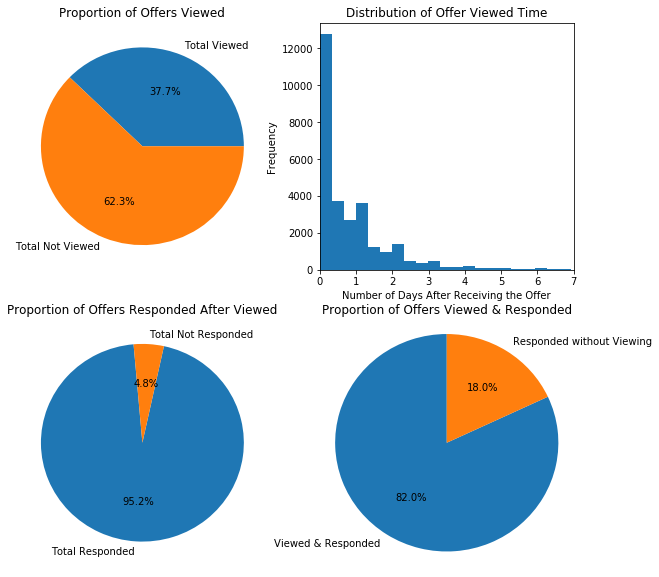

In [17]:
num_viewed = transcript_response[transcript_response.offer_viewed != 99.99].shape[0]
num_not_viewed = transcript_response[transcript_response.offer_viewed == 99.99].shape[0]

num_viewed_responded = transcript_response[(transcript_response.offer_viewed != 99.99)
                                   &(transcript_response.offer_responded == 1)].shape[0]
num_viewed_not_responded = transcript_response[(transcript_response.offer_viewed != 99.99)
                                       &(transcript_response.offer_responded != 1)].shape[0]

num_not_viewed_responded = transcript_response[(transcript_response.offer_viewed == 99.99)
                                       &(transcript_response.offer_responded == 1)].shape[0]


fig, ax = plt.subplots(2,2,figsize=[10,10])

# plot 1
ax[0,0].pie([num_viewed,num_not_viewed],labels=['Total Viewed','Total Not Viewed'],
           autopct='%1.1f%%')
ax[0,0].set_title('Proportion of Offers Viewed')

# plot 2
ax[1,0].pie([num_viewed_responded,num_viewed_not_responded],
            labels=['Total Responded','Total Not Responded'],
            autopct='%1.1f%%',startangle=95)
                       
ax[1,0].set_title('Proportion of Offers Responded After Viewed')


# plot 3
ax[1,1].pie([num_viewed_responded,num_not_viewed_responded],
            labels=['Viewed & Responded','Responded without Viewing'],
            autopct='%1.1f%%',startangle=90, radius=1.1)
                       
ax[1,1].set_title('Proportion of Offers Viewed & Responded')


# plot 4: How long does it take for the offer to be viewed?
ax[0,1].hist(transcript_response[transcript_response.offer_viewed != 99.99].offer_viewed, bins = 50)
ax[0,1].set_xlim([0,7])
ax[0,1].set_xlabel('Number of Days After Receiving the Offer')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of Offer Viewed Time')

plt.show()


From the above graphs, we can understand that:

- Of all the offers sent, 37.7% were viewed during the test.
- Majority of the participants viewed the offer within one day of receiving the offer.
- Of all the offers that have been viewed, 95.2% of the participants responded to the offer.
- Of all the offers that have been responded, 82.0% viewed the offer. The remaining 18.0% participants responded to the offer even they did not know the offer existed (i.e. they did not view the offer).

#### <a id = "104-3"> What types of offer are most likely to be responded? <a/>

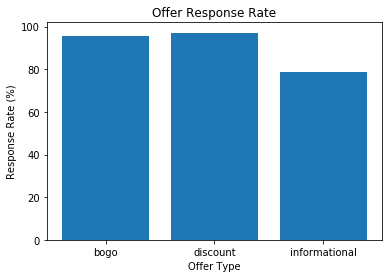

In [18]:
viewed_df = transcript_response[transcript_response.offer_viewed != 99.99]

viewed_responded_df = viewed_df[viewed_df.offer_responded ==1]

bogo_responded = viewed_responded_df[viewed_responded_df.offer_type=='bogo'].shape[0]/viewed_df[viewed_df.offer_type=='bogo'].shape[0]
discount_responded = viewed_responded_df[viewed_responded_df.offer_type=='discount'].shape[0]/viewed_df[viewed_df.offer_type=='discount'].shape[0]
info_responded = viewed_responded_df[viewed_responded_df.offer_type=='informational'].shape[0]/viewed_df[viewed_df.offer_type=='informational'].shape[0]

plt.bar(x=['bogo','discount','informational'],
        height=[bogo_responded*100,discount_responded*100,info_responded*100]
       )
plt.xlabel('Offer Type')
plt.ylabel('Response Rate (%)')
plt.title('Offer Response Rate')
plt.show()


From the above graph, it seems that discount offer has the highest response rate. This is followed by bogo, which has slightly lower response rate, however it is still over 90%. Informational offer has the lowest response rate with nearly 80%.



#### <a id = "104-4"> What is the general demographics of each offer type? <a/>

<Figure size 432x288 with 0 Axes>

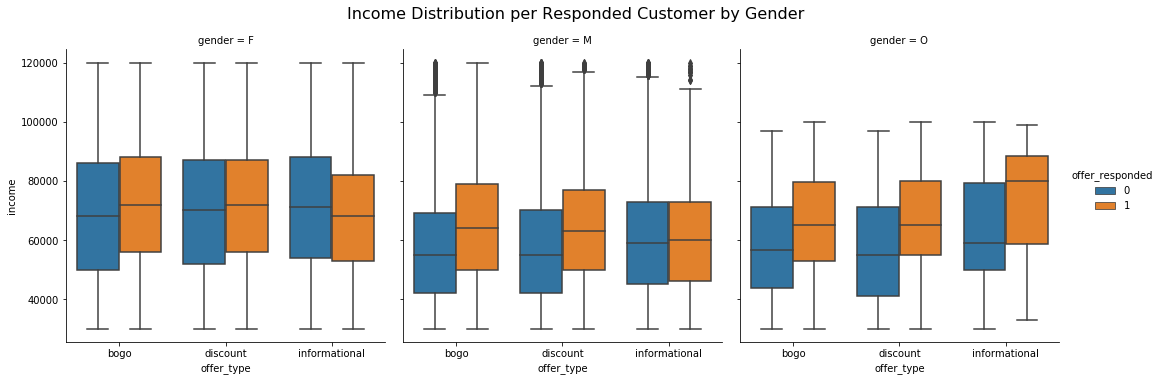

In [19]:
# income distribution of each responded offer type for each gender

plt.subplots_adjust(top=0.8)
g=sns.catplot(x="offer_type", y="income", col="gender", hue='offer_responded',
               data=transcript_response, kind='box')

g.fig.suptitle('Income Distribution per Responded Customer by Gender', fontsize=16,y=1.05)


plt.show()

/Users/yc28/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

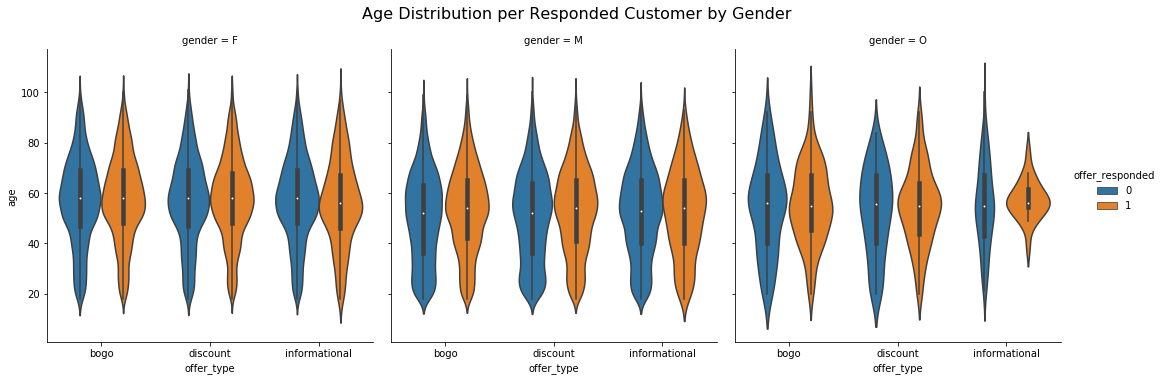

In [20]:
plt.subplots_adjust(top=0.8)
g=sns.catplot(x="offer_type", y="age", col="gender", hue='offer_responded',
               data=transcript_response, kind='violin')

g.fig.suptitle('Age Distribution per Responded Customer by Gender', fontsize=16,y=1.05)


plt.show()


<Figure size 432x288 with 0 Axes>

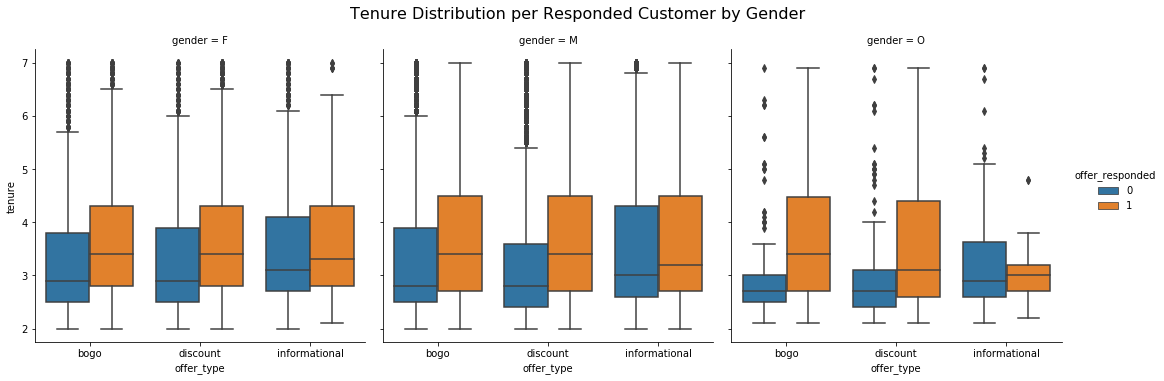

In [21]:
# tenure distribution of each responded offer type for each gender

plt.subplots_adjust(top=0.8)
g=sns.catplot(x="offer_type", y="tenure", col="gender", hue='offer_responded',
               data=transcript_response, kind='box')

g.fig.suptitle('Tenure Distribution per Responded Customer by Gender', fontsize=16,y=1.05)


plt.show()

From the above income, age and membership tenure distribution charts, we can understand that:

- Customers who responded to the offers tend to have slightly higher income (shown by higher mid point).
- Of the same income level, female customers are more likely to respond to the offers than other genders.
- There is no major difference in age for customers responded/did not respond to the offers.
- Customers with longer membership tenure tend to respond to the offers more than those who have lower tenure. This trend is significant across all genders.

# <a id = "105"> V. Build Model <a/>

In this section, we would like to use machine learning techniques to identify whether a customer will respond to an offer, and what are the most important features to determine a response. This will be done via the following steps:

- Pre-processing data for modelling
- Model training and model refinement using hyperparameter tuning
- Feature importance

#### <a id = "105-1">Pre-processing data for modelling <a/>

For data pre-processing, I am going to convert the categorical variables to dummies, and split the training and test datasets using train_test_split.

In [22]:
# Create a function that makes dummy columns for all categorical columns
def create_dummy_df(df, cat_cols, dummy_na=False):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis = 1), pd.get_dummies(df[col], prefix = col, prefix_sep = '_', 
                            drop_first = True, dummy_na = dummy_na)], axis = 1
                )
        except:
            pass
    return df

In [25]:
# Adjust the datasets for training purpose, and split train and test data

def preprocessing(df):
    # customers who respond to the offer without viewing are not in the scope of the promotion campaign 
    # Therefore we exclude them from the data
    df = df[~((df.offer_viewed ==99.99)&(df.offer_responded==1))]
    
    # drop unnecessary cols
    df.drop(labels=['person','time','value','offer_viewed'],axis=1, inplace=True)
    
    # convert channel col to col of strings, not lists
    df['channels']=df['channels'].astype(str)
    
    # convert offer_type, channels, gender to dummy cols
    df = create_dummy_df(df, ['offer_type', 'channels', 'gender'])

    # fill NaNs
    df.fillna(df.mean(),inplace=True)
    return df

In [26]:
model_data = preprocessing(transcript_response)

/Users/yc28/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/yc28/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [27]:
# split train and test data
X = model_data.drop('offer_responded', axis = 1)
y = model_data['offer_responded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)


#### <a id = "105-2"> Model training <a/>

In this section, I am going to apply the training data on the commonly used 2 machine learning models: random forest classifier and gradient boosting classifier. A brief overview of these models are as follows:

- Random forest classifier: randomly split the training data into several subsets with replacement. Each subset in the random forest generates a decision tree and a prediction result. The prediction result that the majority of decision trees points at is the final prediction outcome. 
 
 
- Gradient boosting classifier: iterates through a set of decision trees, taking the prediction result of previous decision tree and reflect in the target of the next tree so that it minimises prediction error. This model is good at minimising the model variance, however, it could be subject to the overfitting problem.


#### <a id = "105-3"> Model refinement using hyperparameter tuning <a/>

After identifying the suitable models, we would like to tune the model with hyperparameters. To search for the optimal parameters, I will define a set grid of parameters, and use RandomizedSeachCV to do the randomised search of the optimal combination of different parameters. I have set the number of iterations to be 100 and cv to be 3 to go over a fair amount of parameter combinations with the consideration of minimising the overfitting problem.

In [50]:
def randomized_search(modeltype, param_grid={}):
    model = RandomizedSearchCV(estimator=modeltype, 
                              param_distributions=param_grid, n_iter=50, cv=3, scoring='f1')

    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1:]
    precision, recall,thresholds = precision_recall_curve(y_test, y_scores)
    f1 = 2 * (precision * recall) / (precision + recall)
    best_f1_threshold = thresholds[np.argsort(-f1)[0]]
    y_preds = np.where(y_scores >= best_f1_threshold, 1, 0)
    
    
    print('Accuracy Score on Test Set: ', np.round(accuracy_score(y_test, y_preds), 2))
    print('Precision Score on Test Set: ', np.round(precision_score(y_test, y_preds), 2))
    print('Recall Score on Test Set: ', np.round(recall_score(y_test, y_preds), 2))
    print('F1 Score on Test Set', np.round(f1_score(y_test, y_preds), 2))
    
    return model

In [51]:
# create gradientboosting classifier
rf_param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 10],
    'min_samples_split' : [10, 100],
    'min_samples_leaf' : [10, 100],
    'n_estimators' : [50, 200, 300]
    
}


rf_model = randomized_search(RandomForestClassifier(random_state=42),param_grid=rf_param_grid)

Accuracy Score on Test Set:  0.74
Precision Score on Test Set:  0.63
Recall Score on Test Set:  0.79
F1 Score on Test Set 0.7


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10], 'min_samples_split': [10, 100], 'min_samples_leaf': [10, 100], 'n_estimators': [50, 200, 300]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [52]:
# create gradientboosting classifier
gb_param_grid = {'loss': ['deviance', 'exponential'],
               'learning_rate': [0.1, 0.01, 0.001],
               'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
               'min_samples_leaf': [10,100],
               'min_samples_split': [10,100]}



gb_model = randomized_search(GradientBoostingClassifier(random_state=42), param_grid=gb_param_grid)

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metric

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metric

/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yc28/anaconda3/lib/python3.7/site-packages/sklearn/metric

Accuracy Score on Test Set:  0.73
Precision Score on Test Set:  0.62
Recall Score on Test Set:  0.8
F1 Score on Test Set 0.7


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.01, 0.001], 'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300], 'min_samples_leaf': [10, 100], 'min_samples_split': [10, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

From the model training and refinement sections it can be seen that random forest model gives the higher accracy score and precision score, however, gradient boosting model has the higher for recall rate. Considering the F1 score is the same for the two models, it depends on whether precision weighs over recall, or vice versa. If the cost for sending out offers to customer is not considerably high, than Starbucks might want to target as many potential respondents as possibe, which means a high recall score is required. 

On the other hand, if the cost for sending out offers is too high, this means that Starbucks would not want to send out offers to customers who might ignore the offer. In this case, precision weighs over recall, then random forest model would be the choice. 

If we assume that Starbucks focuses more on precision, then random forest model would be the one we go for. If so, the most important features to determine the response from a customer are as follows:

#### <a id = "105-4"> Feature importance <a/>

Once the model is finalised, we would like to use the model to identify the most important features to motivate a customer to respond to the promotional offer.

In [53]:
model = rf_model

fi_dict = {
    'feature' : [],
    'importance' : []
}

features = model_data.columns[1:].tolist()

for feature, score in zip(features, model.best_estimator_.feature_importances_):
    fi_dict['feature'].append(feature)
    fi_dict['importance'].append(score)
    
    
fi_df = pd.DataFrame(fi_dict)

display(fi_df.sort_values(by=['importance'], ascending=False).head(5))

Accuracy Score on Test Set:  0.74
Precision Score on Test Set:  0.64
Recall Score on Test Set:  0.77
F1 Score on Test Set 0.7


,feature,importance
3,tenure,0.224024
6,"channels_['web', 'email', 'mobile', 'social']",0.206678
0,difficulty,0.152535
5,offer_type_informational,0.111510
2,income,0.108912


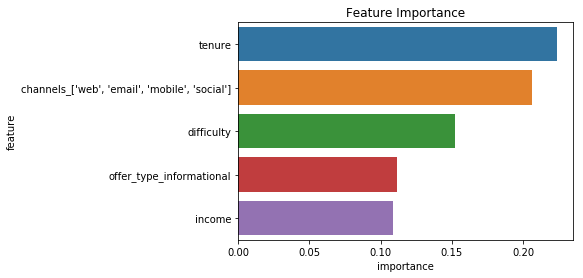

In [54]:
sns.barplot(y='feature', x='importance', data=fi_df.sort_values(by=['importance'], ascending=False).head(5), orient='h')
plt.title('Feature Importance')
plt.show()

From the above graph, it can be seen that tenure is the biggest determinant for a customer to respond to an offer. This makes sense intuitively, because if a customer is has been a regular Starbucks customer for a long time, he or she is very likely to use the offer to reduce the cost of purchase. Other features such as marketing channels (web, email mobile, social), difficulty in redeeming the offer, information offer and income level are also the top features to motivate a customer to make the offer.

# <a id = "106"> VI. Conclusion <a/>

The aim of this project is to analyse the customer behaviour towards the Starbucks promotional offers, predict whether a customer will respond to an offer and suggest what features will motivate the customers to make the purchase with the offer.

Through the data analysis, we understand that 37.7% of the customers viewed the offer sent, of which 95.2% responded to the offer. We also know that there appears to be no major difference in age for customers responded/did not respond to the offers. However, customers with longer membership tenure tend to respond to the offers more than those who have lower tenure. This trend is significant across all genders.

To predict whether a customer will respond to an offer, we first compare random forest classifier and gradient boosting classifier to see which model is better in terms of accuracy. Then we tune the model using optimal parameters powered by RandomizedSearchCV. Finally, we use this model to suggest the most important features for the prediction, for which tenure has the highest ranking.

For further improvement, there are several aspects to consider. For example, we did not use reward data in this analysis, which could inform a transaction decision depending the amount. Hence, future improvement could incorporate this aspect. In addition, there are other machine learning models such as bagging classifier which could provide decent result for prediction. It is worth testing out on those models as well, or use ensemble learning to combine several models for prediction. 